In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 15 August 2023
# Description:
#     this script get the heat transport across 1500m calculate for individual experiments:
# WAOM10: WAOM10extend_shflim_S_0.25Q_Cross-1500m-Transport.ipynb
# WAOM4: WAOM4extend_shflim_S_0.25Q_Cross-1500m-Transport.py
# WAOM4-NOTIDE: WAOM4extend_shflim_S_0.25Q_notides_Cross-1500m-Transport.py
# WAOM2:
# and plot vertically-integrated analyses:
# 1) annual average


In [2]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as  np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import cmocean

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import pyresample

import gsw


from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client()
client

<Client: 'tcp://127.0.0.1:39111' processes=7 threads=28, memory=0.98 TiB>

In [4]:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

In [5]:
# determine constants:
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

# use same values as access-om2-01
rho0 = 1035 # kg. m-3
Cp = 3992.1 # J.kg-1.degC-1



In [7]:
%%time

# load waom4 3D temp field to plot some maps
path_ECCO2_4km = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_00*.nc'

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp3d_4km= ds.variables["temp"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho3d_4km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
del Zo_rho
ds.close()

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-10yr_notides/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp3d_4kmNT= ds.variables["temp"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho3d_4kmNT = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
del Zo_rho
ds.close()

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp3d_10km= ds.variables["temp"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho3d_10km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
del Zo_rho
ds.close()

# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")
lat_rho_4km= dg.variables["lat_rho"]
lon_rho_4km = dg.variables["lon_rho"]
pm_4km = dg.variables["pm"]
pn_4km = dg.variables["pn"]
zice_4km = dg.variables["zice"]
h_4km = dg.variables["h"]
dg.close()
print('Print lon/lat_rho shapes',lon_rho_4km.shape, lat_rho_4km.shape)
print('Print lon/lat_rho shapes',lon_rho_4km[0:-1,0:-1].shape, lat_rho_4km[0:-1,0:-1].shape)

dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()

temp3d_4km.load()
z_rho3d_4km.load()

temp3d_4kmNT.load()
# z_rho3d_4km.load()

temp3d_10km.load()
z_rho3d_10km.load()

Print lon/lat_rho shapes (1400, 1575) (1400, 1575)
Print lon/lat_rho shapes (1399, 1574) (1399, 1574)
CPU times: user 9.67 s, sys: 19.2 s, total: 28.9 s
Wall time: 55.9 s


<xarray.DataArray (ocean_time: 12, eta_rho: 560, xi_rho: 630, s_rho: 31)> Size: 1GB
array([[[[-4.04414644e+03, -4.02676220e+03, -3.99135732e+03, ...,
          -2.82181433e+01, -1.47373660e+01, -4.26944083e+00],
         [-4.26838289e+03, -4.25040145e+03, -4.21334278e+03, ...,
          -2.88106586e+01, -1.49615457e+01, -4.30193442e+00],
         [-4.37797399e+03, -4.35970147e+03, -4.32183526e+03, ...,
          -2.91072566e+01, -1.50789370e+01, -4.32646590e+00],
         ...,
         [-3.12444912e+03, -3.10954576e+03, -3.08095219e+03, ...,
          -2.60604079e+01, -1.41224909e+01, -4.47342436e+00],
         [-3.05779750e+03, -3.04307636e+03, -3.01497834e+03, ...,
          -2.58716248e+01, -1.40480662e+01, -4.46097458e+00],
         [-3.20284124e+03, -3.18772411e+03, -3.15854816e+03, ...,
          -2.62804679e+01, -1.42086126e+01, -4.48723307e+00]],

        [[-4.48395333e+03, -4.46539968e+03, -4.42675275e+03, ...,
          -2.93752355e+01, -1.51740006e+01, -4.33213993e+00],
         [-4.35018709e+03, -4.33198831e+03, -4.29432675e+03, ...,
          -2.90254429e+01, -1.50424943e+01, -4.31350484e+00],
         [-4.35507773e+03, -4.33686599e+03, -4.29916848e+03, ...,
          -2.90472694e+01, -1.50563571e+01, -4.32325092e+00],
...
         [-4.54396679e+03, -4.52525839e+03, -4.48617843e+03, ...,
          -3.05576251e+01, -1.62619186e+01, -5.37211136e+00],
         [-4.56198810e+03, -4.54323195e+03, -4.50401924e+03, ...,
          -3.05975553e+01, -1.62725014e+01, -5.36755573e+00],
         [-4.61885735e+03, -4.59995065e+03, -4.56031929e+03, ...,
          -3.07454131e+01, -1.63278909e+01, -5.37530165e+00]],

        [[-4.45242806e+03, -4.43396123e+03, -4.39555325e+03, ...,
          -3.00726480e+01, -1.59252900e+01, -5.11187320e+00],
         [-4.15657499e+03, -4.13889439e+03, -4.10266693e+03, ...,
          -2.92954151e+01, -1.56322571e+01, -5.06992764e+00],
         [-4.18506943e+03, -4.16731302e+03, -4.13087556e+03, ...,
          -2.93872121e+01, -1.56773146e+01, -5.09068080e+00],
         ...,
         [-4.63395144e+03, -4.61500483e+03, -4.57526243e+03, ...,
          -3.07915950e+01, -1.63495704e+01, -5.38437106e+00],
         [-4.67109271e+03, -4.65204782e+03, -4.61203201e+03, ...,
          -3.08809815e+01, -1.63786209e+01, -5.38236775e+00],
         [-4.95408612e+03, -4.93429402e+03, -4.89219653e+03, ...,
          -3.16117144e+01, -1.66511929e+01, -5.41988530e+00]]]])
Coordinates:
    Vtransform  int32 4B 2
    hc          float64 8B 250.0
    h           (eta_rho, xi_rho) float64 3MB 4.05e+03 4.274e+03 ... 4.96e+03
    x_rho       (eta_rho, xi_rho) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    y_rho       (eta_rho, xi_rho) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * ocean_time  (ocean_time) datetime64[ns] 96B 2016-01-14T05:00:00 ... 2016-...
  * s_rho       (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    Cs_r        (s_rho) float64 248B -0.9995 -0.997 ... -0.0008464 -9.329e-05
Dimensions without coordinates: eta_rho, xi_rho

### load variables (vol&heat transp, T,S, z, distance, lat/lon) along/across the contour:

#### 1500m isobath

In [8]:
# load ice draft to create masks
expt = 'WAOM10'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_1500m_daily_v3')
vol_transport_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_1500m_daily_v3')
heat_transport_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_1500m_daily_v3')
temp_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_1500m_daily_v3')
salt_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3')
z_rho_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_1500m_v3')
dist_along_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_10km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_10km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_1500m_v3')
distance_indices_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

In [10]:
# load ice draft to create masks
expt = 'WAOM10_newcode'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_1500m_daily_v3')
vol_transport_10kmNC = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_1500m_daily_v3')
heat_transport_10kmNC = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_1500m_daily_v3')
temp_10kmNC = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_1500m_daily_v3')
salt_10kmNC = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3')
z_rho_10kmNC = ds.variables["__xarray_dataarray_variable__"]
ds.close()



In [11]:
%%time

expt = 'WAOM4'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_1500m_daily_v3')
vol_transport_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_1500m_daily_v3')
heat_transport_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_1500m_daily_v3')
temp_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_1500m_daily_v3')
salt_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3') # replace for z_rho_1500m_daily_v2 when it finishes (9/8/23)
z_rho_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_1500m_v3')
dist_along_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_4km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_4km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_1500m_v3')
distance_indices_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

CPU times: user 145 ms, sys: 63.5 ms, total: 208 ms
Wall time: 728 ms


In [12]:
%%time
expt = 'WAOM4_notides'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_1500m_daily_v3')
vol_transport_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_1500m_daily_v3')
heat_transport_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_1500m_daily_v3')
temp_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_1500m_daily_v3')
salt_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3') # replace for z_rho_1500m_5daily when it finishes (9/8/23)
z_rho_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()


CPU times: user 88.4 ms, sys: 32.3 ms, total: 121 ms
Wall time: 398 ms


#### Calving Front


In [13]:
# load ice draft to create masks
expt = 'WAOM10'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_CF_daily_v3')
vol_transport_10km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_CF_daily_v3')
heat_transport_10km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_CF_daily_v3')
temp_10km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_CF_daily_v3')
salt_10km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_CF_daily_v3')
z_rho_10km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_CF_v3')
dist_along_10km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_v3')
lon_along_10km_CF = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CF_v3')
lat_along_10km_CF = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_CF_v3')
distance_indices_10km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

In [14]:
%%time

expt = 'WAOM4'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_CF_daily_v3')
vol_transport_4km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_CF_daily_v3')
heat_transport_4km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_CF_daily_v3')
temp_4km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_CF_daily_v3')
salt_4km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_CF_daily_v3') # replace for z_rho_CF_daily_v3 when it finishes (9/8/23)
z_rho_4km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_CF_v3')
dist_along_4km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_v3')
lon_along_4km_CF = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CF_v3')
lat_along_4km_CF = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_CF_v3')
distance_indices_4km_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

CPU times: user 146 ms, sys: 60.3 ms, total: 207 ms
Wall time: 881 ms


In [15]:
%%time
expt = 'WAOM4_notides'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_CF_daily_v3')
vol_transport_4kmNT_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_CF_daily_v3')
heat_transport_4kmNT_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_CF_daily_v3')
temp_4kmNT_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_CF_daily_v3')
salt_4kmNT_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_CF_daily_v3') # replace for z_rho_CF_5daily when it finishes (9/8/23)
z_rho_4kmNT_CF = ds.variables["__xarray_dataarray_variable__"]
ds.close()


CPU times: user 133 ms, sys: 49.5 ms, total: 183 ms
Wall time: 716 ms


### obtain area and distances

In [16]:
# define along_contour axis with same length for both resolutions:
[dist_along_axis_10km, Zaxis_10km] = np.meshgrid(dist_along_10km, np.arange(0,31))
[dist_along_axis_4km, Zaxis_4km] = np.meshgrid(dist_along_4km, np.arange(0,31))


# # Obtain area of the section along the isobath contour:
# # first get the distance/dy:
# dy_10km_tmp = dist_along_axis_10km[:,1:-1] - dist_along_axis_10km[:,0:-2]
# # repeate first and last dy to match size:
# dy_10km = np.empty(dist_along_axis_10km.shape)
# dy_10km[:,1:-1] =  dy_10km_tmp
# dy_10km[:,0] =  dy_10km_tmp[:,0]
# dy_10km[:,-1] =  dy_10km_tmp[:,-1]

# # 4km: first get the distance/dy:
# dy_4km_tmp = dist_along_axis_4km[:,1:-1] - dist_along_axis_4km[:,0:-2]
# dy_4km = np.empty(dist_along_axis_4km.shape)
# dy_4km[:,1:-1] =  dy_4km_tmp
# dy_4km[:,0] =  dy_4km_tmp[:,0]
# dy_4km[:,-1] =  dy_4km_tmp[:,-1]

# # calculate area 
# area_10km = dy_10km*1e6 # convert back to meters:
# area_4km = dy_4km*1e6 # convert back to meters:


In [17]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'


# Binning the HT into density classes (sigma2)

In [18]:
# rho grid for binning:
rho_grid2=np.arange(36.2,37.4,0.025) # for sigma-2
len_rho_grid2=len(rho_grid2)


In [19]:
# # use salt and temp along the contour to calculate sigma:
sigma_2_10km = gsw.rho(salt_10km[:,:],temp_10km[:,:],2000) - 1000
sigma_2_4km = gsw.rho(salt_4km[:,:],temp_4km[:,:],2000) - 1000
sigma_2_4kmNT = gsw.rho(salt_4kmNT[:,:],temp_4kmNT[:,:],2000) - 1000

In [20]:
# same but for calving front (use salt and temp along the contour to calculate sigma):
sigma_2_10km_CF = gsw.rho(salt_10km_CF[:,:],temp_10km_CF[:,:],2000) - 1000
sigma_2_4km_CF = gsw.rho(salt_4km_CF[:,:],temp_4km_CF[:,:],2000) - 1000
sigma_2_4kmNT_CF = gsw.rho(salt_4kmNT_CF[:,:],temp_4kmNT_CF[:,:],2000) - 1000


#### 1500m isobath

In [21]:
# DEFINE coldest temp along contour:

Tf_10km = temp_10km.min().values
Tf_4km = temp_4km.min().values
Tf_4kmNT = temp_4kmNT.min().values

Tf_10km_CF = temp_10km_CF.min().values
Tf_4km_CF = temp_4km_CF.min().values
Tf_4kmNT_CF = temp_4kmNT_CF.min().values

print(Tf_10km, Tf_4km, Tf_4kmNT)
print(Tf_10km_CF, Tf_4km_CF, Tf_4kmNT_CF)

Tf = Tf_4kmNT # lowest of them all
print(Tf)

-2.850733518600464 -3.283663511276245 -3.534879684448242
-2.9521701335906982 -3.2196805477142334 -3.183741807937622
-3.534879684448242


In [48]:
%time
# WAOM10

Tf_heat_transp_10km = Tf*vol_transport_10km*rho0*Cp # it doesn't matter if the mean is done now or later; Tf is cte.
                                                    # does it should matter? If we subtract V*Tf for each grid-point at each timestep
                                                    # Tests show it doesn't matter.
heat_transp_10km = np.empty((365,2690)) 
for mm in np.arange(0,365):
    heat_transp_10km[mm,:] = heat_transport_10km[mm,:,:].sum('s_rho')*rho0*Cp - Tf_heat_transp_10km[mm,:,:].sum('s_rho')

# Total HT (online diag) annual-avg:
# annual_transp_10km = heat_transp_10km.mean('ocean_time')*rho0*Cp

# calculate Mean as v_bar*T_bar, vert-discretised version:
Mean_transp_10km = vol_transport_10km.mean('ocean_time')*(temp_10km.mean('ocean_time')-Tf)*rho0*Cp
Mean_transp_noTf_10km = vol_transport_10km.mean('ocean_time')*temp_10km.mean('ocean_time')*rho0*Cp

# Eddy heat transport: total - Mean
Eddy_transp_10km = np.empty((365,2690)) 
Eddy_transp_noTf_10km = np.empty((365,2690)) 
Eddy_transp_Tf_10km = np.empty((365,31,2690)) 
for mm in np.arange(0,365):
    Eddy_transp_10km[mm,:] = (heat_transp_10km[mm,:]) - Mean_transp_10km.sum('s_rho')
    Eddy_transp_noTf_10km[mm,:] = (heat_transport_10km[mm,:]).sum('s_rho')*rho0*Cp - Mean_transp_noTf_10km.sum('s_rho')
    Eddy_transp_Tf_10km[mm,:,:] = (heat_transport_10km[mm,:]*rho0*Cp) - vol_transport_10km.mean('ocean_time')*(temp_10km[mm,:,:]-Tf)*rho0*Cp
    



CPU times: user 4 µs, sys: 8 µs, total: 12 µs
Wall time: 28.4 µs


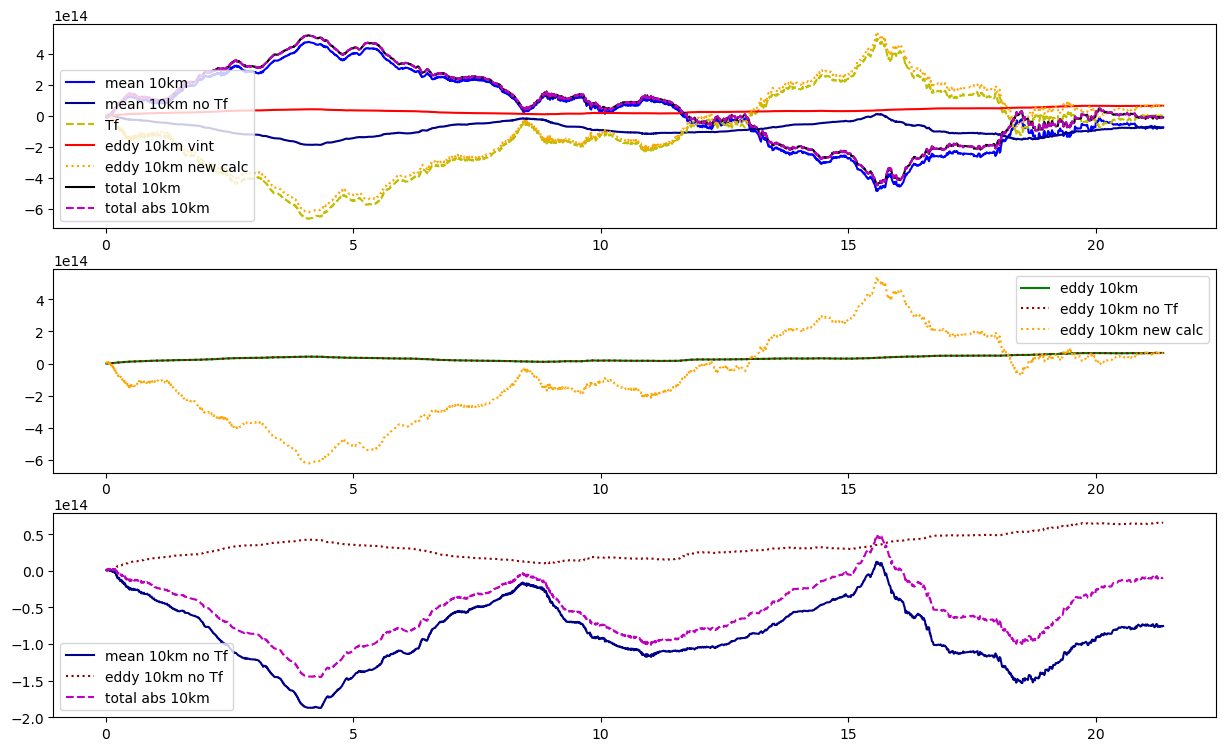

In [59]:
fig=plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(311)
ax1.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_10km, axis=0),axis=-1),'-b', label='mean 10km')
ax1.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_noTf_10km, axis=0),axis=-1),'-',color='darkblue', label='mean 10km no Tf')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Tf_heat_transp_10km, axis=1), axis=0),axis=-1),'--y', label='Tf')
# ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(heat_transp_10km, axis=1), axis=0),axis=-1),'--k', label='total 10km')
# ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km, axis=1), axis=0),axis=-1),'-g', label='eddy 10km')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(Eddy_transp_10km, axis=0),axis=-1),'-r', label='eddy 10km vint')
# ax1.plot(dist_along_10km,np.cumsum(np.nanmean(Eddy_transp_noTf_10km, axis=0),axis=-1),':',color='darkred', label='eddy 10km no Tf')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_Tf_10km, axis=1), axis=0),axis=-1),':',color='orange', label='eddy 10km new calc')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(heat_transp_10km, axis=0),axis=-1),'-k', label='total 10km')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(heat_transport_10km*rho0*Cp-Tf_heat_transp_10km, axis=1), axis=0),axis=-1),'--m', label='total abs 10km')

# ax1.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_10kmNC, axis=0),axis=-1),':r', label='mean 10km NC')
# ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10kmNC, axis=1), axis=0),axis=-1),':g', label='eddy 10km NC')
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(Eddy_transp_10km, axis=0),axis=-1),'-g', label='eddy 10km')
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(Eddy_transp_noTf_10km, axis=0),axis=-1),':',color='darkred', label='eddy 10km no Tf')
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_Tf_10km, axis=1), axis=0),axis=-1),':',color='orange', label='eddy 10km new calc')
ax2.legend()

ax3 = fig.add_subplot(313)
ax3.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_noTf_10km, axis=0),axis=-1),'-',color='darkblue', label='mean 10km no Tf')
ax3.plot(dist_along_10km,np.cumsum(np.nanmean(Eddy_transp_noTf_10km, axis=0),axis=-1),':',color='darkred', label='eddy 10km no Tf')
ax3.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(heat_transport_10km*rho0*Cp, axis=1), axis=0),axis=-1),'--m', label='total abs 10km')
ax3.legend()

In [160]:
%time
# WAOM10 new code

Tf_heat_transp_10kmNC = Tf*vol_transport_10kmNC*rho0*Cp # it doesn't matter if the mean is done now or later; Tf is cte.

heat_transp_10kmNC = heat_transport_10kmNC*rho0*Cp - Tf_heat_transp_10kmNC

# Total HT (online diag) annual-avg:
annual_transp_10kmNC = heat_transp_10kmNC.mean('ocean_time')*rho0*Cp

# calculate Mean as v_bar*T_bar, vert-discretised version:
Mean_transp_10kmNC = vol_transport_10kmNC.mean('ocean_time')*(temp_10kmNC.mean('ocean_time')-Tf)*rho0*Cp
Mean_transp_noTf_10kmNC = vol_transport_10kmNC.mean('ocean_time')*temp_10kmNC.mean('ocean_time')*rho0*Cp

# Eddy heat transport: total - Mean
Eddy_transp_10kmNC = np.empty((365,31,2690)) 
Eddy_transp_vint_10kmNC = np.empty((365,2690)) 
for mm in np.arange(0,365):
    # Eddy_transp_10kmNC[mm,:,:] = (heat_transport_10kmNC[mm,:,:]) - Mean_transp_10kmNC
    Eddy_transp_10kmNC[mm,:,:] = (heat_transp_10kmNC[mm,:,:]) - Mean_transp_10kmNC #- Tf_heat_transp_10kmNC
    Eddy_transp_vint_10kmNC[mm,:] = (heat_transp_10kmNC[mm,:].sum('s_rho')) - Mean_transp_10kmNC.sum('s_rho')
 



CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 11 µs


In [150]:
%time
# WAOM4

Tf_heat_transp_4km = Tf*vol_transport_4km*rho0*Cp # it doesn't matter if the mean is done now or later; Tf is cte.

heat_transp_4km = heat_transport_4km*rho0*Cp - Tf_heat_transp_4km

# Total HT (online diag) annual-avg:
annual_transp_4km = heat_transp_4km.mean('ocean_time')*rho0*Cp

# calculate Mean as v_bar*T_bar, vert-discretised version:
Mean_transp_4km = vol_transport_4km.mean('ocean_time')*(temp_4km.mean('ocean_time')-Tf)*rho0*Cp
Mean_transp_noTf_4km = vol_transport_4km.mean('ocean_time')*temp_4km.mean('ocean_time')*rho0*Cp

# Eddy heat transport: total - Mean
Eddy_transp_4km = np.empty((365,31,7056)) 
Eddy_transp_vint_4km = np.empty((365,7056)) 
for mm in np.arange(0,365):
    # Eddy_transp_4km[mm,:,:] = (heat_transport_4km[mm,:,:]) - Mean_transp_4km
    Eddy_transp_4km[mm,:,:] = (heat_transp_4km[mm,:,:]) - Mean_transp_4km #- Tf_heat_transp_4km
    Eddy_transp_vint_4km[mm,:] = (heat_transp_4km[mm,:].sum('s_rho')) - Mean_transp_4km.sum('s_rho')
 



CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 30.5 µs


In [151]:
%time
# WAOM4

Tf_heat_transp_4kmNT = Tf*vol_transport_4kmNT*rho0*Cp # it doesn't matter if the mean is done now or later; Tf is cte.

heat_transp_4kmNT = heat_transport_4kmNT*rho0*Cp - Tf_heat_transp_4kmNT

# Total HT (online diag) annual-avg:
annual_transp_4kmNT = heat_transp_4kmNT.mean('ocean_time')*rho0*Cp

# calculate Mean as v_bar*T_bar, vert-discretised version:
Mean_transp_4kmNT = vol_transport_4kmNT.mean('ocean_time')*(temp_4kmNT.mean('ocean_time')-Tf)*rho0*Cp
Mean_transp_noTf_4kmNT = vol_transport_4kmNT.mean('ocean_time')*temp_4kmNT.mean('ocean_time')*rho0*Cp

# Eddy heat transport: total - Mean
Eddy_transp_4kmNT = np.empty((365,31,7056)) 
Eddy_transp_vint_4kmNT = np.empty((365,7056)) 
for mm in np.arange(0,365):
    # Eddy_transp_4kmNT[mm,:,:] = (heat_transport_4kmNT[mm,:,:]) - Mean_transp_4kmNT
    Eddy_transp_4kmNT[mm,:,:] = (heat_transp_4kmNT[mm,:,:]) - Mean_transp_4kmNT #- Tf_heat_transp_4kmNT
    Eddy_transp_vint_4kmNT[mm,:] = (heat_transp_4kmNT[mm,:].sum('s_rho')) - Mean_transp_4kmNT.sum('s_rho')
 



CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 11.2 µs


Text(0, 0.5, 'Depth (m)')

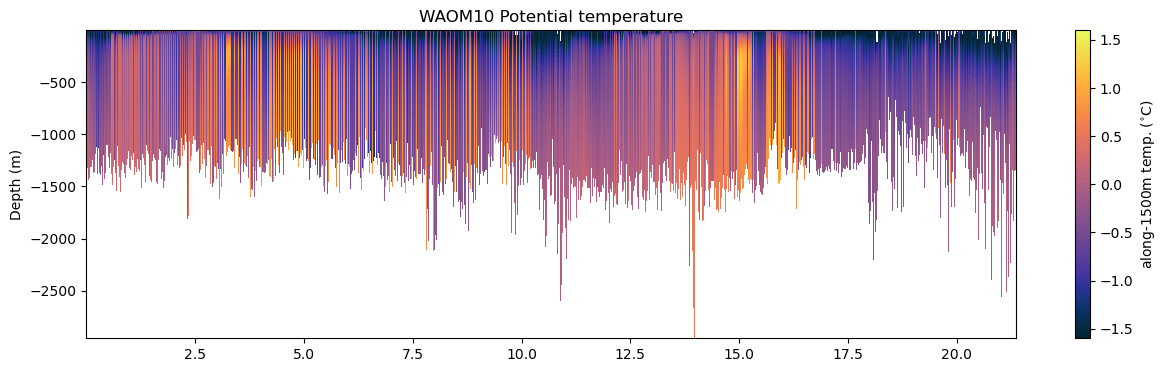

In [24]:
plt.figure(figsize=(15, 4))
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),temp_10km.mean('ocean_time'), vmin=-1.6, vmax=1.6, cmap=cmocean.cm.thermal)
cc=plt.colorbar()
plt.title('WAOM10 Potential temperature')
cc.set_label('along-1500m temp. ($^{\circ}$C)')
plt.ylabel('Depth (m)')

Text(0.5, 1.0, 'Advective cross-1500m volume transport (Sv)')

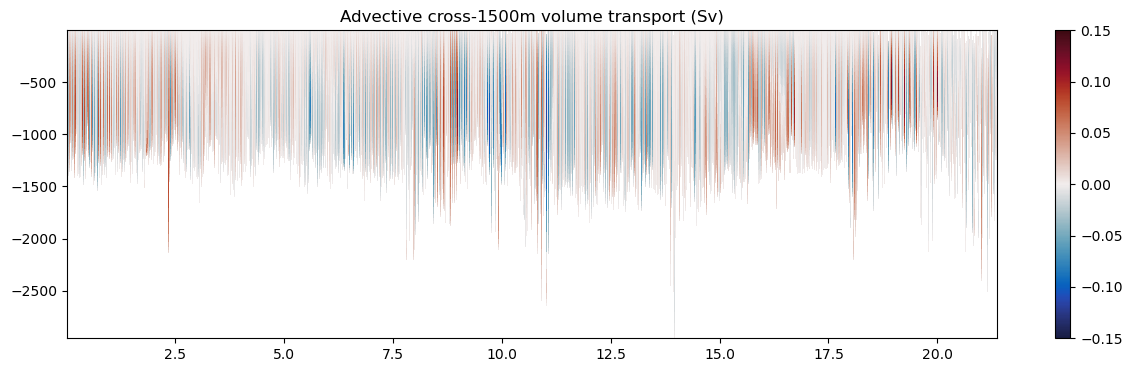

In [152]:
plt.figure(figsize=(15, 4))
# plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),vol_transport_10km.mean('ocean_time')*3*rho0*Cp, vmin=-2e12, vmax=2e12, cmap='bwr')
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),vol_transport_10km.mean('ocean_time')*1e-6 , vmin=-.15, vmax=.15, cmap=cmocean.cm.balance)
plt.colorbar()
plt.title('Advective cross-1500m volume transport (Sv)')

Text(0, 0.5, 'Depth (m)')

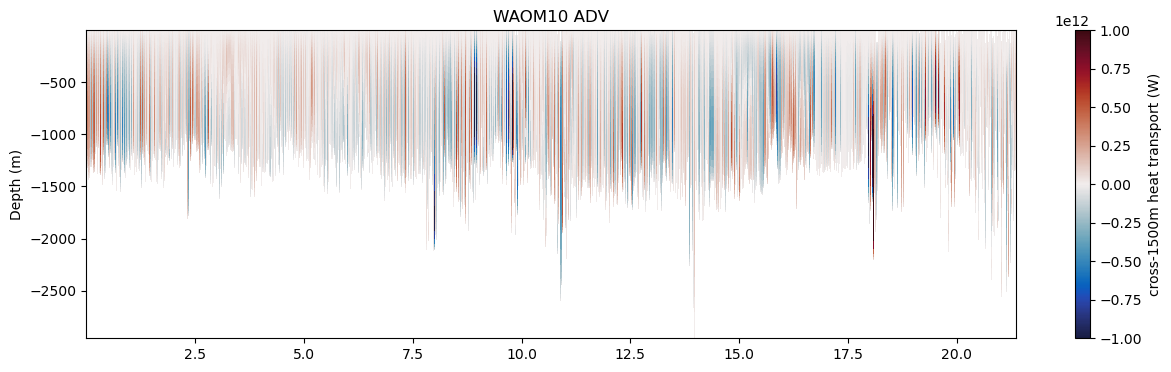

In [153]:
plt.figure(figsize=(15, 4))
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),(Mean_transp_10km), vmin=-1e12, vmax=1e12, cmap=cmocean.cm.balance)
cc=plt.colorbar()
plt.title('WAOM10 ADV')
cc.set_label('cross-1500m heat transport (W)')
plt.ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

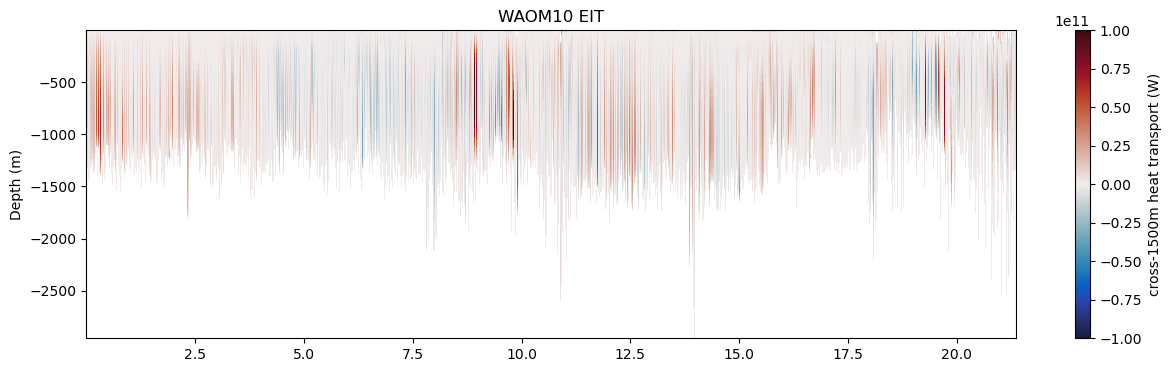

In [154]:
# note on the eddy transport: the way we calculate, first taking out Tf from mean/total HT, then subtracting (total - mean)
# makes the Tf*vol_transp term vanishes for eddy, so it isn't correct by that in the "Eddy_transp_Xkm" variables.
# For plots, need to do ---> (Eddy_transp_Xkm - Tf_heat_transp_Xkm) <---

plt.figure(figsize=(15, 4))
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),(np.nanmean(Eddy_transp_10km, axis=0)), vmin=-1e11, vmax=1e11, cmap=cmocean.cm.balance)
cc=plt.colorbar()
plt.title('WAOM10 EIT')
cc.set_label('cross-1500m heat transport (W)')
plt.ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

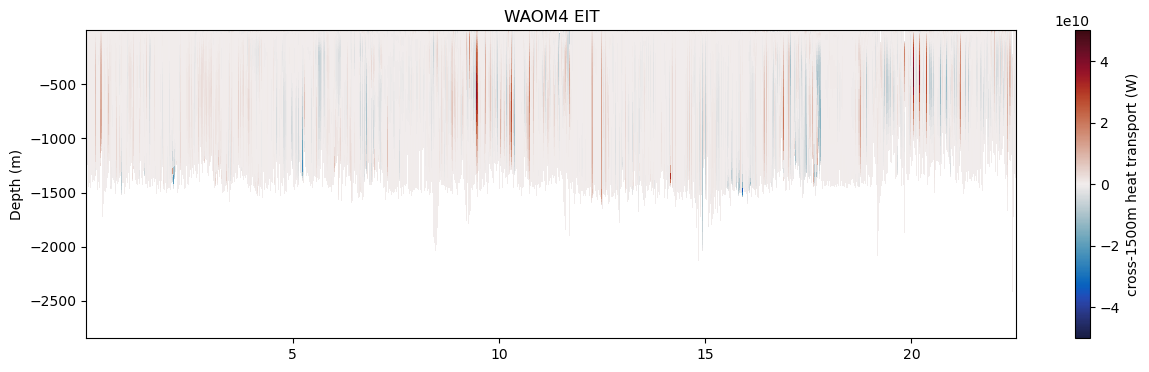

In [155]:
plt.figure(figsize=(15, 4))
plt.pcolormesh(dist_along_axis_4km,z_rho_4km.mean('ocean_time'),np.nanmean(Eddy_transp_4km, axis=0), vmin=-.5e11, vmax=.5e11, cmap=cmocean.cm.balance)
cc=plt.colorbar()
plt.title('WAOM4 EIT')
cc.set_label('cross-1500m heat transport (W)')
plt.ylabel('Depth (m)')

In [29]:
heat_transp_10km.shape

(365, 31, 2690)

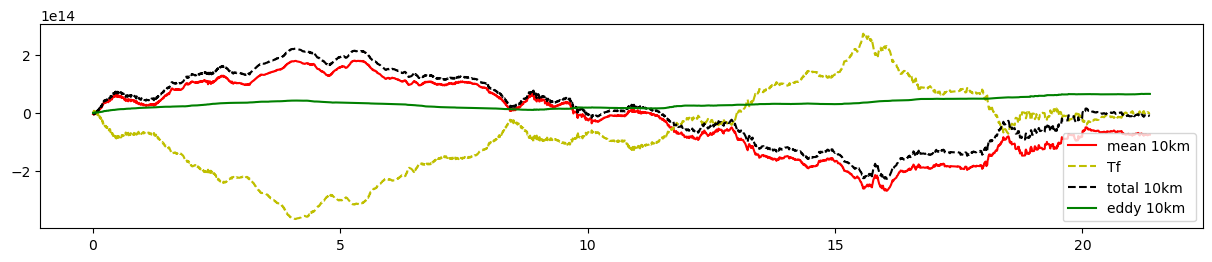

In [178]:
fig=plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(311)
ax1.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_10km, axis=0),axis=-1),'-r', label='mean 10km')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Tf_heat_transp_10km, axis=1), axis=0),axis=-1),'--y', label='Tf')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(heat_transp_10km, axis=1), axis=0),axis=-1),'--k', label='total 10km')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km, axis=1), axis=0),axis=-1),'-g', label='eddy 10km')
# ax1.plot(dist_along_10km,np.cumsum(np.nanmean(Eddy_transp_vint_10km, axis=0),axis=-1),':b', label='eddy 10km vint')
# ax1.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_10kmNC, axis=0),axis=-1),':r', label='mean 10km NC')
# ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10kmNC, axis=1), axis=0),axis=-1),':g', label='eddy 10km NC')
ax1.legend()

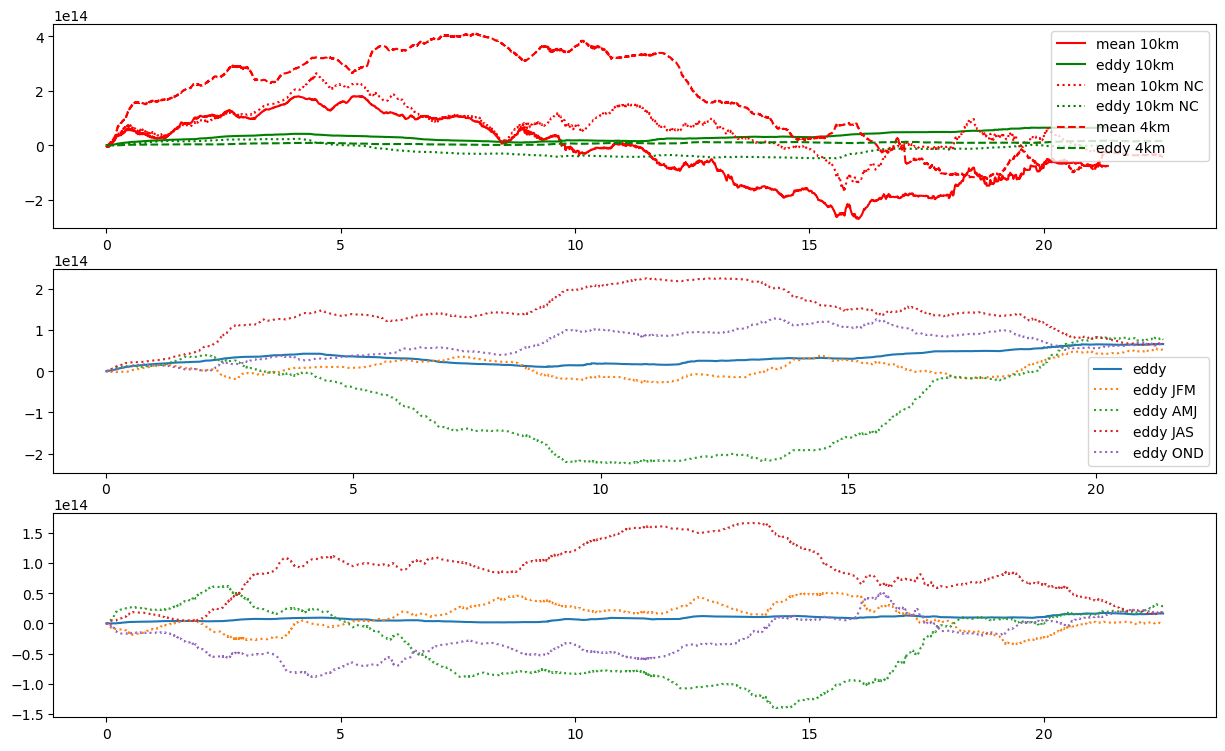

In [179]:
fig=plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(311)
ax1.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_10km, axis=0),axis=-1),'-r', label='mean 10km')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km, axis=1), axis=0),axis=-1),'-g', label='eddy 10km')
ax1.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_10kmNC, axis=0),axis=-1),':r', label='mean 10km NC')
ax1.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10kmNC, axis=1), axis=0),axis=-1),':g', label='eddy 10km NC')
ax1.plot(dist_along_4km,np.cumsum(np.sum(Mean_transp_4km, axis=0),axis=-1),'--r', label='mean 4km')
ax1.plot(dist_along_4km,np.cumsum(np.nanmean(np.sum(Eddy_transp_4km, axis=1), axis=0),axis=-1),'--g', label='eddy 4km')

ax1.legend()
# ax1.set_xlim(0,450)
# ax1.set_ylim(-1.5e13,1.5e13)
# ax1.set_ylim(-1.5e12,1.5e12)

ax2 = fig.add_subplot(312)
# ax2.plot(dist_along_10km,np.cumsum((np.sum(Mean_transp_10km, axis=0)-np.nanmean(np.sum(heat_transp_10km, axis=1), axis=0)), axis=-1),'--', label='mean - total')
# ax2.plot(dist_along_10km,np.cumsum((np.nanmean(np.sum(Eddy_transp_10km, axis=1), axis=0)-np.sum(Tf_heat_transp_10km, axis=0)-
#                                          np.nanmean(np.sum(heat_transp_10km, axis=1), axis=0)), axis=-1),':', label='eddy - total')

# ax2.plot(dist_along_10km,-np.cumsum(np.mean(Tf_heat_transp_10km, axis=0), axis=-1),':', label='-Tf HT')
Tf_ht=np.cumsum(np.sum(np.nanmean(Tf_heat_transp_10km, axis=0), axis=0), axis=-1)*rho0*Cp
# ax2.plot(dist_along_10km,np.cumsum(np.sum(Mean_transp_10km, axis=0),axis=-1),'--', label='mean')
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km, axis=1), axis=0), axis=-1),'-', label='eddy')
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km[0:90,:,:], axis=1), axis=0), axis=-1),':', label='eddy JFM')
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km[90:180,:,:], axis=1), axis=0), axis=-1),':', label='eddy AMJ')
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km[180:270,:,:], axis=1), axis=0), axis=-1),':', label='eddy JAS')
ax2.plot(dist_along_10km,np.cumsum(np.nanmean(np.sum(Eddy_transp_10km[270:360,:,:], axis=1), axis=0), axis=-1),':', label='eddy OND')

ax2.legend()
# ax2.set_xlim(0,4500)

ax2 = fig.add_subplot(313)
Tf_ht=np.cumsum(np.sum(Tf_heat_transp_4km, axis=0), axis=-1)*rho0*Cp
# ax2.plot(dist_along_4km,np.cumsum(np.sum(Mean_transp_4km, axis=0),axis=-1),'--', label='mean')
ax2.plot(dist_along_4km,np.cumsum(np.nanmean(np.sum(Eddy_transp_4km, axis=1), axis=0), axis=-1),'-', label='eddy')
ax2.plot(dist_along_4km,np.cumsum(np.nanmean(np.sum(Eddy_transp_4km[0:90,:,:], axis=1), axis=0), axis=-1),':', label='eddy JFM')
ax2.plot(dist_along_4km,np.cumsum(np.nanmean(np.sum(Eddy_transp_4km[90:180,:,:], axis=1), axis=0), axis=-1),':', label='eddy AMJ')
ax2.plot(dist_along_4km,np.cumsum(np.nanmean(np.sum(Eddy_transp_4km[180:270,:,:], axis=1), axis=0), axis=-1),':', label='eddy JAS')
ax2.plot(dist_along_4km,np.cumsum(np.nanmean(np.sum(Eddy_transp_4km[270:360,:,:], axis=1), axis=0), axis=-1),':', label='eddy OND')



In [162]:
print(np.sum(np.sum(Mean_transp_10km, axis=0),axis=-1)*1e-12)
print(np.sum(np.nanmean(np.sum(Eddy_transp_10km, axis=1), axis=0),axis=-1)*1e-12)

print(np.sum(np.sum(Mean_transp_10kmNC, axis=0),axis=-1)*1e-12)
print(np.sum(np.nanmean(np.sum(Eddy_transp_10kmNC, axis=1), axis=0),axis=-1)*1e-12)

<xarray.Variable ()> Size: 8B
array(-75.3829212)
65.75968310176404
<xarray.Variable ()> Size: 8B
array(-28.97437232)
-0.8858922944206953


For the vert-discretised plots above, we can see that
- (Mean - Tf) roughly matches with vol_transport;
- (Total-Mean) yield to eddy term, which is much smaller than Mean/Total (-Tf).
- one of the reasons it's much smaller is the -Tf; if it's added to the Eddy term, it became similar order as mean/eddy.


### Zonal convergence calculation:

In [33]:
## load 180W transect:
dx = xr.open_mfdataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross-1500m_transp/u_zonal_transect_bin=1.nc")
dx#.heat_transp

<xarray.Dataset> Size: 12MB
Dimensions:       (ocean_time: 365, s_rho: 31, transect_lat: 131)
Coordinates:
  * ocean_time    (ocean_time) float64 3kB 0.0 0.03288 0.06575 ... 11.93 11.97
  * s_rho         (s_rho) int64 248B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
  * transect_lat  (transect_lat) int64 1kB 0 1 2 3 4 5 ... 126 127 128 129 130
Data variables:
    u_zonal       (ocean_time, s_rho, transect_lat) float64 12MB dask.array<chunksize=(365, 31, 131), meta=np.ndarray>

In [34]:
# plt.figure(figsize=(15, 4))
# dx.dzt.mean('ocean_time').plot()

In [35]:
# # Figure out the longitult.plot(lon_along_10km[180:250])
# plt.plot(11,180,'x')
# plt.plot(12,-180,'x')
# plt.plot(35,-180,'x')
# plt.plot(36,180,'x')
# plt.plot(45,180,'x')
# plt.plot(46,-180,'x'



In [33]:
# Re-index my contour so the longitude is mostly monotonic:

shift_index1 = 191# np.argmax(lon_along_10km.values < 0) # = 192
# use first point after stoping going back and forth ~179E/~179W.
shift_index2=226
shift_index3=192
shift_index4=215
shift_index5=216
shift_index6=225

# Split the longitude array at the shift index and concatenate in reverse order
lon_reindexed = np.concatenate((lon_along_10km[shift_index3:shift_index4],
                                lon_along_10km[shift_index2:],
                                lon_along_10km[:shift_index1],
                                lon_along_10km[shift_index5:shift_index6]))
lat_reindexed = np.concatenate((lat_along_10km[shift_index3:shift_index4],
                                lat_along_10km[shift_index2:],
                                lat_along_10km[:shift_index1],
                                lat_along_10km[shift_index5:shift_index6]))

# Create a new xarray.DataArray with the reindexed longitudes
lon_da_10km = xr.DataArray(lon_reindexed, dims=['contour_index_array'])
lat_da_10km = xr.DataArray(lat_reindexed, dims=['contour_index_array'])

print(lon_da_10km.shape, lon_da_10km)
# Update the longitudes in your dataset with the reindexed values
# -> use lon_da_10km/lat_da_10km instead of lon_along_10km/lat_along_10km

(2687,) <xarray.DataArray (contour_index_array: 2687)> Size: 21kB
array([-179.84802214, -179.84882413, -179.54648085, ...,  179.31955953,
        179.58977467,  179.58977467])
Dimensions without coordinates: contour_index_array


In [34]:
# re-index heat transport and other variables:
heat_transp_10km_reindexed = np.concatenate((heat_transp_10km[:,:,shift_index3:shift_index4],
                                heat_transp_10km[:,:,shift_index2:],
                                heat_transp_10km[:,:,:shift_index1],
                                heat_transp_10km[:,:,shift_index5:shift_index6]), axis=-1)

# Create a new xarray.DataArray with the reindexed longitudes
heat_transp_da_10km = xr.DataArray(heat_transp_10km_reindexed, dims=['ocean_time','s_rho','contour_index_array'])


heat_transp_10km_reindexed = np.concatenate((heat_transp_10km[:,:,shift_index3:shift_index4],
                                heat_transp_10km[:,:,shift_index2:],
                                heat_transp_10km[:,:,:shift_index1],
                                heat_transp_10km[:,:,shift_index5:shift_index6]), axis=-1)

# Create a new xarray.DataArray with the reindexed longitudes
heat_transp_da_10km = xr.DataArray(heat_transp_10km_reindexed, dims=['ocean_time','s_rho','contour_index_array'])


In [35]:
%%time
# 1) bin the along contour data into larger longitude intervals:

# convert to longitude coordinate and average into 3 degree longitude bins:
# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -180
lon_east = 180
	
# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)
	
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # print(lon_bin)
	# find first isobath point that has the right longitude:
    first_point = np.where(lon_da_10km>=full_lon_coord[lon_bin])[0][0]
	# then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_da_10km==lon_da_10km[first_point])[0]
	
    # print(lat_along_10km.shape, same_lon_points)
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_da_10km[same_lon_points].values)]

# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)
    
lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_da_10km>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_da_10km[lon_index]

CPU times: user 1.52 s, sys: 185 ms, total: 1.71 s
Wall time: 1.6 s


In [36]:
# sum heat transport from isobath coord into new longitude-binned coord:
cross_slope_heat_trans = np.zeros([365,31,n_bins])
for lon_bin in range(n_bins):
	heat_trans_this_bin0 = heat_transp_da_10km[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	cross_slope_heat_trans[:,:,lon_bin] = np.sum(heat_trans_this_bin0,axis=2)

In [37]:
# given 1 longitude (which is my lon bin edge), I should construct a vector from that longitude/latitude, to the same longitude/latitude[90S].
# then, I should interp (nearest) u, v, temp, dzt into my vector.
# u/v are used to calculate V; which then is rotated using the longitude angle with 90degE.
# rotate V * temp * dzt * dxt will give me the heat transport.


#### Create meridional transect, interpolate variables (T,U/V,DZT), and rotate velocities to get ONLY zonal component

In [39]:
# 1) Load gridded t, u, v, dzt 
ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp3d_10km= ds.variables["temp"]
u3d_10km= ds.variables["u"]
v3d_10km= ds.variables["v"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho3d_10km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
del Zo_rho
ds.close()

mask_land = ma.masked_where(zice_10km<=-.1, np.ones(h_10km.shape)) # mask out where larger than zero (i.e. everywhere)
mask_shelf = ma.masked_where(h_10km>=1000, np.ones(h_10km.shape)) # masked out where h deeper than 1000m
mask_cshelf = mask_land*mask_shelf


# 2) create vector (using lat.min:lat.max; then apply mask to remove values north of the 1500m isobath)
# vector should have same resolution as the original data (to minimise errors due to non-exact zonal transect)

minlat = -90
maxlat = -60

lat_maxpts = np.ceil(30/0.091985)

lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

## HERE START THE LOOP through bin edges... ==================================

lon=full_lon_coord[720] # 0 = 180W; 1080 = 90E; 720 = 0deg, 900 = 45E

lon_vector = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping

# Create a meshgrid from the longitude and latitude vectors
lon_mesh, lat_mesh = np.meshgrid(lon_vector, lat_vector)

# Create a new DataArray for the vector
vector_da = xr.DataArray(
    np.zeros_like(lon_mesh),  # Placeholder values (will be overwritten)
    dims=['lat_rho', 'lon_rho'],
    coords={'lat_rho': lat_vector, 'lon_rho': lon_vector}
)


In [40]:
print('Processing transect at longitude = ', lon)

Processing transect at longitude =  0.0


In [41]:
%%time

##re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km,lats=lat_u_10km)
w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10km,lats=lat_v_10km)
transect_def = pyresample.geometry.SwathDefinition(lons=vector_da.lon_rho,lats=vector_da.lat_rho)
wf = lambda r: 1/r

h_merid_transect = pyresample.kd_tree.resample_custom(w10_def,h_10km.values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
## Find the index of the last point before depth >= 1500m -> to plot/calc only on the shelf
last_pt_ind = np.where(h_merid_transect >= 1500)[0][0] - 1
last_pt_dep = h_merid_transect[last_pt_ind]
# The first point before depth > 500m
first_pt_ind = np.where(h_merid_transect > 500)[0][0] -1
first_pt_dep = h_merid_transect[first_pt_ind]

temp_merid_transect = np.empty((1,31,327))
Hz_merid_transect = np.empty((1,31,327))
u_merid_transect = np.empty((1,31,327))
v_merid_transect = np.empty((1,31,327))

lat_31lev = np.empty(Hz_merid_transect[0,:,:].shape)
for zz in range(31):
    lat_31lev[zz,:] = vector_da.lat_rho
lat_31lev = lat_31lev[:,first_pt_ind:last_pt_ind]

for tt in range(1):
    for zz in range(0,31):
        temp_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,temp3d_10km.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        Hz_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10_def,z_rho3d_10km.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        u_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10u_def,u3d_10km.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)
        v_merid_transect[tt,zz,:] = pyresample.kd_tree.resample_custom(w10v_def,v3d_10km.isel(s_rho=zz,ocean_time=tt).values,transect_def,\
                                         radius_of_influence=10000,neighbours=4,weight_funcs=wf)

temp_merid_transect = temp_merid_transect[:,:,first_pt_ind:last_pt_ind]
u_merid_transect = u_merid_transect[:,:,first_pt_ind:last_pt_ind]
v_merid_transect = v_merid_transect[:,:,first_pt_ind:last_pt_ind]
Hz_merid_transect = Hz_merid_transect[:,:,first_pt_ind:last_pt_ind]


##rotate the velocities based on the angle of the meridional transect:

# Function to calculate rotation matrix for each longitude
def rotation_matrix(lon):
    angle_rot = 90-lon
    # if angle_rot <= 0: # only changes things for the 4th quadrant
    #     angle_rot = 360 + angle_rot 
    
    angle = np.radians(angle_rot)  # Calculate the angle for each longitude
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

# Calculate the rotation matrix for each point along the longitude
rotation_matrices = rotation_matrix(lon)

U_rotated = np.empty(u_merid_transect.shape)
V_rotated = np.empty(v_merid_transect.shape)
for tt in range(1):
    for zz in range(0,31):
        U = u_merid_transect[tt,zz,:]
        V = v_merid_transect[tt,zz,:]
        # Rotate the velocity vector components
        U_rotated[tt,zz,:] = U * rotation_matrices[0, 0] - V * rotation_matrices[1, 0]
        V_rotated[tt,zz,:] = U * rotation_matrices[0, 1] - V * rotation_matrices[1, 1]

# Calculate the zonal component (U_zonal) by setting the meridional component (V_rotated) to zero
U_zonal = U_rotated
V_zonal = V_rotated

heat_transp_transect_wrong = U_zonal*(temp_merid_transect[0,:,:]-Tf)*-Hz_merid_transect[0,:,:]*10000*rho0*Cp # 10k = dxt/dyt approximately
heat_transp_transect_correct = V_zonal*(temp_merid_transect[0,:,:]-Tf)*-Hz_merid_transect[0,:,:]*10000*rho0*Cp # 10k = dxt/dyt approximately

## -Hz as the array is originally negative

CPU times: user 25 s, sys: 1.83 s, total: 26.8 s
Wall time: 1min 20s


In [42]:
### # months=np.arange(0,365)*(1/30.41667)

# # testing save heat transport:
# # save mask_x/y_transport for inspection;
# # coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
# coordinatesC=dict(ocean_time=0, s_rho=(['s_rho'], np.arange(0,31)),
#                   transect_lat=(['transect_lat'], np.arange(0,len(temp_merid_transect[0,0,:]))))
                  
# heat_transp_transect_xr = xr.DataArray(heat_transp_transect, coords = coordinatesC, dims = ['ocean_time','s_rho','transect_lat'])
# # rename vars:
# heat_transp_transect_xr.name = 'heat_transp'

# files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross-1500m_transp/'

# heat_transp_transect_xr.to_netcdf(files_path + 'Int_heat_transp_transect_bin=' + str(ibin) + '.nc', mode='w', format="NETCDF4")


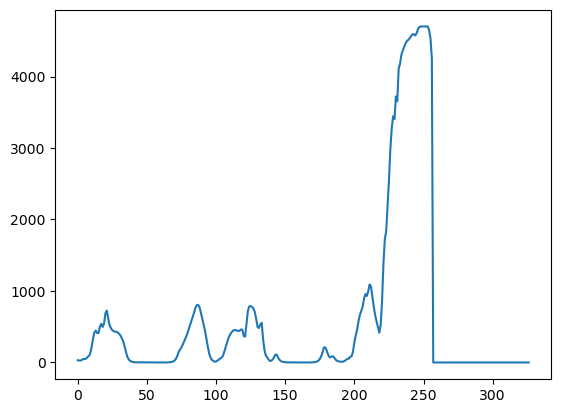

In [43]:
plt.plot(h_merid_transect)
# plt.ylim(0,3000)

In [44]:
temp_merid_transect.shape, Hz_merid_transect.shape, lat_31lev.shape

((1, 31, 206), (1, 31, 206), (31, 206))

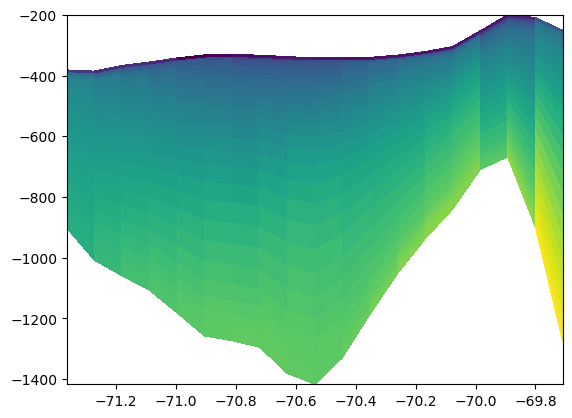

In [45]:
plt.pcolor(ma.masked_where(np.isnan(temp_merid_transect[0,:,:]),lat_31lev),Hz_merid_transect[0,:,:],temp_merid_transect[0,:,:])

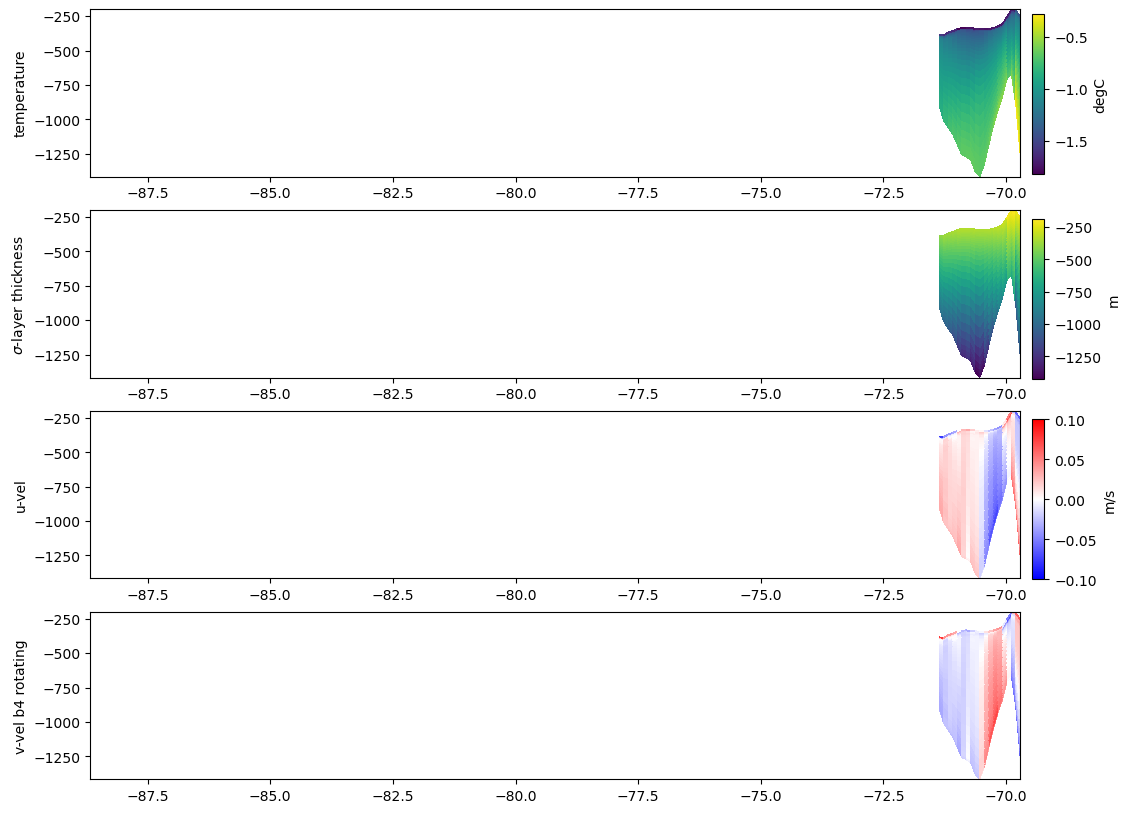

In [51]:
fig, ax = plt.subplots(nrows=4,figsize = (12, 10))

ct=ax[0].pcolor(lat_31lev,Hz_merid_transect[0,:,:],temp_merid_transect[0,:,:])
cbar_ax0= fig.add_axes([0.91, 0.715,  0.01, 0.16])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)
ax[0].set_ylabel('temperature')

cH=ax[1].pcolor(lat_31lev,Hz_merid_transect[0,:,:],Hz_merid_transect[0,:,:])
cbar_ax1= fig.add_axes([0.91, 0.51,  0.01, 0.16])
fig.colorbar(cH, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('m')#, labelpad=-35)
ax[1].set_ylabel('$\sigma$-layer thickness')

cv=ax[2].pcolor(lat_31lev,Hz_merid_transect[0,:,:],V_zonal[0,:,:], vmin=-0.1, vmax=0.1, cmap='bwr')
# cv=ax[2].pcolor(lat_31lev,Hz_merid_transect[0,:,:],u_merid_transect[0,:,:], vmin=-0.1, vmax=0.1, cmap='bwr')
ax[2].set_ylabel('u-vel')
cbar_ax2= fig.add_axes([0.91, 0.31,  0.01, 0.16])
fig.colorbar(cv, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('m/s')#, labelpad=-35)

cv=ax[3].pcolor(lat_31lev,Hz_merid_transect[0,:,:],u_merid_transect[0,:,:], vmin=-0.1, vmax=0.1, cmap='bwr')
ax[3].set_ylabel('v-vel b4 rotating')

## calculate heat transport
heat_transp_transect = V_zonal[0,:,:]*(temp_merid_transect[0,:,:]-Tf)*-Hz_merid_transect[0,:,:]*10000*rho0*Cp # 10k = dxt/dyt approximately
# cht=ax[3].pcolor(lat_31lev,Hz_merid_transect[0,:,:],heat_transp_transect*1e-12, cmap='bwr', vmin=-2, vmax=2)
# ax[3].set_ylabel('heat transport')
# cbar_ax3= fig.add_axes([0.91, 0.12,  0.01, 0.16])
# fig.colorbar(cht, cax=cbar_ax3, orientation='vertical')
# cbar_ax3.set_ylabel('TW')#, labelpad=-35)



In [57]:
dx

<xarray.Dataset> Size: 12MB
Dimensions:       (ocean_time: 365, s_rho: 31, transect_lat: 131)
Coordinates:
  * ocean_time    (ocean_time) float64 3kB 0.0 0.03288 0.06575 ... 11.93 11.97
  * s_rho         (s_rho) int64 248B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
  * transect_lat  (transect_lat) int64 1kB 0 1 2 3 4 5 ... 126 127 128 129 130
Data variables:
    u_zonal       (ocean_time, s_rho, transect_lat) float64 12MB dask.array<chunksize=(365, 31, 131), meta=np.ndarray>

Text(0, 0.5, 'TW')

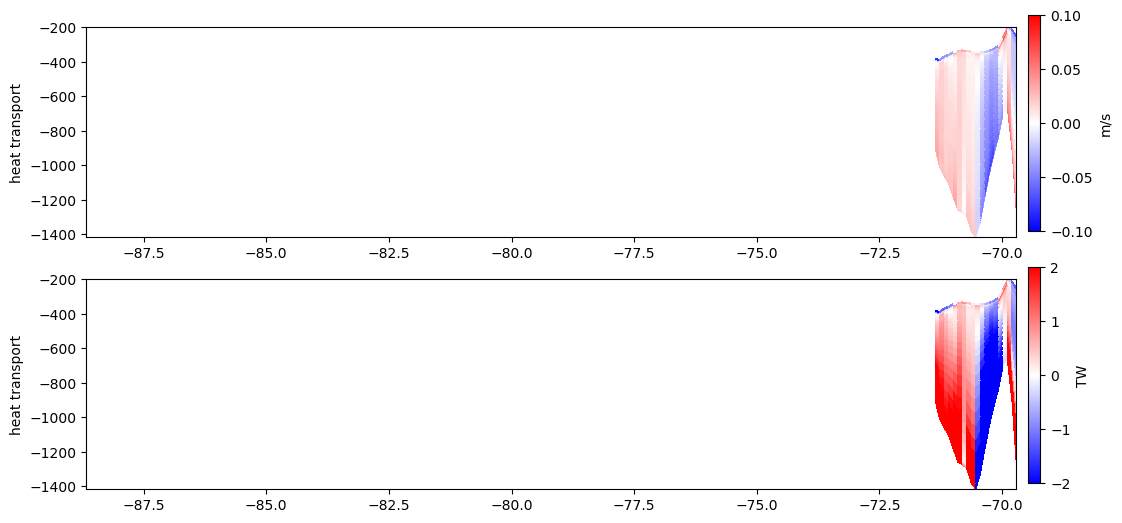

In [62]:
fig, ax = plt.subplots(nrows=2,figsize = (12, 6))

## calculo heat transport
cv=ax[0].pcolor(lat_31lev,Hz_merid_transect[0,:,:],V_zonal[0,:,:], vmin=-0.1, vmax=0.1, cmap='bwr')
ax[0].set_ylabel('heat transport')
cbar_ax1= fig.add_axes([0.91, 0.54,  0.01, 0.36])
fig.colorbar(cv, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('m/s')#, labelpad=-35)

cht=ax[1].pcolor(lat_31lev,Hz_merid_transect[0,:,:],heat_transp_transect*1e-12, cmap='bwr', vmin=-2, vmax=2)
ax[1].set_ylabel('heat transport')
cbar_ax1= fig.add_axes([0.91, 0.12,  0.01, 0.36])
fig.colorbar(cht, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('TW')#, labelpad=-35)

(-77.0, -60.0)

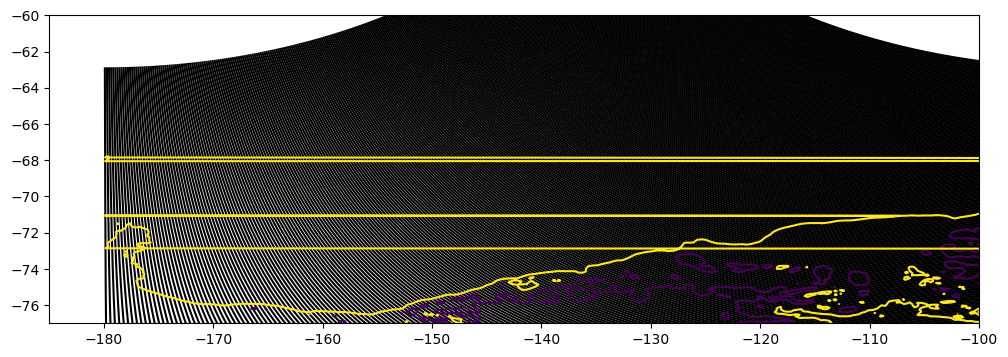

In [63]:
## Vizualise the grids:

fig, ax = plt.subplots(figsize = (12, 4))

plt.plot(lon_rho_10km, lat_rho_10km,'-k')
plt.plot(lon_mesh,lat_mesh,'or')
plt.contour(lon_rho_10km, lat_rho_10km,h_10km,levels=(200,1000),color='brown')

plt.xlim(-185,-100)
plt.ylim(-77,-60)

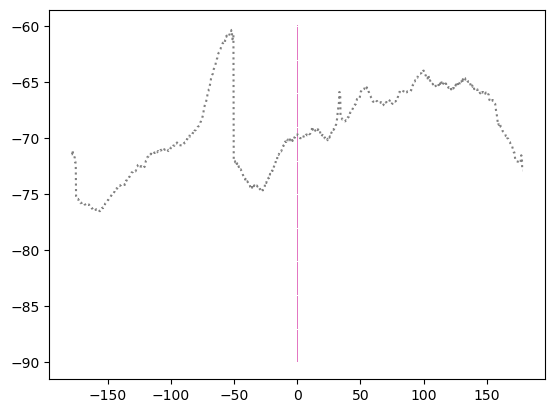

In [66]:
plt.plot(lon_mesh,lat_mesh,',')
plt.plot(lon_bin_midpoints,lat_bin_midpoints,':')

In [67]:
print(z_rho3d_10km.shape, lon_rho_10km.shape, lat_rho_10km.shape)

(365, 560, 630, 31) (560, 630) (560, 630)


#### Calving Front

In [36]:
%time
# WAOM10

Tf_heat_transp_10km_CF = Tf*vol_transport_10km_CF.mean('ocean_time')

heat_transp_10km_CF = heat_transport_10km_CF - Tf_heat_transp_10km_CF

# Total HT (online diag) annual-avg:
# annual_transp_10km_CF = heat_transport_10km_CF.mean('ocean_time') - Tf_heat_transp_10km_CF # annual vT x Cp x Rho0
annual_transp_10km_CF = heat_transp_10km_CF.mean('ocean_time')

# calculate Mean as v_bar*T_bar, vert-discretised version:
Mean_transp_10km_CF = vol_transport_10km_CF.mean('ocean_time')*(temp_10km_CF.mean('ocean_time')-Tf) 

# Eddy heat transport: total - Mean
Eddy_transp_10km_CF = np.empty((365,31,3298)) 
for mm in np.arange(0,365):
    Eddy_transp_10km_CF[mm,:,:] = (heat_transp_10km_CF[mm,:,:]) - Mean_transp_10km_CF #- Tf_heat_transp_10km_CF




CPU times: user 2 µs, sys: 7 µs, total: 9 µs
Wall time: 19.8 µs


In [37]:
%time
# WAOM4

Tf_heat_transp_4km_CF = Tf*vol_transport_4km_CF.mean('ocean_time')

heat_transp_4km_CF = heat_transport_4km_CF - Tf_heat_transp_4km_CF

# Total HT (online diag) annual-avg:
# annual_transp_4km_CF = heat_transport_4km_CF.mean('ocean_time') - Tf_heat_transp_4km_CF # annual vT x Cp x Rho0
annual_transp_4km_CF = heat_transp_4km_CF.mean('ocean_time')

# calculate Mean as v_bar*T_bar, vert-discretised version:
Mean_transp_4km_CF = vol_transport_4km_CF.mean('ocean_time')*(temp_4km_CF.mean('ocean_time')-Tf) 

# Eddy heat transport: total - Mean
Eddy_transp_4km_CF = np.empty((365,31,9018)) 
for mm in np.arange(0,365):
    # Eddy_transp_4km_CF[mm,:,:] = (heat_transport_4km_CF[mm,:,:]) - Mean_transp_4km_CF
    Eddy_transp_4km_CF[mm,:,:] = (heat_transp_4km_CF[mm,:,:]) - Mean_transp_4km_CF #- Tf_heat_transp_4km_CF




CPU times: user 1e+03 ns, sys: 4 µs, total: 5 µs
Wall time: 26 µs


In [38]:
%time
# WAOM4-NT

Tf_heat_transp_4kmNT_CF = Tf*vol_transport_4kmNT_CF.mean('ocean_time')

heat_transp_4kmNT_CF = heat_transport_4kmNT_CF - Tf_heat_transp_4kmNT_CF

# Total HT (online diag) annual-avg:
# annual_transp_4kmNT_CF = heat_transport_4kmNT_CF.mean('ocean_time') - Tf_heat_transp_4kmNT_CF # annual vT x Cp x Rho0
annual_transp_4kmNT_CF = heat_transp_4kmNT_CF.mean('ocean_time')

# calculate Mean as v_bar*T_bar, vert-discretised version:
Mean_transp_4kmNT_CF = vol_transport_4kmNT_CF.mean('ocean_time')*(temp_4kmNT_CF.mean('ocean_time')-Tf) 

# Eddy heat transport: total - Mean
Eddy_transp_4kmNT_CF = np.empty((365,31,9018)) 
for mm in np.arange(0,365):
    # Eddy_transp_4kmNT_CF[mm,:,:] = (heat_transport_4kmNT_CF[mm,:,:]) - Mean_transp_4kmNT_CF
    Eddy_transp_4kmNT_CF[mm,:,:] = (heat_transp_4kmNT_CF[mm,:,:]) - Mean_transp_4kmNT_CF #- Tf_heat_transp_4kmNT_CF




CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 12.2 µs


### do some plots

##### plots cumsum for checking:

Text(0, 0.5, 'Volume transport (m s$^{-1}$)')

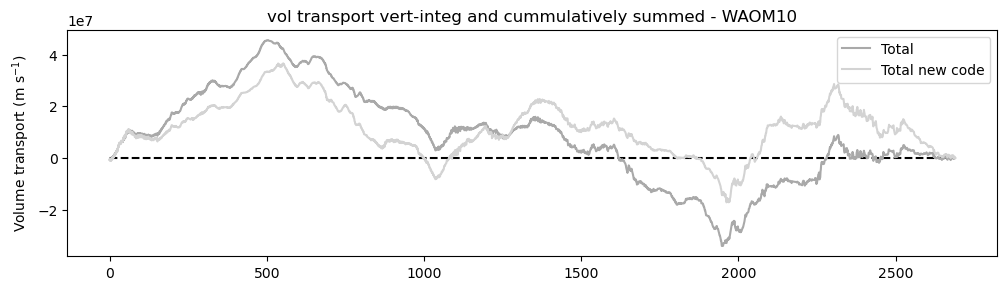

In [180]:

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(311)
cumsum_total = np.cumsum((vol_transport_10km).sum('s_rho').mean('ocean_time'),axis=-1)
cumsum_total_NC = np.cumsum((vol_transport_10kmNC).sum('s_rho').mean('ocean_time'),axis=-1)
ax1.plot(cumsum_total*0,'--k')
ax1.plot(cumsum_total,'-',color='darkgray',label='Total')
ax1.plot(cumsum_total_NC,'-',color='lightgray',label='Total new code')

ax1.legend()
ax1.set_title('vol transport vert-integ and cummulatively summed - WAOM10')
# ax1.set_ylim(-1000,1000)
ax1.set_ylabel('Volume transport (m s$^{-1}$)')


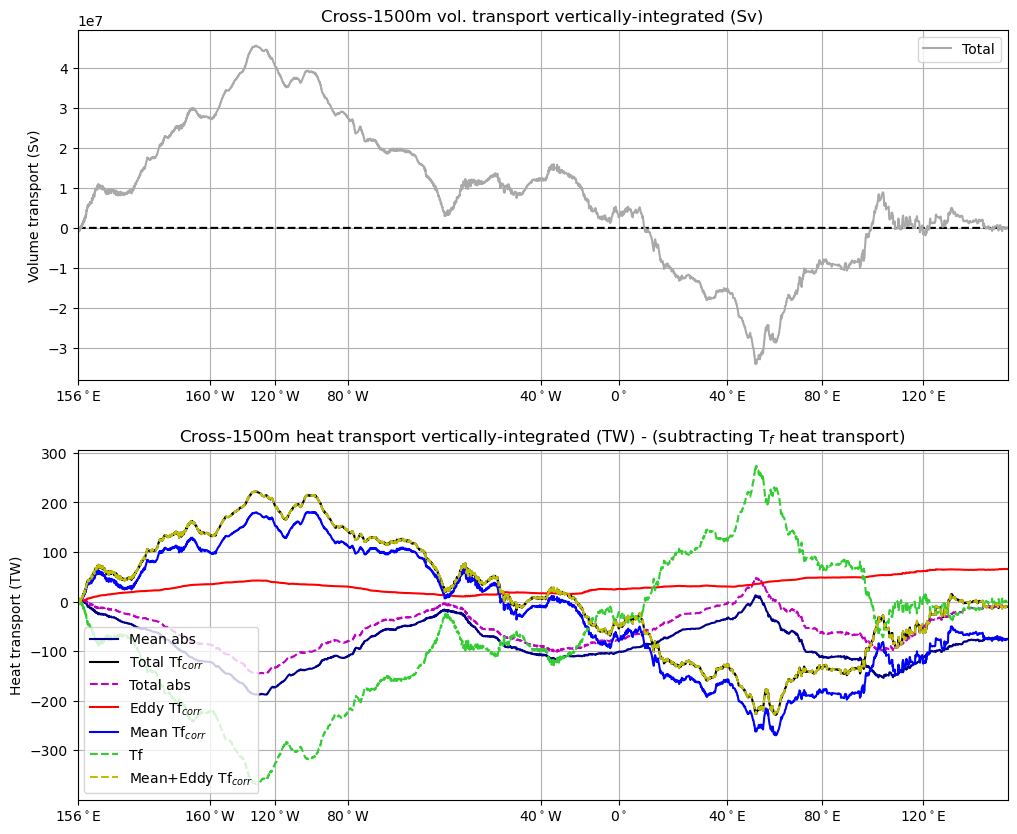

In [182]:

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(211)
cumsum_total = np.cumsum((vol_transport_10km).sum('s_rho').mean('ocean_time'),axis=-1)
ax1.plot(dist_along_10km[:],cumsum_total*0,'--k')
ax1.plot(dist_along_10km[:],cumsum_total,'-',color='darkgray',label='Total')
ax1.legend()
ax1.set_title('vol transport vert-integ and cummulatively summed - WAOM10')
# ax1.set_ylim(-1000,1000)
ax1.set_ylabel('Volume transport (m s$^{-1}$)')
ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1.set_title('Cross-1500m vol. transport vertically-integrated (Sv)')
ax1.set_ylabel('Volume transport (Sv)')
ax1.grid('on')

ax1 = fig.add_subplot(212)
cumsum_total_noTf = np.cumsum((heat_transport_10km).sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12 
cumsum_total = np.cumsum(np.nanmean(np.nansum(heat_transp_10km, axis=1), axis=0),axis=-1)*1e-12 
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*1e-12 
cumsum_mean = np.cumsum((Mean_transp_10km).sum('s_rho'),axis=-1)*1e-12 
cumsum_Tf = np.cumsum(np.nanmean(Tf_heat_transp_10km.sum('s_rho'),axis=0), axis=-1)*1e-12
# ax1.plot(dist_along_10km[:],cumsum_total*0,'--k')
# ax1.plot(dist_along_10km[:],cumsum_eddy+cumsum_Tf,'-',color='darkred',label='eddy abs')
ax1.plot(dist_along_10km[:],cumsum_mean+cumsum_Tf,'-',color='darkblue',label='Mean abs')
ax1.plot(dist_along_10km[:],cumsum_total,'-k',label='Total Tf$_{corr}$')
ax1.plot(dist_along_10km[:],cumsum_total_noTf,'--m',label='Total abs')
ax1.plot(dist_along_10km[:],cumsum_eddy,'-r',label='Eddy Tf$_{corr}$')
ax1.plot(dist_along_10km[:],cumsum_mean,'-b',label='Mean Tf$_{corr}$')
ax1.plot(dist_along_10km[:],cumsum_Tf,'--',color='limegreen',label='Tf')
ax1.plot(dist_along_10km[:],(cumsum_mean+cumsum_eddy),'--y',label='Mean+Eddy Tf$_{corr}$')

ax1.legend(loc='lower left')
ax1.set_title('heat transport cum. summed - WAOM10')
# ax1.set_ylim(-1000,1000)
ax1.set_ylabel('Heat transport (TW)')
ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1.set_title('Cross-1500m heat transport vertically-integrated (TW) - (subtracting T$_f$ heat transport)')
ax1.set_ylabel('Heat transport (TW)')
ax1.grid('on')
# ax2 = fig.add_subplot(313)
# cumsum_total = np.cumsum((annual_transp_4km).sum('s_rho'),axis=-1)*1e-12 
# cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*1e-12 
# cumsum_mean = np.cumsum((Mean_transp_4km).sum('s_rho'),axis=-1)*1e-12 
# cumsum_Tf = np.cumsum(Tf_heat_transp_4km.sum('s_rho'), axis=-1)*1e-12
# ax2.plot(dist_along_4km[:],cumsum_total*0,'--k')
# # ax2.plot(dist_along_4km[:],cumsum_total,'-y',label='Total')
# ax2.plot(dist_along_4km[:],cumsum_eddy,'-g',label='Eddy')
# ax2.plot(dist_along_4km[:],cumsum_mean,'-r',label='Mean')
# # ax2.plot((cumsum_mean+cumsum_eddy),'--',label='Mean+Eddy')
# ax2.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
# ax2.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
# ax2.set_xlim(0, dist_along_4km[-1])

# ax2.set_title('Cross-1500m heat transport vertically-integrated (TW) - (subtracting T$_f$ heat transport)')
# ax2.set_ylabel('Heat transport (TW)')
# cumsum_total = np.cumsum((annual_transp_4kmNT).sum('s_rho'),axis=-1)*1e-12 
# cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4kmNT, axis=1),axis=0),axis=-1)*1e-12 
# cumsum_mean = np.cumsum((Mean_transp_4kmNT).sum('s_rho'),axis=-1)*1e-12 
# cumsum_Tf = np.cumsum(Tf_heat_transp_4kmNT.sum('s_rho'), axis=-1)*1e-12
# # ax2.plot(dist_along_4km[:],cumsum_total,'--y',label='Total 4NT', linewidth=0.5)
# ax2.plot(dist_along_4km[:],cumsum_eddy,'--g',label='Eddy 4NT', linewidth=0.5)
# ax2.plot(dist_along_4km[:],cumsum_mean,'--r',label='Mean 4NT', linewidth=0.5)
# # ax2.plot(dist_along_4km[:],(cumsum_mean+cumsum_eddy),'--',label='Net 4NT')
# ax2.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
# ax2.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
# ax2.set_xlim(0, dist_along_4km[-1])

# ax2.set_title('Cross-1500m heat transport vertically-integrated (TW) - (subtracting T$_f$ heat transport)')
# ax2.set_ylabel('Heat transport (TW)')
# ax2.legend()
# ax2.set_title('heat transport cum. summed - WAOM4')
# # ax2.set_ylim(-1000,1000)
# ax2.set_ylabel('Heat transport (TW)')



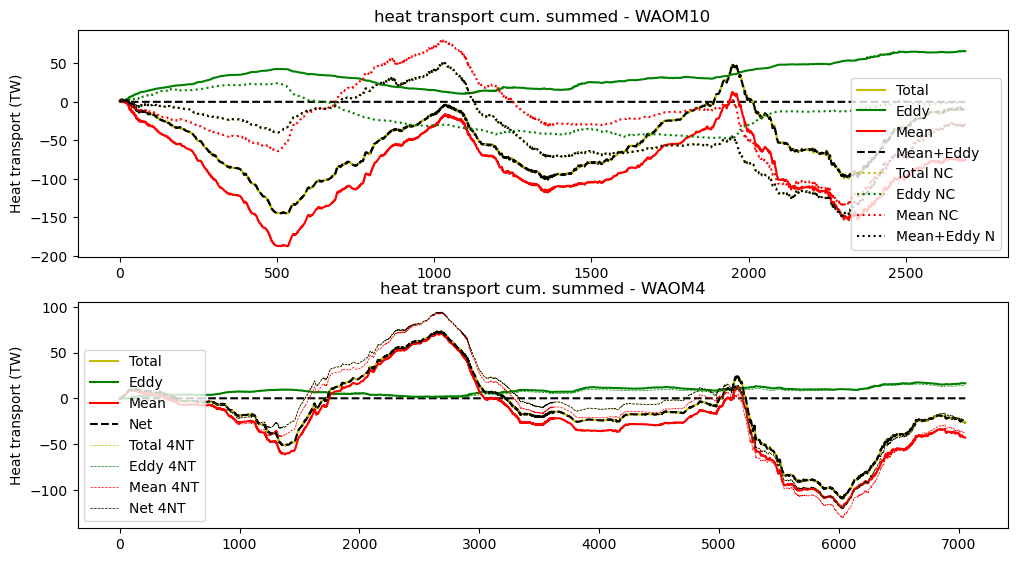

In [186]:
# WITHOUT SUBTRACTING TF

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(311)
cumsum_Tf = np.cumsum(np.nanmean(Tf_heat_transp_10km.sum('s_rho'),axis=0),axis=-1)*1e-12
cumsum_total = np.cumsum(np.nanmean(np.nansum(heat_transp_10km, axis=1), axis=0),axis=-1)*1e-12 
cumsum_eddy = np.cumsum(np.nanmean(np.sum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*1e-12
cumsum_mean = np.cumsum(Mean_transp_10km.sum('s_rho'),axis=-1)*1e-12

cumsum_Tf_NC = np.cumsum(np.nanmean(Tf_heat_transp_10kmNC.sum('s_rho'),axis=0),axis=-1)*1e-12
cumsum_total_NC = np.cumsum(heat_transp_10kmNC.sum('s_rho').mean('ocean_time'),axis=-1)*1e-12
cumsum_eddy_NC = np.cumsum(np.nanmean(np.sum(Eddy_transp_10kmNC, axis=1),axis=0),axis=-1)*1e-12
cumsum_mean_NC = np.cumsum(Mean_transp_10kmNC.sum('s_rho'),axis=-1)*1e-12

# cum sum 1500m
ax1.plot(cumsum_total*0,'--k')
ax1.plot(cumsum_total+cumsum_Tf,'-y',label='Total')
ax1.plot(cumsum_eddy,'-g',label='Eddy')
ax1.plot(cumsum_mean+cumsum_Tf,'-r',label='Mean')
ax1.plot((cumsum_mean+cumsum_Tf+cumsum_eddy),'--k',label='Mean+Eddy')

ax1.plot(cumsum_total_NC+cumsum_Tf_NC,':y',label='Total NC')
ax1.plot(cumsum_eddy_NC,':g',label='Eddy NC')
ax1.plot(cumsum_mean_NC+cumsum_Tf_NC,':r',label='Mean NC')
ax1.plot((cumsum_mean_NC+cumsum_Tf_NC+cumsum_eddy_NC),':k',label='Mean+Eddy N')
ax1.legend()
ax1.set_title('heat transport cum. summed - WAOM10')
# ax1.set_ylim(-5e12,5e12)
ax1.set_ylabel('Heat transport (TW)')

ax2 = fig.add_subplot(312)
cumsum_Tf = np.cumsum(Tf_heat_transp_4km.sum('s_rho').mean('ocean_time'),axis=-1)*1e-12
cumsum_total = np.cumsum(heat_transp_4km.sum('s_rho').mean('ocean_time'),axis=-1)*1e-12
cumsum_eddy = np.cumsum(np.nanmean(np.sum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*1e-12
cumsum_mean = np.cumsum(Mean_transp_4km.sum('s_rho'),axis=-1)*1e-12
# cum sum 1500m
ax2.plot(cumsum_total*0,'--k')
ax2.plot(cumsum_total+cumsum_Tf,'-y',label='Total')
ax2.plot(cumsum_eddy,'-g',label='Eddy')
ax2.plot(cumsum_mean+cumsum_Tf,'-r',label='Mean')
ax2.plot((cumsum_mean+cumsum_Tf+cumsum_eddy),'--k',label='Net')
ax2.legend()
ax2.set_title('heat transport cum. summed - WAOM4')
# ax2.set_ylim(-5e12,5e12)
ax2.set_ylabel('Heat transport (TW)')

# ax3 = fig.add_subplot(313)
cumsum_Tf = np.cumsum(Tf_heat_transp_4kmNT.sum('s_rho').mean('ocean_time'),axis=-1)*1e-12
cumsum_total = np.cumsum(heat_transp_4kmNT.sum('s_rho').mean('ocean_time'),axis=-1)*1e-12
cumsum_eddy = np.cumsum(np.nanmean(np.sum(Eddy_transp_4kmNT, axis=1),axis=0),axis=-1)*1e-12
cumsum_mean = np.cumsum(Mean_transp_4kmNT.sum('s_rho'),axis=-1)*1e-12
# cum sum 1500m
# ax2.plot(cumsum_total*0,'--k')
ax2.plot(cumsum_total+cumsum_Tf,'--y',label='Total 4NT', linewidth=0.5)
ax2.plot(cumsum_eddy,'--g',label='Eddy 4NT', linewidth=0.5)
ax2.plot(cumsum_mean+cumsum_Tf,'--r',label='Mean 4NT', linewidth=0.5)
ax2.plot((cumsum_mean++cumsum_Tf+cumsum_eddy),'--k',label='Net 4NT', linewidth=0.5)
# locs='upper right', bbox_to_anchor=(0.5, 0.5)
ax2.legend(loc='lower left')
# ax3.set_title('heat transport cum. summed - WAOM4-NOTIDE')
# ax3.set_ylim(-5e12,5e12)
# ax3.set_ylabel('Heat transport (TW)')


In [42]:
print('WAOM10')
# Print values integrated circumpolar to close the budget (comparing with: WAOM10extend_shflim_S_0.25Q_OHB_shelf_budget_closure.ipynb)
print('Sum Total HT = ', np.sum(heat_transport_10km.sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12)
print('Sum Eddy HT = ', np.sum(np.nanmean(np.sum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12)
print('Sum Mean HT = ', np.sum(Mean_transp_10km.sum('s_rho'),axis=-1)*rho0*Cp*1e-12)

WAOM10
Sum Total HT =  <xarray.Variable ()> Size: 8B
array(-9.52425944)
Sum Eddy HT =  65.07774937401828
Sum Mean HT =  <xarray.Variable ()> Size: 8B
array(-74.6005311)


In [43]:
print('WAOM10 new code')
# Print values integrated circumpolar to close the budget (comparing with: WAOM10extend_shflim_S_0.25Q_OHB_shelf_budget_closure.ipynb)
print('Sum Total HT = ', np.sum(heat_transport_10kmNC.sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12)
print('Sum Eddy HT = ', np.sum(np.nanmean(np.sum(Eddy_transp_10kmNC, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12)
print('Sum Mean HT = ', np.sum(Mean_transp_10kmNC.sum('s_rho'),axis=-1)*rho0*Cp*1e-12)

WAOM10 new code
Sum Total HT =  <xarray.Variable ()> Size: 8B
array(-29.54684962)
Sum Eddy HT =  0.02491835969141768
Sum Mean HT =  <xarray.Variable ()> Size: 8B
array(-29.57858651)


In [44]:
print('WAOM4')
# Print values integrated circumpolar to close the budget (comparing with: WAOM10extend_shflim_S_0.25Q_OHB_shelf_budget_closure.ipynb)
print('Sum Total HT = ', np.sum(heat_transport_4km.sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12)
print('Sum Eddy HT = ', np.sum(np.nanmean(np.sum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12)
print('Sum Mean HT = ', np.sum(Mean_transp_4km.sum('s_rho'),axis=-1)*rho0*Cp*1e-12)

WAOM4
Sum Total HT =  <xarray.Variable ()> Size: 8B
array(-26.30456949)
Sum Eddy HT =  16.213692581822123
Sum Mean HT =  <xarray.Variable ()> Size: 8B
array(-42.45441162)


In [45]:
print('WAOM4-NOTIDE')
# Print values integrated circumpolar to close the budget (comparing with: WAOM10extend_shflim_S_0.25Q_OHB_shelf_budget_closure.ipynb)
print('Sum Total HT = ', np.sum(heat_transport_4kmNT.sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12)
print('Sum Eddy HT = ', np.sum(np.nanmean(np.sum(Eddy_transp_4kmNT, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12)
print('Sum Mean HT = ', np.sum(Mean_transp_4kmNT.sum('s_rho'),axis=-1)*rho0*Cp*1e-12)

WAOM4-NOTIDE
Sum Total HT =  <xarray.Variable ()> Size: 8B
array(-23.97847713)
Sum Eddy HT =  13.836967798045738
Sum Mean HT =  <xarray.Variable ()> Size: 8B
array(-37.7966257)


Calving front

Text(0, 0.5, 'Heat transport (TW)')

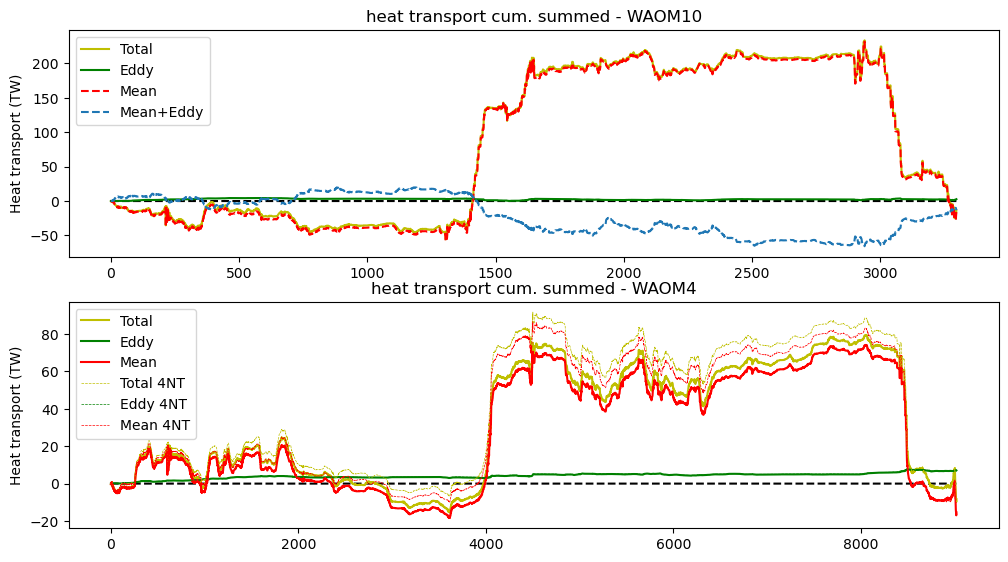

In [46]:
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(311)
cumsum_total = np.cumsum((annual_transp_10km_CF).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km_CF, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12 
cumsum_mean = np.cumsum((Mean_transp_10km_CF).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_Tf = np.cumsum(Tf_heat_transp_10km_CF.sum('s_rho'), axis=-1)*rho0*Cp*1e-12
ax1.plot(cumsum_total*0,'--k')
ax1.plot(cumsum_total,'-y',label='Total')
ax1.plot(cumsum_eddy,'-g',label='Eddy')
ax1.plot(cumsum_mean,'--r',label='Mean')
ax1.plot((cumsum_mean+cumsum_eddy)+cumsum_Tf,'--',label='Mean+Eddy')
ax1.legend()
ax1.set_title('heat transport cum. summed - WAOM10')
# ax1.set_ylim(-1000,1000)
ax1.set_ylabel('Heat transport (TW)')

ax2 = fig.add_subplot(312)
cumsum_total = np.cumsum((annual_transp_4km_CF).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4km_CF, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12 
cumsum_mean = np.cumsum((Mean_transp_4km_CF).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_Tf = np.cumsum(Tf_heat_transp_4km_CF.sum('s_rho'), axis=-1)*rho0*Cp*1e-12
ax2.plot(cumsum_total*0,'--k')
ax2.plot(cumsum_total,'-y',label='Total')
ax2.plot(cumsum_eddy,'-g',label='Eddy')
ax2.plot(cumsum_mean,'-r',label='Mean')
# ax2.plot((cumsum_mean+cumsum_eddy),'--',label='Mean+Eddy')

cumsum_total = np.cumsum((annual_transp_4kmNT_CF).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4kmNT_CF, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12 
cumsum_mean = np.cumsum((Mean_transp_4kmNT_CF).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_Tf = np.cumsum(Tf_heat_transp_4kmNT_CF.sum('s_rho'), axis=-1)*rho0*Cp*1e-12
ax2.plot(cumsum_total,'--y',label='Total 4NT', linewidth=0.5)
ax2.plot(cumsum_eddy,'--g',label='Eddy 4NT', linewidth=0.5)
ax2.plot(cumsum_mean,'--r',label='Mean 4NT', linewidth=0.5)
# ax2.plot((cumsum_mean+cumsum_eddy),'--',label='Net 4NT')

ax2.legend()
ax2.set_title('heat transport cum. summed - WAOM4')
# ax2.set_ylim(-1000,1000)
ax2.set_ylabel('Heat transport (TW)')
# ax2.set_xlim(0,2000)

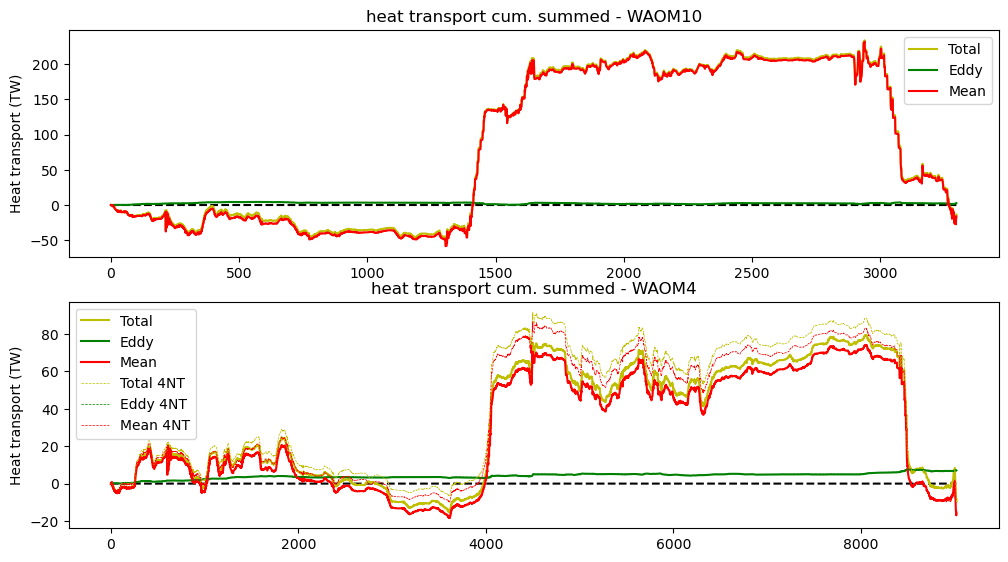

In [47]:
# WITHOUT SUBTRACTING TF

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(311)
cumsum_Tf = np.cumsum(Tf_heat_transp_10km_CF.sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_total = np.cumsum(heat_transp_10km_CF.sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km_CF, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12 
cumsum_mean = np.cumsum(Mean_transp_10km_CF.sum('s_rho'),axis=-1)*rho0*Cp*1e-12
# cum sum 1500m
ax1.plot(cumsum_total*0,'--k')
ax1.plot(cumsum_total,'-y',label='Total')
ax1.plot(cumsum_eddy,'-g',label='Eddy')
ax1.plot(cumsum_mean,'-r',label='Mean')
# ax1.plot((cumsum_mean+cumsum_eddy),'--',label='Mean+Eddy')
ax1.legend()
ax1.set_title('heat transport cum. summed - WAOM10')
# ax1.set_ylim(-1,8)
ax1.set_ylabel('Heat transport (TW)')

ax2 = fig.add_subplot(312)
cumsum_total = np.cumsum(heat_transp_4km_CF.sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4km_CF, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12 

cumsum_mean = np.cumsum(Mean_transp_4km_CF.sum('s_rho'),axis=-1)*rho0*Cp*1e-12
# cum sum 1500m
ax2.plot(cumsum_total*0,'--k')
ax2.plot(cumsum_total,'-y',label='Total')
ax2.plot(cumsum_eddy,'-g',label='Eddy')
ax2.plot(cumsum_mean,'-r',label='Mean')
# ax2.plot((cumsum_mean+cumsum_eddy),'--',label='Net')
ax2.legend()
ax2.set_title('heat transport cum. summed - WAOM4')
# ax2.set_ylim(-1,8)
ax2.set_ylabel('Heat transport (TW)')

# ax3 = fig.add_subplot(313)
cumsum_total = np.cumsum(heat_transp_4kmNT_CF.sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4kmNT_CF, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12 
cumsum_mean = np.cumsum(Mean_transp_4kmNT_CF.sum('s_rho'),axis=-1)*rho0*Cp*1e-12
# cum sum 1500m
# ax3.plot(cumsum_total*0,'--k')
ax2.plot(cumsum_total,'--y',label='Total 4NT', linewidth=0.5)
ax2.plot(cumsum_eddy,'--g',label='Eddy 4NT', linewidth=0.5)
ax2.plot(cumsum_mean,'--r',label='Mean 4NT', linewidth=0.5)
# ax2.plot((cumsum_mean+cumsum_eddy),'--',label='Net 4NT', linewidth=0.5)
ax2.legend()
# ax3.set_title('heat transport cum. summed - WAOM4-NOTIDE')
# ax3.set_ylim(-5e12,5e12)
# ax3.set_ylabel('Heat transport (TW)')


### Binning in density: calculate net heat transport (Abs - Tf) across contour per density bin in $\sigma_2$

##### if not run before, run to calculate and save mean and eddy componentes of the CSHT:

###### run and save tmp files for 1500m isobath

In [53]:
%%time

# WAOM10

# Eddy_transp_10km
# Mean_transp_10km


Mean_HT_10km_irho2 = np.empty((len(heat_transport_10km[:,0,0]),len_rho_grid2,len(heat_transport_10km[0,:,0]),len(heat_transport_10km[0,0,:])))
Eddy_HT_10km_irho2 = np.empty((len(heat_transport_10km[:,0,0]),len_rho_grid2,len(heat_transport_10km[0,:,0]),len(heat_transport_10km[0,0,:])))

for tt in np.arange(0,len(heat_transport_10km[:,0,0])):

    for zz in np.arange(0,31):
        sigma_tmp = sigma_2_10km[tt,zz,:]
    
        # print(zz)
        for irho in np.arange(0,len_rho_grid2):

            mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), heat_transp_10km[tt,zz,:])
            eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_10km[tt,zz,:])
          
            if irho == 0:
                eddy_HT_delta = eddy_HT_tmp.copy()
                eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = mean_HT_tmp.copy()
                mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan

            elif irho == 1:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
                
            else:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
                eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
                mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
        
            # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
            del mean_HT_tmp
            del eddy_HT_tmp
    
        Mean_HT_10km_irho2[tt,:,zz,:] = mean_HT_delta
        Eddy_HT_10km_irho2[tt,:,zz,:] = eddy_HT_delta


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1499ca8c5cf0>>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
Process Dask Worker process (from Nanny):
2024-05-26 21:00:10,131 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-05-26 21:00:10,131 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-05-26 21:00:10,131 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-05-26 21:00:10,131 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2024-05-26 21:00:10,132 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-05-26 21:00:10,

KeyboardInterrupt: 

In [54]:
%%time

# WAOM4

# Eddy_transp_4km
# Mean_transp_4km


Mean_HT_4km_irho2 = np.empty((len(heat_transport_4km[:,0,0]),len_rho_grid2,len(heat_transport_4km[0,:,0]),len(heat_transport_4km[0,0,:])))
Eddy_HT_4km_irho2 = np.empty((len(heat_transport_4km[:,0,0]),len_rho_grid2,len(heat_transport_4km[0,:,0]),len(heat_transport_4km[0,0,:])))

for tt in np.arange(0,len(heat_transport_4km[:,0,0])):

    for zz in np.arange(0,31):
        sigma_tmp = sigma_2_4km[tt,zz,:]
    
        # print(zz)
        for irho in np.arange(0,len_rho_grid2):

            mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), heat_transp_4km[tt,zz,:])
            eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_4km[tt,zz,:])
          
            if irho == 0:
                eddy_HT_delta = eddy_HT_tmp.copy()
                eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = mean_HT_tmp.copy()
                mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan

            elif irho == 1:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
                
            else:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
                eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
                mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
        
            # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
            del mean_HT_tmp
            del eddy_HT_tmp
    
        Mean_HT_4km_irho2[tt,:,zz,:] = mean_HT_delta
        Eddy_HT_4km_irho2[tt,:,zz,:] = eddy_HT_delta


KeyboardInterrupt: 

In [ ]:
%%time

# WAOM4-NOTIDE

# Eddy_transp_4kmNT
# Mean_transp_4kmNT


Mean_HT_4kmNT_irho2 = np.empty((len(heat_transport_4kmNT[:,0,0]),len_rho_grid2,len(heat_transport_4kmNT[0,:,0]),len(heat_transport_4kmNT[0,0,:])))
Eddy_HT_4kmNT_irho2 = np.empty((len(heat_transport_4kmNT[:,0,0]),len_rho_grid2,len(heat_transport_4kmNT[0,:,0]),len(heat_transport_4kmNT[0,0,:])))

for tt in np.arange(0,len(heat_transport_4kmNT[:,0,0])):

    for zz in np.arange(0,31):
        sigma_tmp = sigma_2_4kmNT[tt,zz,:]
    
        # print(zz)
        for irho in np.arange(0,len_rho_grid2):

            mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), heat_transp_4kmNT[tt,zz,:])
            eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_4kmNT[tt,zz,:])
          
            if irho == 0:
                eddy_HT_delta = eddy_HT_tmp.copy()
                eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = mean_HT_tmp.copy()
                mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan

            elif irho == 1:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
                
            else:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
                eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
                mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
        
            # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
            del mean_HT_tmp
            del eddy_HT_tmp
    
        Mean_HT_4kmNT_irho2[tt,:,zz,:] = mean_HT_delta
        Eddy_HT_4kmNT_irho2[tt,:,zz,:] = eddy_HT_delta


Save tmp files w/ Mean/Eddy_HT_10km/4km/4kmNT_irho2

In [ ]:
months=np.arange(0,365)*(1/30.41667)
months_flr = np.floor(months[:])

# save to netcdf file:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

## HEAT TRANSPORT:
coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
                    contour_index_array=(['contour_index_array'], np.arange(0,len(heat_transp_10km[0,0,:]))))
Mean_HT_10km_irho2_xr = xr.DataArray(Mean_HT_10km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
Eddy_HT_10km_irho2_xr = xr.DataArray(Eddy_HT_10km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


Mean_HT_10km_irho2_xr.to_netcdf(files_path + 'WAOM10_MeanHT_1500m_daily_v3', mode='w', format="NETCDF4")
Eddy_HT_10km_irho2_xr.to_netcdf(files_path + 'WAOM10_EddyHT_1500m_daily_v3', mode='w', format="NETCDF4")

coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
                    contour_index_array=(['contour_index_array'], np.arange(0,len(heat_transp_4km[0,0,:]))))
Mean_HT_4km_irho2_xr = xr.DataArray(Mean_HT_4km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
Eddy_HT_4km_irho2_xr = xr.DataArray(Eddy_HT_4km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


Mean_HT_4km_irho2_xr.to_netcdf(files_path + 'WAOM4_MeanHT_1500m_daily_v3', mode='w', format="NETCDF4")
Eddy_HT_4km_irho2_xr.to_netcdf(files_path + 'WAOM4_EddyHT_1500m_daily_v3', mode='w', format="NETCDF4")

coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
                    contour_index_array=(['contour_index_array'], np.arange(0,len(heat_transp_4kmNT[0,0,:]))))
Mean_HT_4kmNT_irho2_xr = xr.DataArray(Mean_HT_4kmNT_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
Eddy_HT_4kmNT_irho2_xr = xr.DataArray(Eddy_HT_4kmNT_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


Mean_HT_4kmNT_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_MeanHT_1500m_daily_v3', mode='w', format="NETCDF4")
Eddy_HT_4kmNT_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_EddyHT_1500m_daily_v3', mode='w', format="NETCDF4")

# ## VOLUME TRANSPORT:
# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(heat_transp_10km[0,0,:]))))
# Mean_VT_10km_irho2_xr = xr.DataArray(Mean_VT_10km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_VT_10km_irho2_xr = xr.DataArray(Eddy_VT_10km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


# Mean_VT_10km_irho2_xr.to_netcdf(files_path + 'WAOM10_MeanVT_1500m_daily_v3', mode='w', format="NETCDF4")
# Eddy_VT_10km_irho2_xr.to_netcdf(files_path + 'WAOM10_EddyVT_1500m_daily_v3', mode='w', format="NETCDF4")

# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(heat_transp_4km[0,0,:]))))
# Mean_VT_4km_irho2_xr = xr.DataArray(Mean_VT_4km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_VT_4km_irho2_xr = xr.DataArray(Eddy_VT_4km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])

# Mean_VT_4km_irho2_xr.to_netcdf(files_path + 'WAOM4_MeanVT_1500m_daily_v3', mode='w', format="NETCDF4")
# Eddy_VT_4km_irho2_xr.to_netcdf(files_path + 'WAOM4_EddyVT_1500m_daily_v3', mode='w', format="NETCDF4")

# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(heat_transp_4kmNT[0,0,:]))))
# Mean_VT_4kmNT_irho2_xr = xr.DataArray(Mean_VT_4kmNT_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_VT_4kmNT_irho2_xr = xr.DataArray(Eddy_VT_4kmNT_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])

# Mean_VT_4kmNT_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_MeanVT_1500m_daily_v3', mode='w', format="NETCDF4")
# Eddy_VT_4kmNT_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_EddyVT_1500m_daily_v3', mode='w', format="NETCDF4")

###### run and save tmp files but for Calving Front:

In [306]:
%%time

# WAOM10

# Eddy_transp_10km_CF
# Mean_transp_10km_CF


Mean_HT_10km_CF_irho2 = np.empty((len(heat_transp_10km_CF[:,0,0]),len_rho_grid2,len(heat_transp_10km_CF[0,:,0]),len(heat_transp_10km_CF[0,0,:])))
Eddy_HT_10km_CF_irho2 = np.empty((len(heat_transp_10km_CF[:,0,0]),len_rho_grid2,len(heat_transp_10km_CF[0,:,0]),len(heat_transp_10km_CF[0,0,:])))

for tt in np.arange(0,len(heat_transp_10km_CF[:,0,0])):

    for zz in np.arange(0,31):
        sigma_tmp = sigma_2_10km_CF[tt,zz,:]
    
        # print(zz)
        for irho in np.arange(0,len_rho_grid2):

            mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), heat_transp_10km_CF[tt,zz,:])
            eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_10km_CF[tt,zz,:])
        
            if irho == 0:
                eddy_HT_delta = eddy_HT_tmp.copy()
                eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = mean_HT_tmp.copy()
                mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
            elif irho == 1:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
            else:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
                eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
                mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
                
            # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
            del mean_HT_tmp
            del eddy_HT_tmp
            
        Mean_HT_10km_CF_irho2[tt,:,zz,:] = mean_HT_delta
        Eddy_HT_10km_CF_irho2[tt,:,zz,:] = eddy_HT_delta
        


CPU times: user 10min 42s, sys: 2min 33s, total: 13min 15s
Wall time: 12min 17s


In [ ]:
%%time

# WAOM4

# Eddy_transp_4km_CF
# Mean_transp_4km_CF


Mean_HT_4km_CF_irho2 = np.empty((len(heat_transp_4km_CF[:,0,0]),len_rho_grid2,len(heat_transp_4km_CF[0,:,0]),len(heat_transp_4km_CF[0,0,:])))
Eddy_HT_4km_CF_irho2 = np.empty((len(heat_transp_4km_CF[:,0,0]),len_rho_grid2,len(heat_transp_4km_CF[0,:,0]),len(heat_transp_4km_CF[0,0,:])))

for tt in np.arange(0,len(heat_transp_4km_CF[:,0,0])):

    for zz in np.arange(0,31):
        sigma_tmp = sigma_2_4km_CF[tt,zz,:]
    
        # print(zz)
        for irho in np.arange(0,len_rho_grid2):

            mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), heat_transp_4km_CF[tt,zz,:])
            eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_4km_CF[tt,zz,:])
        
            if irho == 0:
                eddy_HT_delta = eddy_HT_tmp.copy()
                eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = mean_HT_tmp.copy()
                mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
            elif irho == 1:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
            else:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
                eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
                mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
                
            # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
            del mean_HT_tmp
            del eddy_HT_tmp
            
        Mean_HT_4km_CF_irho2[tt,:,zz,:] = mean_HT_delta
        Eddy_HT_4km_CF_irho2[tt,:,zz,:] = eddy_HT_delta
        


In [ ]:
%%time

# WAOM4

# Eddy_transp_4kmNT_CF
# Mean_transp_4kmNT_CF


Mean_HT_4kmNT_CF_irho2 = np.empty((len(heat_transp_4kmNT_CF[:,0,0]),len_rho_grid2,len(heat_transp_4kmNT_CF[0,:,0]),len(heat_transp_4kmNT_CF[0,0,:])))
Eddy_HT_4kmNT_CF_irho2 = np.empty((len(heat_transp_4kmNT_CF[:,0,0]),len_rho_grid2,len(heat_transp_4kmNT_CF[0,:,0]),len(heat_transp_4kmNT_CF[0,0,:])))

for tt in np.arange(0,len(heat_transp_4kmNT_CF[:,0,0])):

    for zz in np.arange(0,31):
        sigma_tmp = sigma_2_4kmNT_CF[tt,zz,:]
    
        # print(zz)
        for irho in np.arange(0,len_rho_grid2):

            mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), heat_transp_4kmNT_CF[tt,zz,:])
            eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_4kmNT_CF[tt,zz,:])
        
            if irho == 0:
                eddy_HT_delta = eddy_HT_tmp.copy()
                eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = mean_HT_tmp.copy()
                mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
            elif irho == 1:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
            else:
                eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
                eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
                mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
                mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
                mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
                
            # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
            del mean_HT_tmp
            del eddy_HT_tmp
            
        Mean_HT_4kmNT_CF_irho2[tt,:,zz,:] = mean_HT_delta
        Eddy_HT_4kmNT_CF_irho2[tt,:,zz,:] = eddy_HT_delta
        


In [ ]:
# # save to netcdf file:

## HEAT TRANSPORT
coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
                    contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_10km_CF[0,0,:]))))
Mean_HT_10km_CF_irho2_xr = xr.DataArray(Mean_HT_10km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
Eddy_HT_10km_CF_irho2_xr = xr.DataArray(Eddy_HT_10km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
Mean_HT_10km_CF_irho2_xr.to_netcdf(files_path + 'WAOM10_MeanHT_CF_daily_v3', mode='w', format="NETCDF4")
Eddy_HT_10km_CF_irho2_xr.to_netcdf(files_path + 'WAOM10_EddyHT_CF_daily_v3', mode='w', format="NETCDF4")

coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
                    contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_4km_CF[0,0,:]))))
Mean_HT_4km_CF_irho2_xr = xr.DataArray(Mean_HT_4km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
Eddy_HT_4km_CF_irho2_xr = xr.DataArray(Eddy_HT_4km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


Mean_HT_4km_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_MeanHT_CF_daily_v3', mode='w', format="NETCDF4")
Eddy_HT_4km_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_EddyHT_CF_daily_v3', mode='w', format="NETCDF4")

coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
                    contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_4kmNT_CF[0,0,:]))))
Mean_HT_4kmNT_CF_irho2_xr = xr.DataArray(Mean_HT_4kmNT_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
Eddy_HT_4kmNT_CF_irho2_xr = xr.DataArray(Eddy_HT_4kmNT_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


Mean_HT_4kmNT_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_MeanHT_CF_daily_v3', mode='w', format="NETCDF4")
Eddy_HT_4kmNT_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_EddyHT_CF_daily_v3', mode='w', format="NETCDF4")

# ## VOLUME TRANSPORT
# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_10km_CF[0,0,:]))))
# Mean_VT_10km_CF_irho2_xr = xr.DataArray(Mean_VT_10km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_VT_10km_CF_irho2_xr = xr.DataArray(Eddy_VT_10km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


# Mean_VT_10km_CF_irho2_xr.to_netcdf(files_path + 'WAOM10_MeanVT_CF_daily_v3', mode='w', format="NETCDF4")
# Eddy_VT_10km_CF_irho2_xr.to_netcdf(files_path + 'WAOM10_EddyVT_CF_daily_v3', mode='w', format="NETCDF4")

# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_4km_CF[0,0,:]))))
# Mean_VT_4km_CF_irho2_xr = xr.DataArray(Mean_VT_4km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_VT_4km_CF_irho2_xr = xr.DataArray(Eddy_VT_4km_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


# Mean_VT_4km_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_MeanVT_CF_daily_v3', mode='w', format="NETCDF4")
# Eddy_VT_4km_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_EddyVT_CF_daily_v3', mode='w', format="NETCDF4")

# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_4kmNT_CF[0,0,:]))))
# Mean_VT_4kmNT_CF_irho2_xr = xr.DataArray(Mean_VT_4kmNT_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_VT_4kmNT_CF_irho2_xr = xr.DataArray(Eddy_VT_4kmNT_CF_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


# Mean_VT_4kmNT_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_MeanVT_CF_daily_v3', mode='w', format="NETCDF4")
# Eddy_VT_4kmNT_CF_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_EddyVT_CF_daily_v3', mode='w', format="NETCDF4")

##### if run before, load saved mean and eddy components of the CSHT:

In [ ]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

dx=xr.open_dataset(files_path + 'WAOM10_MeanHT_1500m_daily_v3', mode='r', format="NETCDF4")
Mean_HT_10km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM10_EddyHT_1500m_daily_v3', mode='r', format="NETCDF4")
Eddy_HT_10km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_MeanHT_1500m_daily_v3', mode='r', format="NETCDF4")
Mean_HT_4km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_EddyHT_1500m_daily_v3', mode='r', format="NETCDF4")
Eddy_HT_4km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_notides_MeanHT_1500m_daily_v3', mode='r', format="NETCDF4")
Mean_HT_4kmNT_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_notides_EddyHT_1500m_daily_v3', mode='r', format="NETCDF4")
Eddy_HT_4kmNT_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()


In [ ]:

# dx=xr.open_dataset(files_path + 'WAOM10_MeanVT_1500m_daily_v3', mode='r', format="NETCDF4")
# Mean_VT_10km_irho2 = dx.variables["__xarray_dataarray_variable__"]
# dx.close()
# dx=xr.open_dataset(files_path + 'WAOM10_EddyVT_1500m_daily_v3', mode='r', format="NETCDF4")
# Eddy_VT_10km_irho2 = dx.variables["__xarray_dataarray_variable__"]
# dx.close()

# dx=xr.open_dataset(files_path + 'WAOM4_MeanVT_1500m_daily_v3', mode='r', format="NETCDF4")
# Mean_VT_4km_irho2 = dx.variables["__xarray_dataarray_variable__"]
# dx.close()
# dx=xr.open_dataset(files_path + 'WAOM4_EddyVT_1500m_daily_v3', mode='r', format="NETCDF4")
# Eddy_VT_4km_irho2 = dx.variables["__xarray_dataarray_variable__"]
# dx.close()

# dx=xr.open_dataset(files_path + 'WAOM4_notides_MeanVT_1500m_daily_v3', mode='r', format="NETCDF4")
# Mean_VT_4kmNT_irho2 = dx.variables["__xarray_dataarray_variable__"]
# dx.close()
# dx=xr.open_dataset(files_path + 'WAOM4_notides_EddyVT_1500m_daily_v3', mode='r', format="NETCDF4")
# Eddy_VT_4kmNT_irho2 = dx.variables["__xarray_dataarray_variable__"]
# dx.close()


In [ ]:

dx=xr.open_dataset(files_path + 'WAOM10_MeanHT_CF_daily_v3', mode='r', format="NETCDF4")
Mean_HT_10km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM10_EddyHT_CF_daily_v3', mode='r', format="NETCDF4")
Eddy_HT_10km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_MeanHT_CF_daily_v3', mode='r', format="NETCDF4")
Mean_HT_4km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_EddyHT_CF_daily_v3', mode='r', format="NETCDF4")
Eddy_HT_4km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_notides_MeanHT_CF_daily_v3', mode='r', format="NETCDF4")
Mean_HT_4kmNT_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_notides_EddyHT_CF_daily_v3', mode='r', format="NETCDF4")
Eddy_HT_4kmNT_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()


In [ ]:

dx=xr.open_dataset(files_path + 'WAOM10_MeanVT_CF_daily_v3', mode='r', format="NETCDF4")
Mean_VT_10km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM10_EddyVT_CF_daily_v3', mode='r', format="NETCDF4")
Eddy_VT_10km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_MeanVT_CF_daily_v3', mode='r', format="NETCDF4")
Mean_VT_4km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_EddyVT_CF_daily_v3', mode='r', format="NETCDF4")
Eddy_VT_4km_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_notides_MeanVT_CF_daily_v3', mode='r', format="NETCDF4")
Mean_VT_4kmNT_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_notides_EddyVT_CF_daily_v3', mode='r', format="NETCDF4")
Eddy_VT_4kmNT_CF_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()


In [ ]:
# %%time
# Net_HT_10km_irho2 = Mean_HT_10km_irho2+Eddy_HT_10km_irho2
# Net_HT_4km_irho2 = Mean_HT_4km_irho2+Eddy_HT_4km_irho2
# Net_HT_4kmNT_irho2 = Mean_HT_4kmNT_irho2+Eddy_HT_4kmNT_irho2

cumsum along contour:

In [ ]:
%%time
# WAOM10
Mean_HT_10km_irho2.load()
Eddy_HT_10km_irho2.load()

# Mean_HT_10km_irho2_tavg_cumsum = Mean_HT_10km_irho2.cumsum('rho_grid') # cumsum along contour
# Eddy_HT_10km_irho2_tavg = Eddy_HT_10km_irho2.mean('ocean_time')
# Eddy_HT_10km_irho2_tavg_cumsum = Eddy_HT_10km_irho2_tavg.cumsum('rho_grid') # cumsum along contour
# # cumsum along contour#w/o annual mean & w/o vertical integral:
# Mean_HT_10km_irho2_cumsum = Mean_HT_10km_irho2.cumsum('rho_grid') # cumsum along contour
# Eddy_HT_10km_irho2_cumsum = Eddy_HT_10km_irho2.cumsum('rho_grid') # cumsum along contour


In [ ]:
%%time
# WAOM4

Mean_HT_4km_irho2.load()
Eddy_HT_4km_irho2.load()

# Mean_HT_4km_irho2_tavg_cumsum = Mean_HT_4km_irho2.cumsum('rho_grid') # cumsum along contour
# Eddy_HT_4km_irho2_tavg = Eddy_HT_4km_irho2.mean('ocean_time')
# Eddy_HT_4km_irho2_tavg_cumsum = Eddy_HT_4km_irho2_tavg.cumsum('rho_grid') # cumsum along contour
# # cumsum along contour#w/o annual mean & w/o vertical integral:
# Mean_HT_4km_irho2_cumsum = Mean_HT_4km_irho2.cumsum('rho_grid') # cumsum along contour
# Eddy_HT_4km_irho2_cumsum = Eddy_HT_4km_irho2.cumsum('rho_grid') # cumsum along contour


In [ ]:
%%time
# WAOM4-NOTIDE

Mean_HT_4kmNT_irho2.load()
Eddy_HT_4kmNT_irho2.load()

# Mean_HT_4kmNT_irho2_tavg_cumsum = Mean_HT_4kmNT_irho2.cumsum('rho_grid') # cumsum along contour
# Eddy_HT_4kmNT_irho2_tavg = Eddy_HT_4kmNT_irho2.mean('ocean_time')
# Eddy_HT_4kmNT_irho2_tavg_cumsum = Eddy_HT_4kmNT_irho2_tavg.cumsum('rho_grid') # cumsum along contour
# # cumsum along contour#w/o annual mean & w/o vertical integral:
# Mean_HT_4kmNT_irho2_cumsum = Mean_HT_4kmNT_irho2.cumsum('rho_grid') # cumsum along contour
# Eddy_HT_4kmNT_irho2_cumsum = Eddy_HT_4kmNT_irho2.cumsum('rho_grid') # cumsum along contour


# Plots


In [ ]:
print(Eddy_transp_10km.shape, Tf_heat_transp_10km.shape)

In [ ]:
%%time

# cumsum_total = np.cumsum(net_heat_transp_10km.mean('ocean_time').sum('s_rho'),axis=-1)*1e-12
# cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*1e-12
# cumsum_mean = np.cumsum(Mean_transp_10km.sum('s_rho'),axis=-1)*1e-12
# # cum sum 1500m
# # ax1.plot(-cumsum_total,'-m',label='Total')
# ax1.plot(-cumsum_eddy,'--r',label='Eddy')
# ax1.plot(-cumsum_mean,':',label='Mean')
# ax1.plot(-(cumsum_mean+cumsum_eddy),'--',label='Net')

# 1) define variable cumsum along contour:

# 1500m-isobath:
cumsum_eddy_10km = np.cumsum(np.nansum(np.nanmean(Eddy_transp_10km, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_10km = np.cumsum(heat_transp_10km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_4km = np.cumsum(np.nansum(np.nanmean(Eddy_transp_4km, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_4km = np.cumsum(heat_transp_4km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_4kmNT = np.cumsum(np.nansum(np.nanmean(Eddy_transp_4kmNT, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_4kmNT = np.cumsum(heat_transp_4kmNT.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12

VT_cumsum_mean_10km = np.cumsum(vol_transport_10km.mean('ocean_time').sum('s_rho'),axis=-1)
VT_cumsum_mean_4km = np.cumsum(vol_transport_4km.mean('ocean_time').sum('s_rho'),axis=-1)
VT_cumsum_mean_4kmNT = np.cumsum(vol_transport_4kmNT.mean('ocean_time').sum('s_rho'),axis=-1)


In [ ]:
print(cumsum_eddy_10km.shape, cumsum_mean_10km.shape,Tf_heat_transp_10km.shape)
print(cumsum_eddy_4km.shape, cumsum_mean_4km.shape)

In [ ]:
# calving front:
cumsum_eddy_10km_CF = np.cumsum(np.nansum(np.nanmean(Eddy_transp_10km_CF, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_10km_CF = np.cumsum(heat_transp_10km_CF.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_4km_CF = np.cumsum(np.nansum(np.nanmean(Eddy_transp_4km_CF, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_4km_CF = np.cumsum(heat_transp_4km_CF.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_4kmNT_CF = np.cumsum(np.nansum(np.nanmean(Eddy_transp_4kmNT_CF, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_4kmNT_CF = np.cumsum(heat_transp_4kmNT_CF.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
# vol transp
VT_cumsum_mean_10km_CF = np.cumsum(vol_transport_10km_CF.mean('ocean_time').sum('s_rho'),axis=-1)
VT_cumsum_mean_4km_CF = np.cumsum(vol_transport_4km_CF.mean('ocean_time').sum('s_rho'),axis=-1)
VT_cumsum_mean_4kmNT_CF = np.cumsum(vol_transport_4kmNT_CF.mean('ocean_time').sum('s_rho'),axis=-1)

In [ ]:
%%time

# 2) calculate OHC depth-integrated:
temp3d_4km.load()
temp3d_4km_K = temp3d_4km-Tf
temp3d_vint_4km_annual = temp3d_4km_K.sum('s_rho').mean('ocean_time')*rho0*Cp
print(temp3d_vint_4km_annual.shape)

temp3d_4kmNT.load()
temp3d_4kmNT_K = temp3d_4kmNT-Tf
temp3d_vint_4kmNT_annual = temp3d_4kmNT_K.sum('s_rho').mean('ocean_time')*rho0*Cp
print(temp3d_vint_4kmNT_annual.shape)

temp3d_10km.load()
temp3d_10km_K = temp3d_10km-Tf
temp3d_vint_10km_annual = temp3d_10km_K.sum('s_rho').mean('ocean_time')*rho0*Cp
print(temp3d_vint_10km_annual.shape)


In [ ]:
# re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10km,lats=lat_rho_10km)
w4_def = pyresample.geometry.SwathDefinition(lons=lon_rho_4km,lats=lat_rho_4km)

wf = lambda r: 1/r

ohc_vint_4km_i = pyresample.kd_tree.resample_custom(w4_def,temp3d_vint_4km_annual.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)
ohc_vint_4kmNT_i = pyresample.kd_tree.resample_custom(w4_def,temp3d_vint_4kmNT_annual.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)


In [ ]:
# Comparing OHC 10x4 km:

fig = plt.figure(figsize=(12,10.5))

# 1) map:
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0
tmax = 0.5
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(311, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree()); # lime/turquoise
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree()); # green/lightskyblue
plt.title('WAOM4, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# 2) map WAOM10
jst= 40
jen=-1
ist=0
ien=-1
ax1 = fig.add_subplot(312, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,temp3d_vint_10km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km,lat_along_10km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM10, depth-integrated ocean heat content')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.4,  0.01, 0.44])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

### 3) difference 4km_i - 10km
jst_10= 40
jen_10=-1
ist_10=0
ien_10=-1
ax1 = fig.add_subplot(313, projection=proj)
ct1a=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   (temp3d_vint_10km_annual[jst_10:jen_10,ist_10:ien_10] -
                   ohc_vint_4km_i[jst_10:jen_10,ist_10:ien_10])*1e-9
                    , transform=ccrs.PlateCarree(), cmap='bwr', vmin=-.25, vmax=.25)

plt.scatter(lon_along_10km,lat_along_10km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM10 - WAOM4, depth-integrated OHC anomaly')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax2 = fig.add_axes([0.91, 0.15,  0.01, 0.15])
fig.colorbar(ct1a, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('GJ')#, labelpad=-35)

plt.savefig(fig_path + 'DeltaOHCvint_WAOM10-WAOM4.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Comparing OHC 10x4 km:

fig = plt.figure(figsize=(12,17.5))

# 1) map:
jst= 40
jen=-1
ist=0
ien=-1
ax1 = fig.add_subplot(511, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,temp3d_vint_10km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km,lat_along_10km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM10, depth-integrated ocean heat content')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# 2) map WAOM4
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0
tmax = 0.5
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(512, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree()); # lime/turquoise
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree()); # green/lightskyblue
plt.title('WAOM4, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# 4) map WAOM4-NOTIDE
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0
tmax = 0.5
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(513, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4kmNT_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree()); # lime/turquoise
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree()); # green/lightskyblue
plt.title('WAOM4-NOTIDE, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.5,  0.01, 0.35])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

### 3) difference 4km_i - 10km
jst_10= 40
jen_10=-1
ist_10=0
ien_10=-1
ax1 = fig.add_subplot(514, projection=proj)
ct1a=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   (temp3d_vint_10km_annual[jst_10:jen_10,ist_10:ien_10] -
                   ohc_vint_4km_i[jst_10:jen_10,ist_10:ien_10])*1e-9
                    , transform=ccrs.PlateCarree(), cmap='bwr', vmin=-.25, vmax=.25)

plt.scatter(lon_along_10km,lat_along_10km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM10 - WAOM4, depth-integrated OHC anomaly')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


### 5) difference 4km_i - 4km

ax1 = fig.add_subplot(515, projection=proj)
ct1a=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,
                   (temp3d_vint_4km_annual[jst:jen,ist:ien] - temp3d_vint_4kmNT_annual[jst:jen,ist:ien])*1e-9,
                    transform=ccrs.PlateCarree(), cmap='bwr', vmin=-.25, vmax=.25)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='lime',label='1500m isobath', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='green',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM4 - WAOM4-NOTIDE, depth-integrated OHC anomaly')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax2 = fig.add_axes([0.91, 0.15,  0.01, 0.225])
fig.colorbar(ct1a, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('GJ')#, labelpad=-35)

plt.savefig(fig_path + 'DeltaOHCvint_WAOM10x4x4NT.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
## paper figure with:
# 1) map of OHC depth-integrated
# 2) plot of vertically-integrated  OHT (mean+eddy) across 1500m
# 3) add OHT across CF line below.

### fig, ax = plt.subplots(nrows=2, figsize = (12, 7))
fig = plt.figure(figsize=(12,10))

# 1) map:
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0
tmax = 0.5
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(311, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='turquoise',label='1500m isobath', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='lightskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM4, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.674,  0.01, 0.18])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

# 2) 
ax1 = fig.add_subplot(312)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],(cumsum_mean_10km+cumsum_eddy_10km),'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax1.plot(dist_along_4km[0],(cumsum_mean_4km[0]+cumsum_eddy_4km[0]),'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
ax1.plot(dist_along_4km[0],(cumsum_mean_4kmNT[0]+cumsum_eddy_4kmNT[0]),':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax1.legend(loc='upper left')
# ax1.plot(dist_along_10km[:],cumsum_mean_10km,'--',color='dodgerblue', linewidth=1,alpha=0.6)
# ax1.plot(dist_along_10km[:],cumsum_eddy_10km,'--',color='orangered',linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],(cumsum_mean_10km+cumsum_eddy_10km),'--k', linewidth=1,alpha=0.7)

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1b = ax1.twiny()
ax1b.plot(dist_along_4km[:],(cumsum_mean_4km+cumsum_eddy_4km),'-k',label='NET', linewidth=1.6)
# ax1b.plot(dist_along_4km[:],cumsum_eddy_4km,'-',label='EIT',color='orangered',linewidth=1.6)
# ax1b.plot(dist_along_4km[:],cumsum_mean_4km,'-',label='ADV',color='dodgerblue',linewidth=1.6)
ax1b.legend(loc='upper right')
ax1b.plot(dist_along_4km[:],(cumsum_mean_4kmNT+cumsum_eddy_4kmNT),':k', linewidth=1,alpha=0.7)
# ax1b.plot(dist_along_4km[:],cumsum_mean_4kmNT,':',color='dodgerblue',linewidth=1,alpha=0.6)
# ax1b.plot(dist_along_4km[:],cumsum_eddy_4kmNT,':',color='orangered',linewidth=1,alpha=0.6)
ax1b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1b.set_xticklabels((''))
ax1b.set_xlim(0, dist_along_4km[-1])
ax1b.legend(loc='upper right')

ymin=-500
ymax=1000
ax1.set_ylim(ymin,ymax)
# ax1.text(dist_along_10km[452].values-2.5,ymin-10,'$\it{Ross}$',fontsize=12, color='k')       
ax1.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
# ax1.text(dist_along_10km[452].values+.5,ymin-10,'$\it{West\ Ant.}$',fontsize=12, color='k')             
ax1.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
# ax1.text(dist_along_10km[918].values+.5,ymin-10,'$\it{FRIS}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
# ax1.text(dist_along_10km[1383].values+1.25,ymin-10,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
# ax1.text(dist_along_10km[2012].values+2,ymin-10,'$\it{East\ Ant.}$',fontsize=12, color='k')   
ax1.set_title('Cross-1500m heat transport vertically-integrated')
ax1.set_ylabel('Heat transport (TW)')

# 3) Volume transp cross-1500m
ax3 = fig.add_subplot(313)
# ax3.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax3.plot(dist_along_10km[:],np.zeros(VT_cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax3.plot(dist_along_10km[:],(VT_cumsum_mean_10km),'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax3.plot(dist_along_4km[0],(VT_cumsum_mean_4km[0]),'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
ax3.plot(dist_along_4km[0],(VT_cumsum_mean_4kmNT[0]),':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax3.legend(loc='upper left')

ax3.plot(dist_along_10km[:],(VT_cumsum_mean_10km),'--k', linewidth=1,alpha=0.7)

ax3.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax3.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax3.set_xlim(0, dist_along_10km[-1])

ax3b = ax3.twiny()
ax3b.plot(dist_along_4km[:],VT_cumsum_mean_4km,'-',color='k',linewidth=1.6)
ax3b.plot(dist_along_4km[:],VT_cumsum_mean_4kmNT,':',color='k',linewidth=1,alpha=0.6)
ax3b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax3b.set_xticklabels((''))
ax3b.set_xlim(0, dist_along_4km[-1])

ymin=-6.5e7
ymax=6.5e7
ax3.set_ylim(ymin,ymax)
ax3.text(dist_along_10km[452].values-2.5,ymin+250,'$\it{Ross}$',fontsize=12, color='k')       
ax3.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax3.text(dist_along_10km[452].values+.5,ymin+250,'$\it{West\ Ant.}$',fontsize=12, color='k')             
ax3.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax3.text(dist_along_10km[918].values+.5,ymin+250,'$\it{FRIS}$',fontsize=12, color='k')        
ax3.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax3.text(dist_along_10km[1383].values+1.25,ymin+250,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax3.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax3.text(dist_along_10km[2012].values+2,ymin+250,'$\it{East\ Ant.}$',fontsize=12, color='k')   
ax3.set_title('Cross-1500m volume transport vertically-integrated')
ax3.set_ylabel('Volume transport (m$^3$ s$^{-1}$)')


plt.savefig(fig_path + 'Figure1_OHCvint+_Total_HTcumsum_cross1500m_v3.png', bbox_inches='tight', dpi=300)
# plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_cross1500m_v3.png', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
print(dist_along_4km_CF.shape,np.zeros(cumsum_mean_4kmNT_CF[:].shape).shape, cumsum_eddy_4kmNT_CF.shape)

In [ ]:
## paper figure with:
# 1) map of OHC depth-integrated
# 2) plot of vertically-integrated  OHT (mean+eddy) across 1500m
# 3) add OHT across CF line below.

### fig, ax = plt.subplots(nrows=2, figsize = (12, 7))
fig = plt.figure(figsize=(12,10))

# 1) map:
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0
tmax = 0.5
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(311, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
# plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='turquoise',label='1500m isobath', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='lightskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM4, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.674,  0.01, 0.175])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

# 2) 
ax1 = fig.add_subplot(312)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km_CF[:],np.zeros(cumsum_mean_10km_CF[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km_CF[:],(cumsum_mean_10km_CF+cumsum_eddy_10km_CF),'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax1.plot(dist_along_4km_CF[0],(cumsum_mean_4km_CF[0]+cumsum_eddy_4km_CF[0]),'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
ax1.plot(dist_along_4km_CF[0],(cumsum_mean_4kmNT_CF[0]+cumsum_eddy_4kmNT_CF[0]),':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax1.legend(loc='upper left')
ax1.plot(dist_along_10km_CF[:],(cumsum_mean_10km_CF+cumsum_eddy_10km_CF),'--k', linewidth=1,alpha=0.7)

ax1.set_xticks(dist_along_10km_CF[distance_indices_10km_CF.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km_CF[-1])

ax1b = ax1.twiny()
ax1b.plot(dist_along_4km_CF[:],(cumsum_mean_4km_CF+cumsum_eddy_4km_CF),'-k',label='NET', linewidth=1.6)
ax1b.legend(loc='upper right')
ax1b.plot(dist_along_4km_CF[:],(cumsum_mean_4kmNT_CF+cumsum_eddy_4kmNT_CF),'-k', linewidth=1,alpha=0.7)
ax1b.set_xticks(dist_along_4km_CF[distance_indices_4km_CF.astype(int)[:]])
ax1b.set_xticklabels((''))
ax1b.set_xlim(0, dist_along_4km_CF[-1])
ax1b.legend(loc='upper right')

ymin=-100
ymax=300
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_10km_CF[436].values,dist_along_10km_CF[436].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_10km_CF[1293].values,dist_along_10km_CF[1293].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_10km_CF[1826].values,dist_along_10km_CF[1826].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_10km_CF[2540].values,dist_along_10km_CF[2540].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-calving front heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')

# 3) Volume transp cross-calving front
ax3 = fig.add_subplot(313)
# ax3.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax3.plot(dist_along_10km_CF[:],np.zeros(VT_cumsum_mean_10km_CF[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax3.plot(dist_along_10km_CF[:],(VT_cumsum_mean_10km_CF),'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax3.plot(dist_along_4km_CF[0],(VT_cumsum_mean_4km_CF[0]),'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
ax3.plot(dist_along_4km_CF[0],(VT_cumsum_mean_4kmNT_CF[0]),':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax3.legend(loc='upper left')

ax3.plot(dist_along_10km_CF[:],(VT_cumsum_mean_10km_CF),'--k', linewidth=1,alpha=0.7)

ax3.set_xticks(dist_along_10km_CF[distance_indices_10km_CF.astype(int)[:]])
ax3.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax3.set_xlim(0, dist_along_10km_CF[-1])

ax3b = ax3.twiny()
ax3b.plot(dist_along_4km_CF[:],VT_cumsum_mean_4km_CF,'-',color='k',linewidth=1.6)
ax3b.plot(dist_along_4km_CF[:],VT_cumsum_mean_4kmNT_CF,':',color='k',linewidth=1,alpha=0.6)
ax3b.set_xticks(dist_along_4km_CF[distance_indices_4km_CF.astype(int)[:]])
ax3b.set_xticklabels((''))
ax3b.set_xlim(0, dist_along_4km_CF[-1])

ymin=-2.e7
ymax=2.e7
ax3.set_ylim(ymin,ymax)
ax3.text(dist_along_10km_CF[436].values-2.5,ymin+150,'$\it{Ross}$',fontsize=12, color='k')       
ax3.plot([dist_along_10km_CF[436].values,dist_along_10km_CF[436].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax3.text(dist_along_10km_CF[436].values+.5,ymin+150,'$\it{West\ Ant.}$',fontsize=12, color='k')             
ax3.plot([dist_along_10km_CF[1293].values,dist_along_10km_CF[1293].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax3.text(dist_along_10km_CF[1293].values+.5,ymin+150,'$\it{FRIS}$',fontsize=12, color='k')        
ax3.plot([dist_along_10km_CF[1826].values,dist_along_10km_CF[1826].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax3.text(dist_along_10km_CF[1826].values+1.25,ymin+150,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax3.plot([dist_along_10km_CF[2540].values,dist_along_10km_CF[2540].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax3.text(dist_along_10km_CF[2540].values+2,ymin+150,'$\it{East\ Ant.}$',fontsize=12, color='k')   
ax3.set_title('Cross-calving front volume transport vertically-integrated (m$^3$ s$^{-1}$)')
ax3.set_ylabel('Volume transport (m$^3$ s$^{-1}$)')

plt.savefig(fig_path + 'Figure1_OHCvint+_Total_HTcumsum_crossCF_v3.png', bbox_inches='tight', dpi=300)
# plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_crossCF_v3.png', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# lon_along_10km[2012]

In [ ]:
## paper figure with:
# 1) map of Delta OHC depth-integrated (yr10 - yr9)
# 2) plot of vertically-integrated  OHT (mean+eddy) across 1500m
# 3) add OHT across CF line below.

fig = plt.figure(figsize=(12,7))
# 1)
ax1 = fig.add_subplot(212)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_eddy_10km,'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax1.plot(dist_along_4km[0],cumsum_mean_4km[0]+cumsum_eddy_4km[0],'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
# ax1.plot(dist_along_4km[0],cumsum_mean_4kmNT[0]+cumsum_eddy_4kmNT[0],':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax1.legend(loc='upper left')
ax1.plot(dist_along_10km[:],cumsum_mean_10km,'--',color='dodgerblue', linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],cumsum_eddy_10km,'--',color='orangered',linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_eddy_10km,'--k', linewidth=1,alpha=0.7)

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1b = ax1.twiny()
ax1b.plot(dist_along_4km[:],cumsum_mean_4km+cumsum_eddy_4km,'-k',label='NET', linewidth=1.6)
ax1b.plot(dist_along_4km[:],cumsum_eddy_4km,'-',label='EIT',color='orangered',linewidth=1.6)
ax1b.plot(dist_along_4km[:],cumsum_mean_4km,'-',label='ADV',color='dodgerblue',linewidth=1.6)
ax1b.legend(loc='upper right')
# ax1b.plot(dist_along_4km[:],cumsum_mean_4kmNT+cumsum_eddy_4kmNT,'-k', linewidth=1,alpha=0.7)
# ax1b.plot(dist_along_4km[:],cumsum_mean_4kmNT,':',color='dodgerblue',linewidth=1,alpha=0.6)
# ax1b.plot(dist_along_4km[:],cumsum_eddy_4kmNT,':',color='orangered',linewidth=1,alpha=0.6)
ax1b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1b.set_xticklabels((''))
ax1b.set_xlim(0, dist_along_4km[-1])
ax1b.legend(loc='upper right')

# ax1.set_ylim(-450,450)
# ax1.text(2.895576e+00-1.5,-400,'Ross',fontsize=13, color='k')         # 4) Mask Ross (140W : 160E, lat < -60)
# ax1.plot([3.634185,3.634185],[-600,600],'-', color=[.3,.3,.3])                 
# ax1.text(4.1,-400,'West Ant.',fontsize=13, color='k')           # 5) Mask West Antarctica (150W : 90W, lat < -65)
# ax1.plot([8,8],[-600,600],'-', color=[.3,.3,.3])                                # 1) Mask Weddell (90W : 25W, lat < -75, 65W : 25W, lat <= -75)
# ax1.text(9,-400,'Weddell',fontsize=13, color='k')
# ax1.plot([11.5,11.5],[-600,600],'-', color=[.3,.3,.3])     
# ax1.text(12,-400,'Maud Land',fontsize=13, color='k')                  # 2) Mask Maud Land (25W : 60E, lat < -60)
# ax1.plot([15,15],[-600,600],'-', color=[.3,.3,.3])      
# ax1.text(17,-400,'East Ant.',fontsize=13, color='k')            # 3) Mask East Antarctica (60E : 160E, lat < -60)
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')

# map:
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(211, projection=proj)
ct1a=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   (temp3d_vint_10km_annual[jst_10:jen_10,ist_10:ien_10] -
                   ohc_vint_4km_i[jst_10:jen_10,ist_10:ien_10])*1e-9
                    , transform=ccrs.PlateCarree(), cmap='bwr', vmin=-.25, vmax=.25)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lime',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='green',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Ocean heat content depth-integrated')

ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.575,  0.01, 0.26])
fig.colorbar(ct1a, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

# plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_cross1500m_deltaYr_snapshot_v2.png', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# plot mean/eddy with and without TF HT;cumsum_total_noTf = np.cumsum((heat_transport_10km).sum('s_rho').mean('ocean_time'),axis=-1)*rho0*Cp*1e-12 
cumsum_total_10km = np.cumsum((annual_transp_10km).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_eddy_10km = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12 
cumsum_mean_10km = np.cumsum((Mean_transp_10km).sum('s_rho'),axis=-1)*rho0*Cp*1e-12 
cumsum_Tf_10km = np.cumsum(Tf_heat_transp_10km.sum('s_rho'), axis=-1)*rho0*Cp*1e-12

fig = plt.figure(figsize=(12,8))
# 1)
ax1 = fig.add_subplot(211)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=1)
ax1.plot(dist_along_10km[:],cumsum_total_10km,'--k', label='Total', linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_mean_10km,'--r', linewidth=1,alpha=1, label='Mean')
ax1.plot(dist_along_10km[:],cumsum_eddy_10km,'--',linewidth=1,alpha=1, label='Eddy')
ax1.legend(loc='lower left')

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1.set_title('Cross-1500m heat transport vertically-integrated (TW) - (subtracting T$_f$ heat transport)')
ax1.set_ylabel('Heat transport (TW)')

ax2 = fig.add_subplot(212)
ax2.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=1)
ax2.plot(dist_along_10km[:],cumsum_total_10km+cumsum_Tf_10km,'--k', label='Total', linewidth=1,alpha=1)
ax2.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_Tf_10km,'--r', linewidth=1,alpha=1, label='Mean')
ax2.plot(dist_along_10km[:],cumsum_eddy_10km,'--',linewidth=1,alpha=1, label='Eddy')
ax2.legend(loc='lower left')

ax2.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax2.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax2.set_xlim(0, dist_along_10km[-1])

ax2.set_title('Cross-1500m heat transport vertically-integrated (TW) - (NOT subtracting T$_f$ heat transport)')
ax2.set_ylabel('Heat transport (TW)')


# plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_cross1500m_deltaYr_snapshot_v2.png', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
distance_indices_10km

In [ ]:
## plots by sector:


# Ross
istart=0 #0
iend=1000 #500

istart:iend

fig = plt.figure(figsize=(12,7))
# 1)
ax1 = fig.add_subplot(212)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[istart:iend],np.zeros(cumsum_mean_10km[istart:iend].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[istart:iend],cumsum_mean_10km[istart:iend]+cumsum_eddy_10km[istart:iend],'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax1.plot(dist_along_4km[0],cumsum_mean_4km[0]+cumsum_eddy_4km[0],'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
# ax1.plot(dist_along_4km[0],cumsum_mean_4kmNT[0]+cumsum_eddy_4kmNT[0],':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax1.legend(loc='upper left')
ax1.plot(dist_along_10km[istart:iend],cumsum_mean_10km[istart:iend],'--',color='dodgerblue', linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[istart:iend],cumsum_eddy_10km[istart:iend],'--',color='orangered',linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[istart:iend],cumsum_mean_10km[istart:iend]+cumsum_eddy_10km[istart:iend],'--k', linewidth=1,alpha=0.7)

# ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[0:3]])
# ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W'))#,'80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          # '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
# ax1.set_xlim(0, dist_along_10km[3])

istart=0 #0
iend=2500#1250
ax1b = ax1.twiny()
ax1b.plot(dist_along_4km[istart:iend],cumsum_mean_4km[istart:iend]+cumsum_eddy_4km[istart:iend],'-k',label='NET', linewidth=1.6)
ax1b.plot(dist_along_4km[istart:iend],cumsum_eddy_4km[istart:iend],'-',label='EIT',color='orangered',linewidth=1.6)
ax1b.plot(dist_along_4km[istart:iend],cumsum_mean_4km[istart:iend],'-',label='ADV',color='dodgerblue',linewidth=1.6)

# ax1b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[0:3]])
# ax1b.set_xticklabels((''))
# ax1b.set_xlim(0, dist_along_4km[3])
# ax1b.legend(loc='upper right')


In [ ]:
# define dist and z coordinates for pcolormesh plot:
[dist_along_axis_10km, Zaxis_10km] = np.meshgrid(dist_along_10km, np.arange(0,31))
[dist_along_axis_4km, Zaxis_4km] = np.meshgrid(dist_along_4km, np.arange(0,31))


In [ ]:
rho_grid2_01 = np.arange(36.2,37.4,0.05) # for sigma-2
print(rho_grid2[np.arange(32,34)])

In [ ]:
Eddy_HT_10km_irho2.shape



### plot mean, eddy, and mean-eddy sections (depth x along_contour), binned & integrated over some density bins

## Plot section WAOM10

#### WAOM 10, MEAN HT

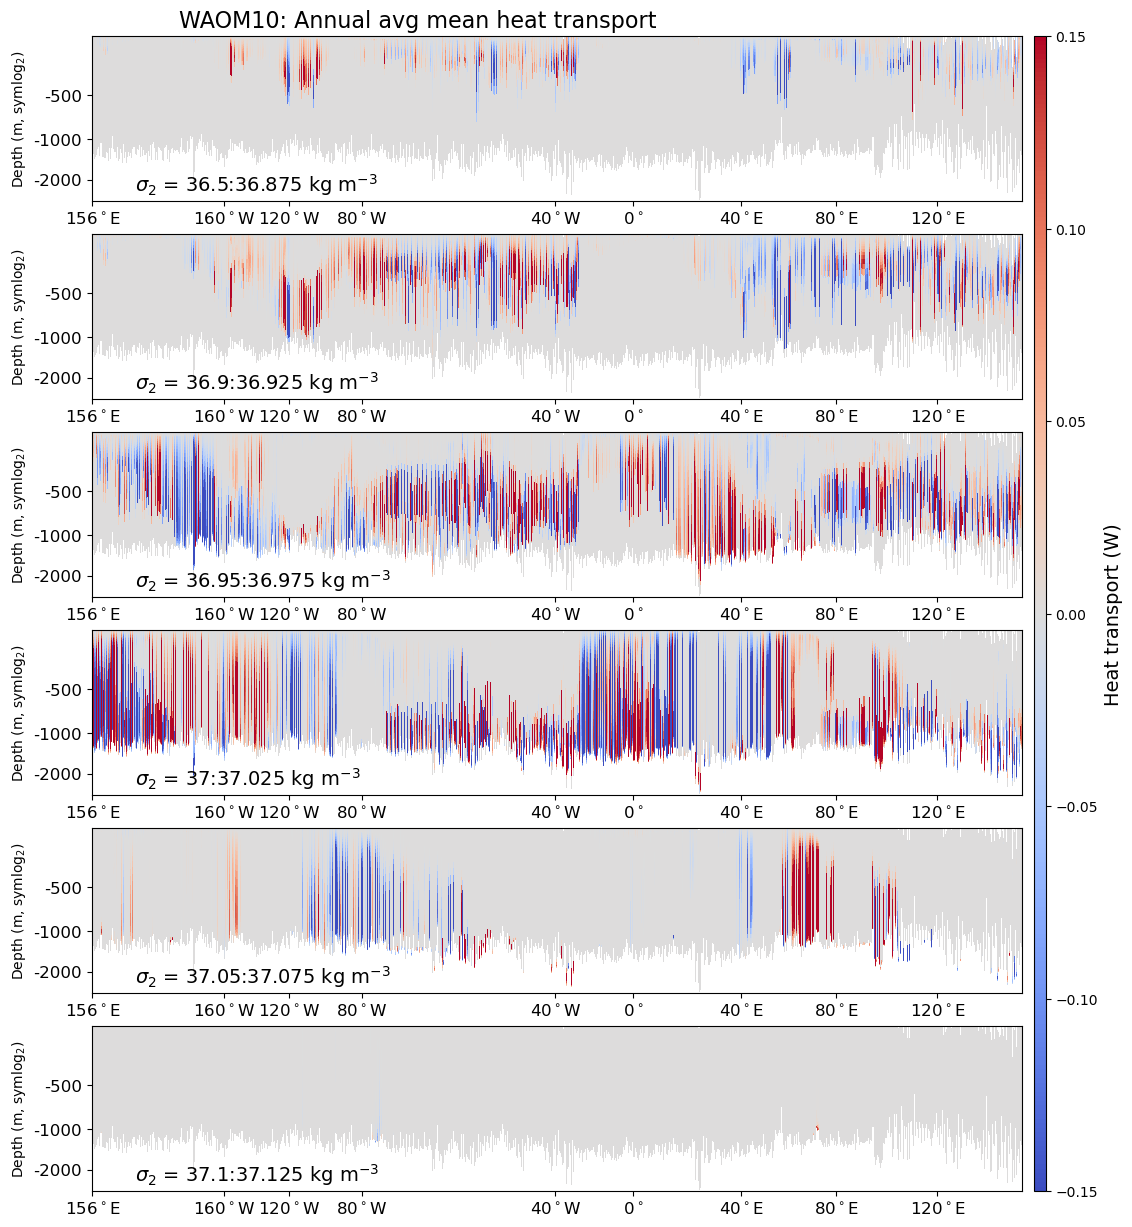

In [188]:
# Annual average for density-cross-1500m transports:
# WAOM10
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM10: Annual avg mean heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[0].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_10km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[1].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_10km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[2].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_10km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[3].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_10km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[4].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_10km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[5].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_10km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Mean_HT_cross1500m_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 10, EDDY HT

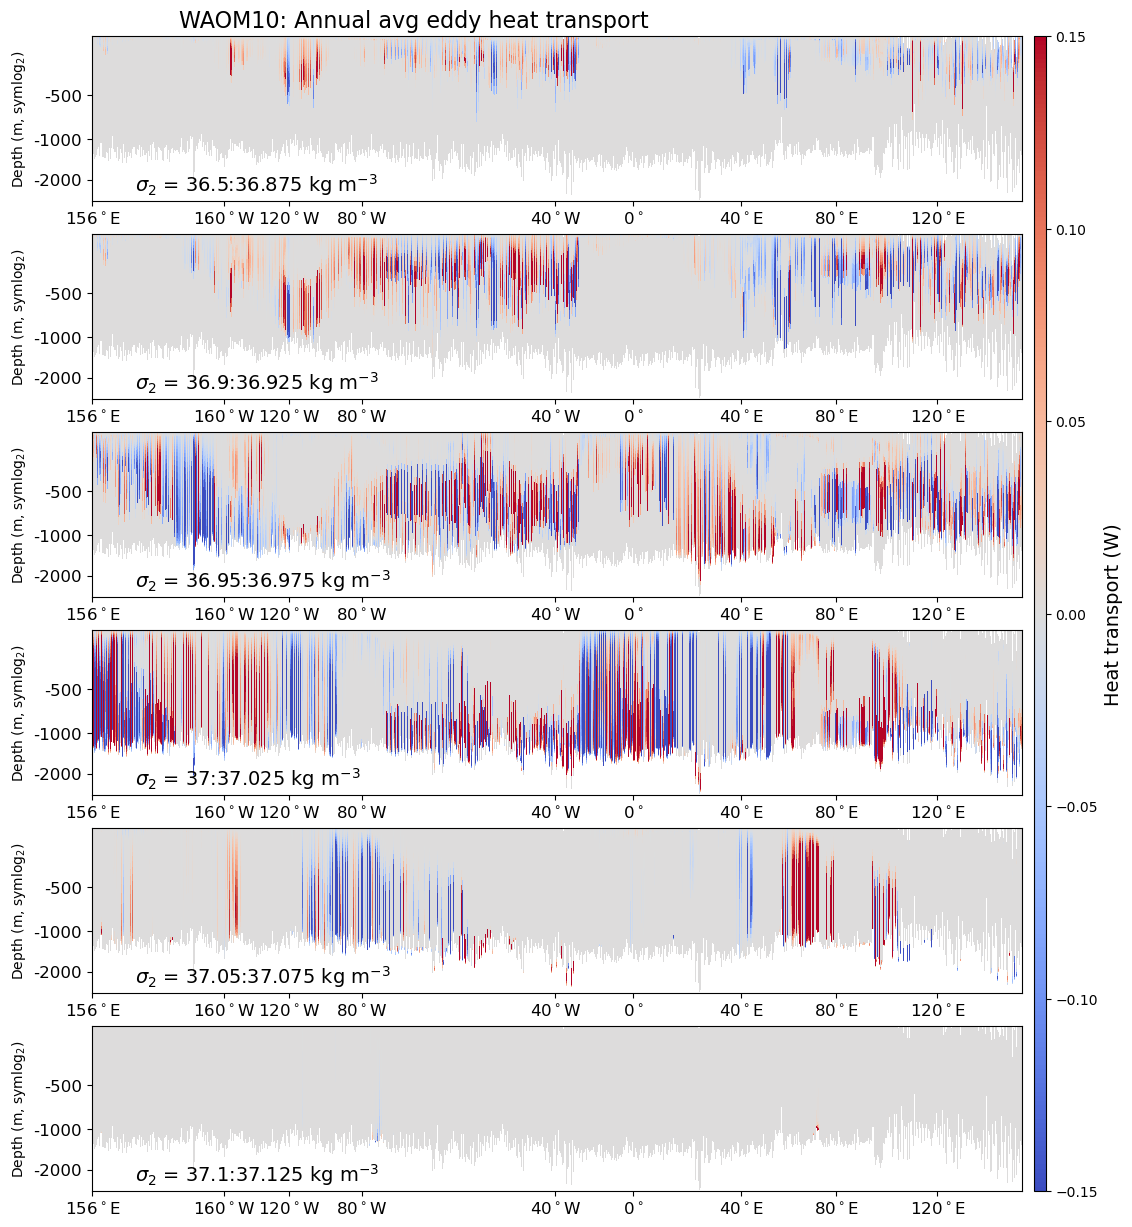

In [78]:
# Annual average for density-cross-1500m transports:
# WAOM10
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM10: Annual avg eddy heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[0].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_10km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[1].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_10km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[2].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_10km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1)* rho0*Cp*1e-12, axis=0), vmin=-.15, vmax=.15, cmap='coolwarm')
ax[3].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_10km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[4].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_10km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-.15, vmax=.15, cmap='coolwarm')
ax[5].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_10km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Eddy_HT_cross1500m_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 10, MEAN+EDDY HT

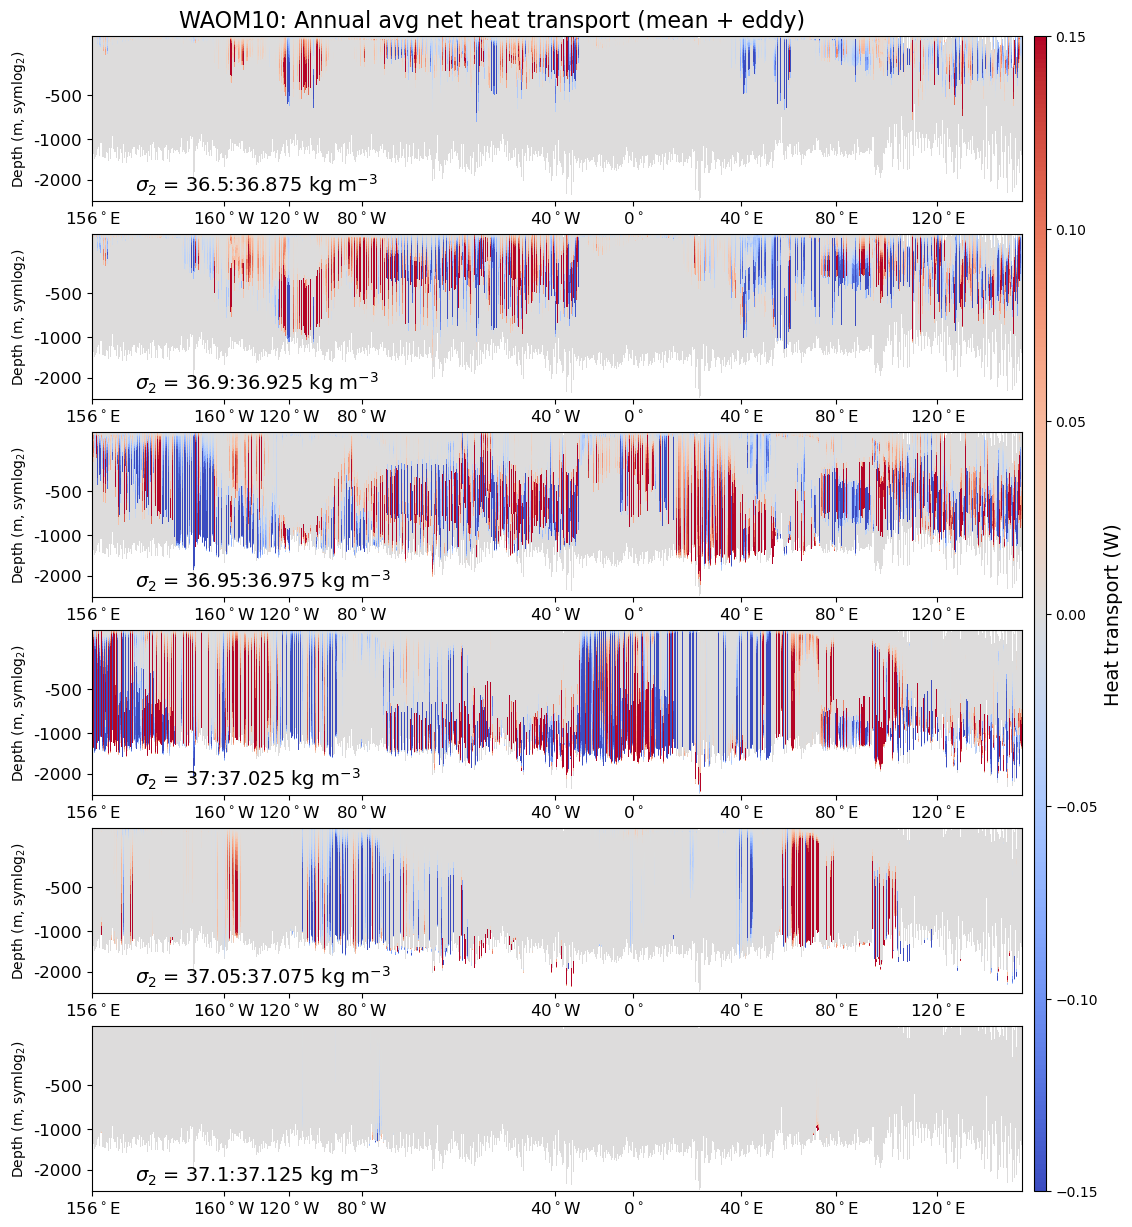

In [85]:
Net_HT_10km_irho2 = Mean_HT_10km_irho2 + Eddy_HT_10km_irho2


# Annual average for density-cross-1500m transports:
# WAOM10
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM10: Annual avg net heat transport (mean + eddy)',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm',vmin=-.15, vmax=.15)
ax[0].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_10km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm',vmin=-.15, vmax=.15)
ax[1].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_10km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm',vmin=-.15, vmax=.15)
ax[2].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_10km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm',vmin=-.15, vmax=.15)
ax[3].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_10km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm',vmin=-.15, vmax=.15)
ax[4].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_10km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm',vmin=-.15, vmax=.15)
ax[5].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_10km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Net_HT_cross1500m_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


## Plot section WAOM4

#### WAOM 4, MEAN HT

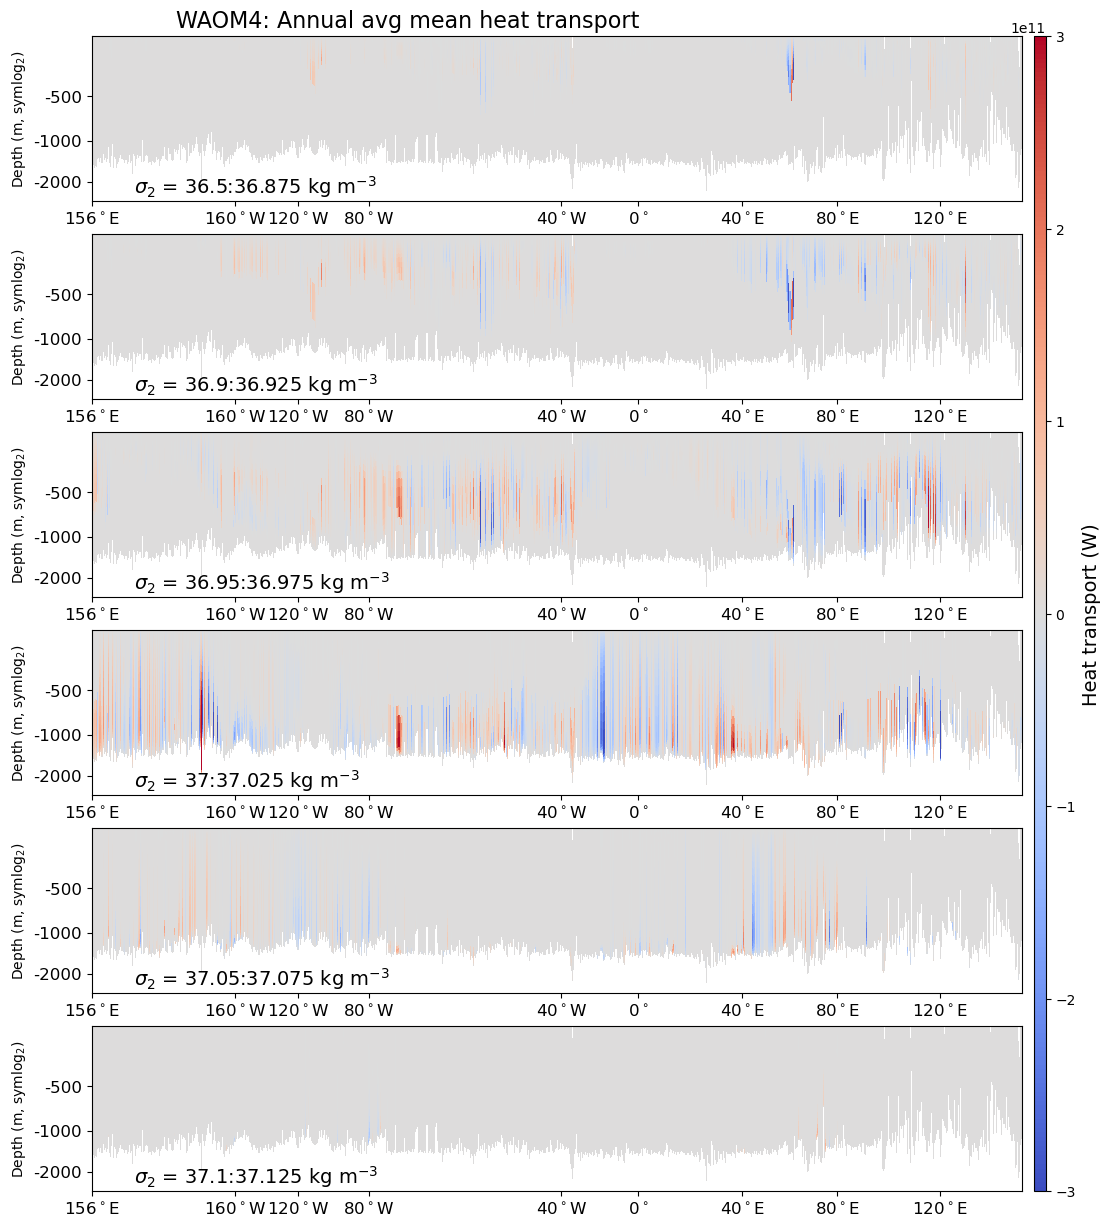

In [44]:
# Annual average for density-cross-1500m transports:
# WAOM4
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4: Annual avg mean heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Mean_HT_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 4, EDDY HT

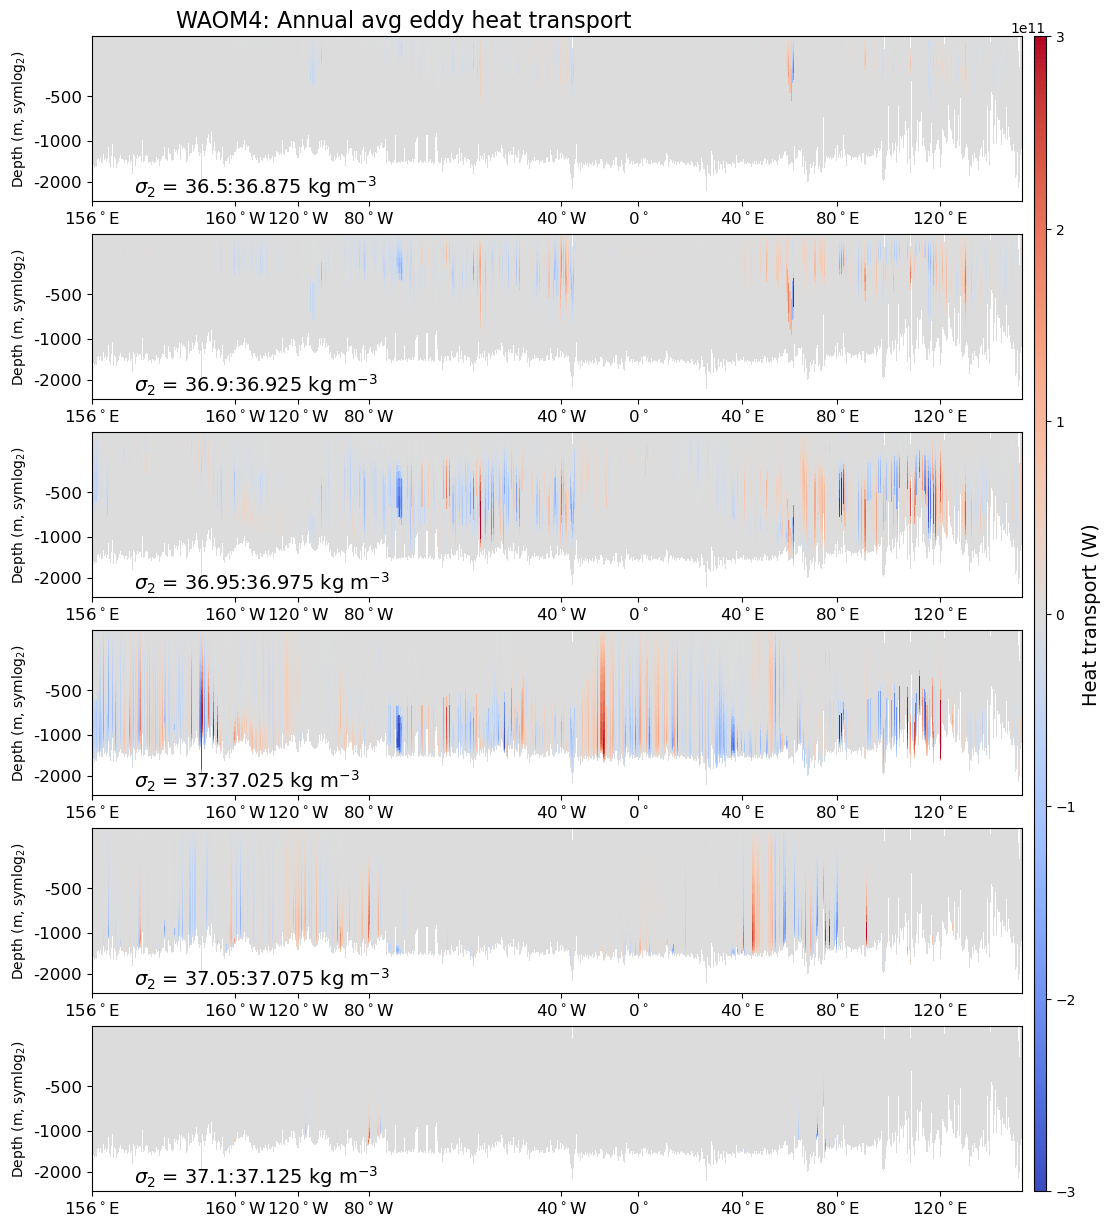

In [45]:
# Annual average for density-cross-1500m transports:
# WAOM4
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4: Annual avg eddy heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1)* rho0*Cp*1e-12, axis=0), vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Eddy_HT_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 4, MEAN+EDDY HT

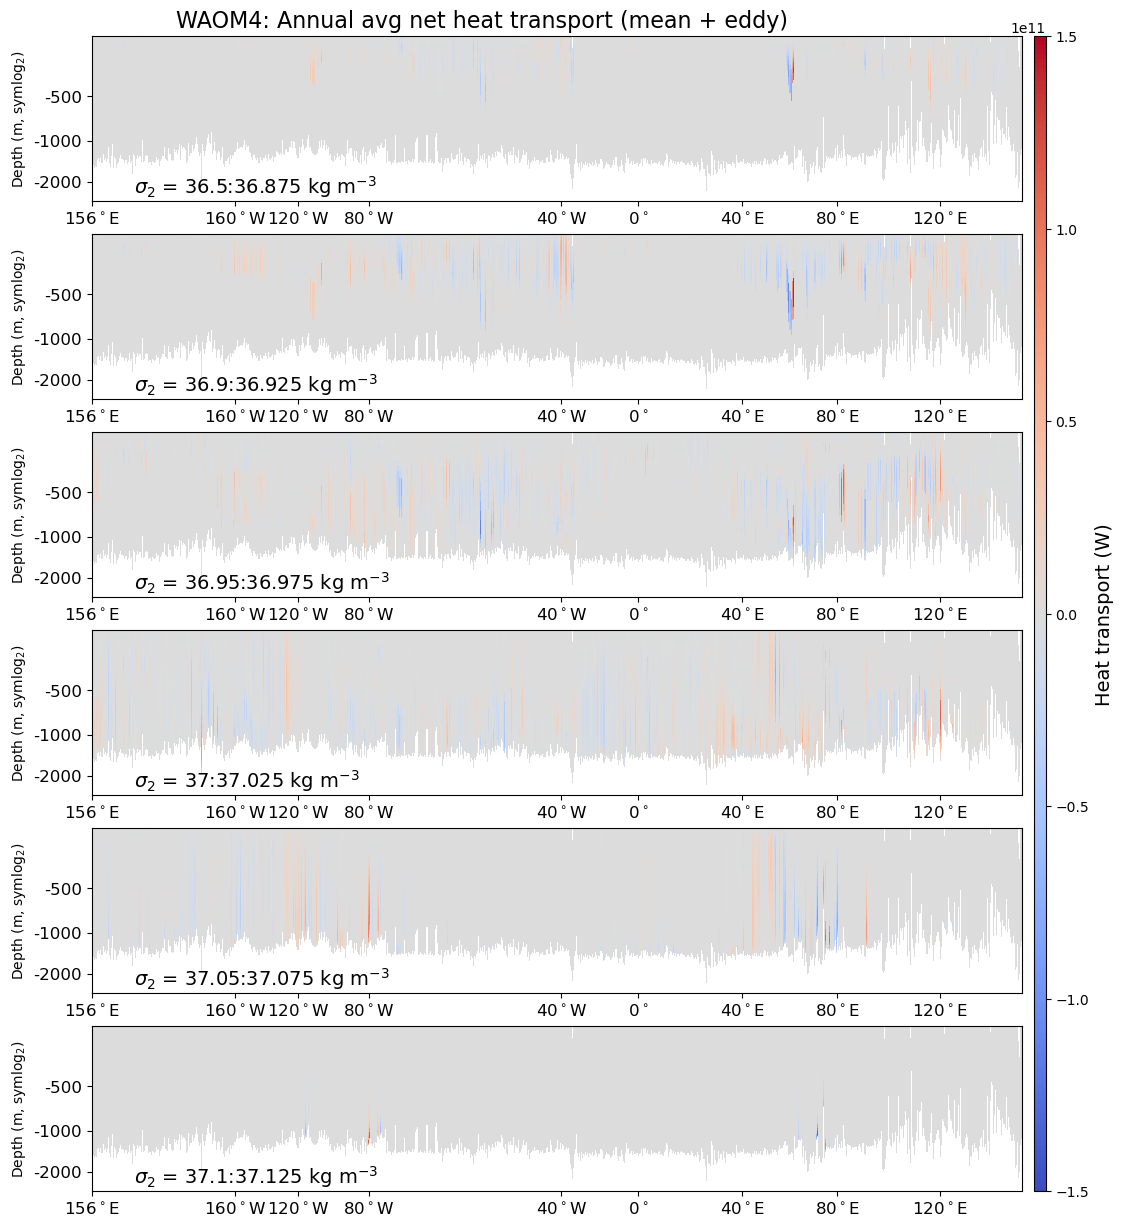

In [54]:
# Annual average for density-cross-1500m transports:
# WAOM4
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4: Annual avg net heat transport (mean + eddy)',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4km_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Net_HT_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


## Plot section WAOM4-NOTIDE

#### WAOM 4, MEAN HT

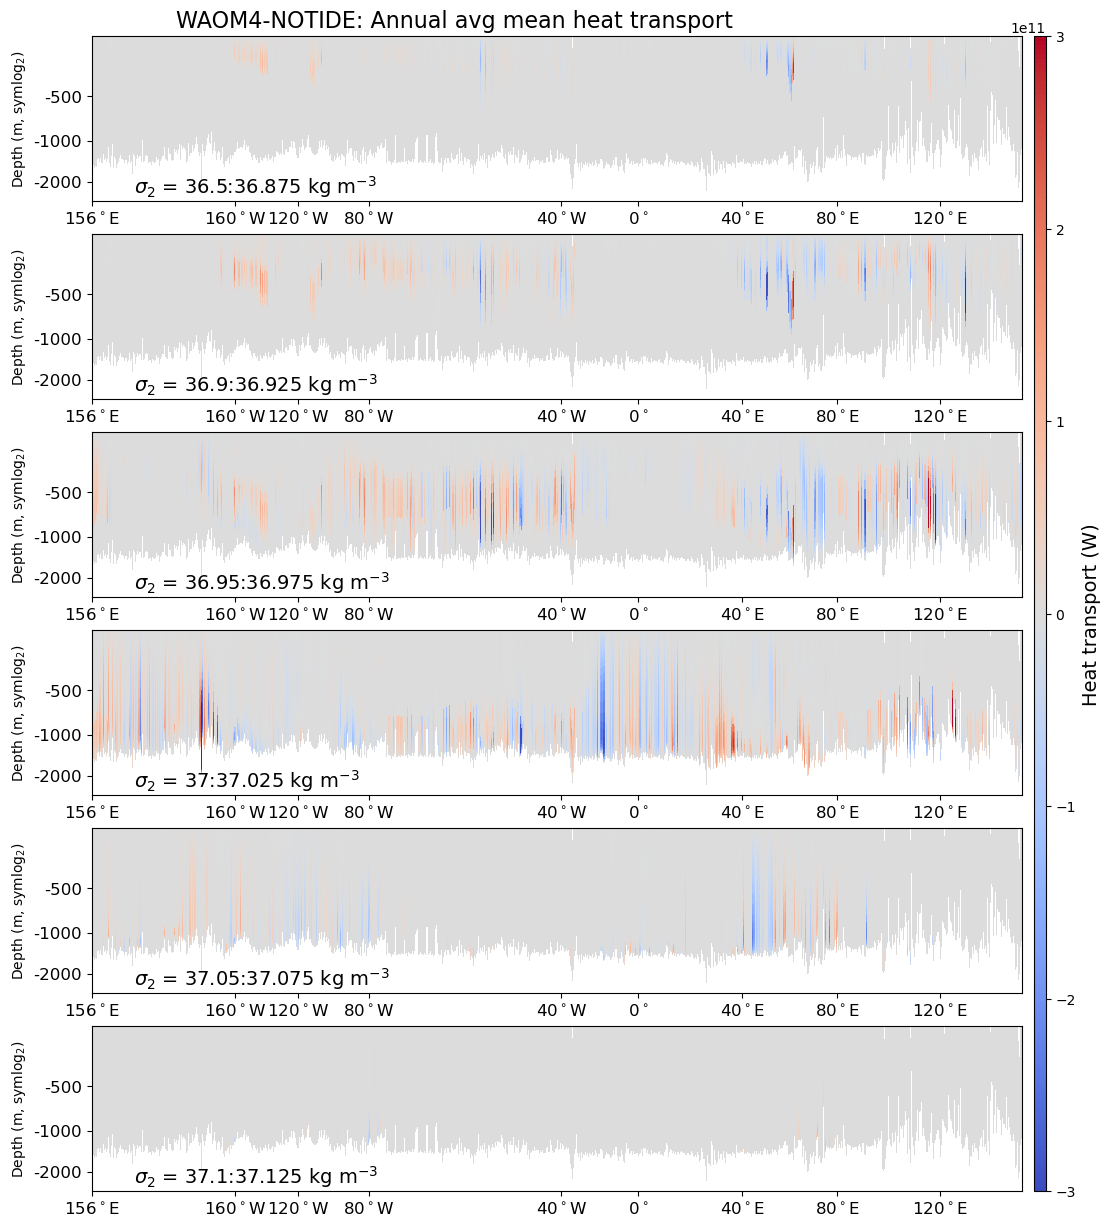

In [49]:
# Annual average for density-cross-1500m transports:
# WAOM4-NT
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4-NOTIDE: Annual avg mean heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),  axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_notides_Mean_HT_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 4, EDDY HT

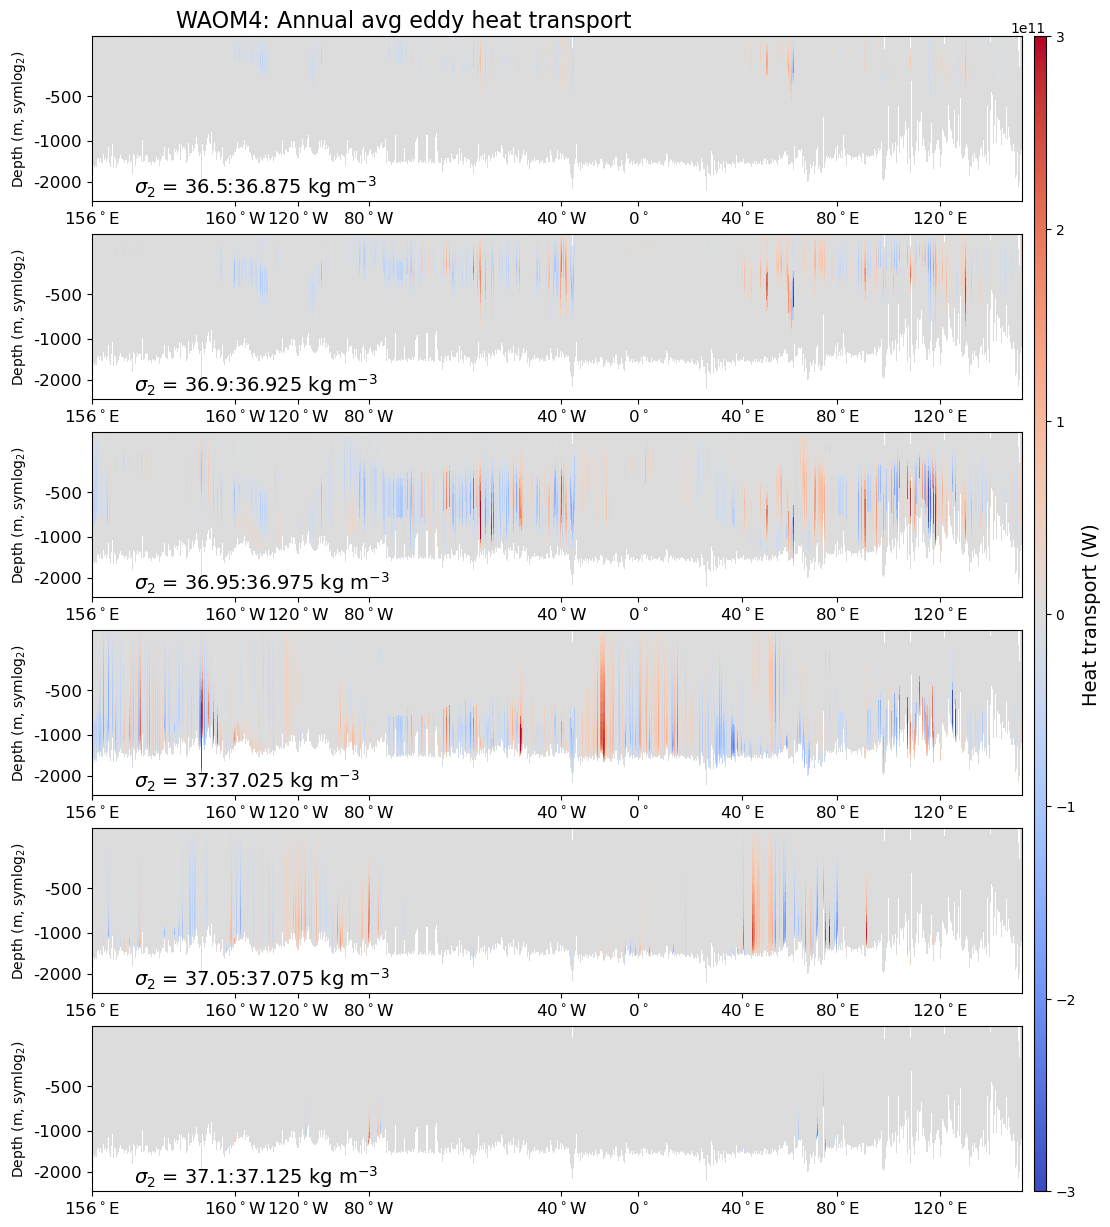

In [50]:
# Annual average for density-cross-1500m transports:
# WAOM4-NT
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4: Annual avg eddy heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1)* rho0*Cp*1e-12, axis=0), vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,np.nanmean(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, vmin=-3e11, vmax=3e11, cmap='coolwarm')
ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_notides_Eddy_HT_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 4, MEAN+EDDY HT

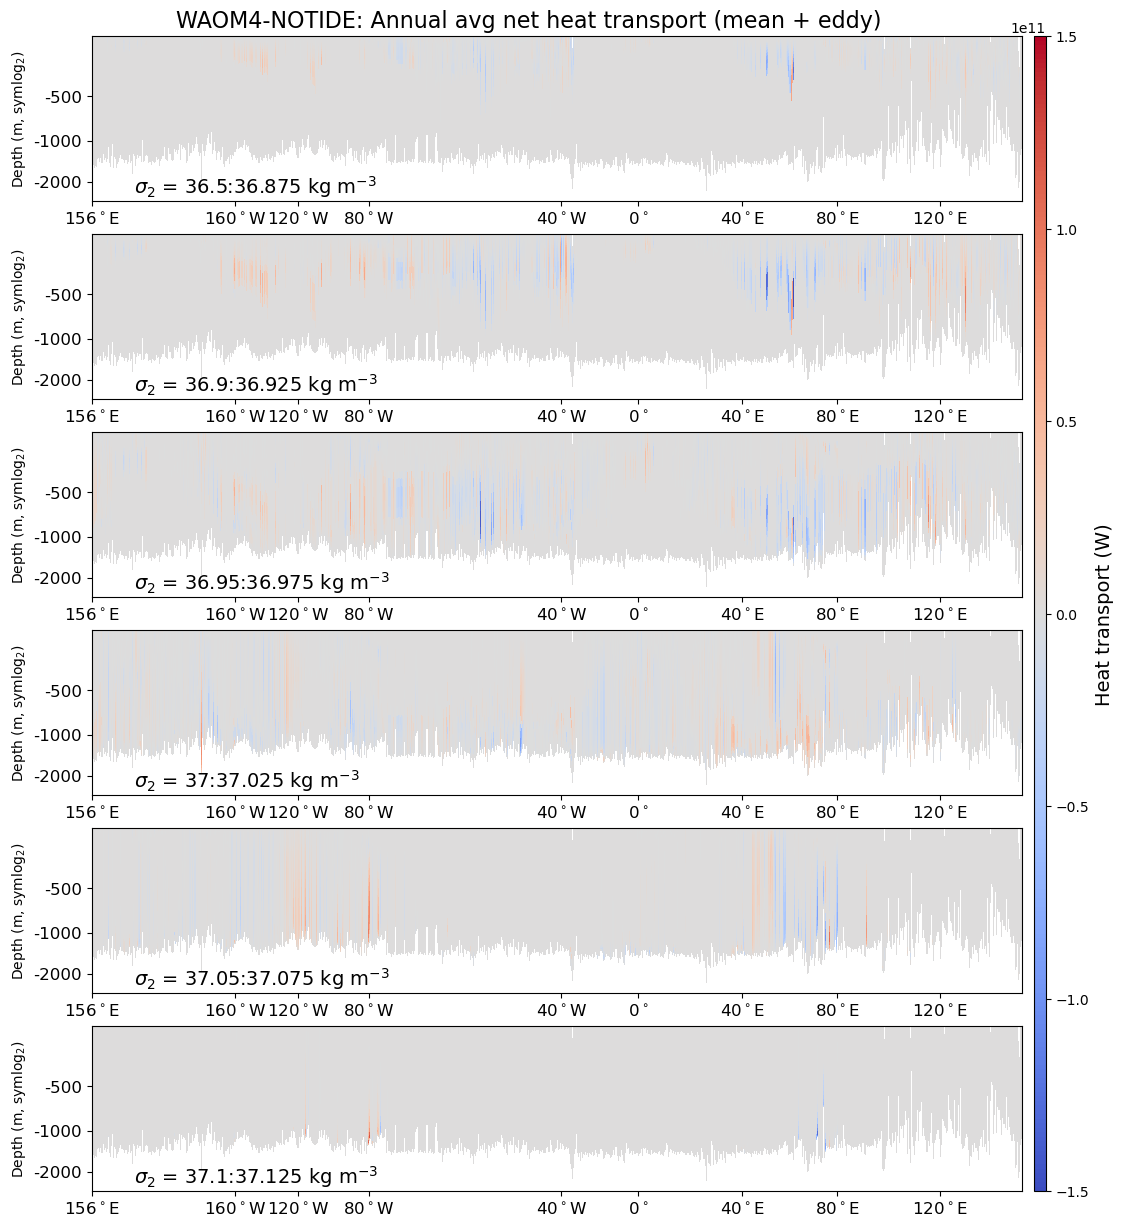

In [53]:
# Annual average for density-cross-1500m transports:
# WAOM4-NT
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4-NOTIDE: Annual avg net heat transport (mean + eddy)',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, dist_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, dist_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, dist_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, dist_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, dist_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,\
                        np.nanmean(np.nansum(Net_HT_4kmNT_irho2[:,ll,:,:], axis=1), axis=0)* rho0*Cp*1e-12, cmap='coolwarm', vmin=-1.5e11, vmax=1.5e11)
ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, dist_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_notides_Net_HT_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


## Movies with different isopycnals:


### - WAOM10:

In [ ]:
# # Annual average for density-cross-1500m transports:
# # WAOM10

# for tt in range(0,365):
#     fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
#     ax[0].text(2,75,'Daily mean net heat transport (absolute - T$_f$)')

#     ll=17 # 
#     cht = ax[0].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[0].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, dist_along_10km[-1])
#     ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)')
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ll=18
#     cht = ax[1].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[1].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, dist_along_10km[-1])
#     ax[1].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)')
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     ll=19
#     cht = ax[2].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[2].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, dist_along_10km[-1])
#     ax[2].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)')
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     ll=20
#     cht = ax[3].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[3].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                                 '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[3].set_xlim(0, dist_along_10km[-1])
#     ax[3].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[3].set_yscale('symlog',base = 2, linthresh=700)
#     ax[3].set_ylabel('Depth (m, symlog$_2$)')
#     ax[3].set_yticklabels(['-2000','-1000','-500'])
#     ax[3].set_aspect('auto')
#     ax[3].tick_params(labelsize=12)

#     ll=21
#     cht = ax[4].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[4].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[4].set_xlim(0, dist_along_10km[-1])
#     ax[4].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[4].set_yscale('symlog',base = 2, linthresh=700)
#     ax[4].set_ylabel('Depth (m, symlog$_2$)')
#     ax[4].set_yticklabels(['-2000','-1000','-500'])
#     ax[4].set_aspect('auto')
#     ax[4].tick_params(labelsize=12)
 
#     ll=22
#     cht = ax[5].pcolormesh(dist_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[5].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[5].set_xlim(0, dist_along_10km[-1])
#     ax[5].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[5].set_yscale('symlog',base = 2, linthresh=700)
#     ax[5].set_ylabel('Depth (m, symlog$_2$)')
#     ax[5].set_yticklabels(['-2000','-1000','-500'])
#     ax[5].set_aspect('auto')
#     ax[5].tick_params(labelsize=12)
 
#     cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
#     cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
#     cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Net_heat_transp_rho2_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

### - WAOM4:

In [29]:
# # Annual average for density-cross-1500m transports:
# # WAOM4

# for tt in range(0,365):
#     fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
#     ax[0].text(2,75,'Daily mean net heat transport (absolute - T$_f$)')

#     ll=17 # 
#     cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, dist_along_4km[-1])
#     ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)')
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ll=18
#     cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, dist_along_4km[-1])
#     ax[1].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)')
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     ll=19
#     cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, dist_along_4km[-1])
#     ax[2].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)')
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     ll=20
#     cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                                 '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[3].set_xlim(0, dist_along_4km[-1])
#     ax[3].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[3].set_yscale('symlog',base = 2, linthresh=700)
#     ax[3].set_ylabel('Depth (m, symlog$_2$)')
#     ax[3].set_yticklabels(['-2000','-1000','-500'])
#     ax[3].set_aspect('auto')
#     ax[3].tick_params(labelsize=12)

#     ll=21
#     cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[4].set_xlim(0, dist_along_4km[-1])
#     ax[4].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[4].set_yscale('symlog',base = 2, linthresh=700)
#     ax[4].set_ylabel('Depth (m, symlog$_2$)')
#     ax[4].set_yticklabels(['-2000','-1000','-500'])
#     ax[4].set_aspect('auto')
#     ax[4].tick_params(labelsize=12)
 
#     ll=22
#     cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[5].set_xlim(0, dist_along_4km[-1])
#     ax[5].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[5].set_yscale('symlog',base = 2, linthresh=700)
#     ax[5].set_ylabel('Depth (m, symlog$_2$)')
#     ax[5].set_yticklabels(['-2000','-1000','-500'])
#     ax[5].set_aspect('auto')
#     ax[5].tick_params(labelsize=12)
 
#     cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
#     cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
#     cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Net_heat_transp_rho2_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

### - WAOM4-NOTIDE:

In [30]:
# # Annual average for density-cross-1500m transports:
# # WAOM4-NOTIDE

# for tt in range(0,365):
#     fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
#     ax[0].text(2,75,'Daily mean net heat transport (absolute - T$_f$)')

#     ll=17 # 
#     cht = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, dist_along_4km[-1])
#     ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)')
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ll=18
#     cht = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, dist_along_4km[-1])
#     ax[1].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)')
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     ll=19
#     cht = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, dist_along_4km[-1])
#     ax[2].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)')
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     ll=20
#     cht = ax[3].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[3].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                                 '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[3].set_xlim(0, dist_along_4km[-1])
#     ax[3].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[3].set_yscale('symlog',base = 2, linthresh=700)
#     ax[3].set_ylabel('Depth (m, symlog$_2$)')
#     ax[3].set_yticklabels(['-2000','-1000','-500'])
#     ax[3].set_aspect('auto')
#     ax[3].tick_params(labelsize=12)

#     ll=21
#     cht = ax[4].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[4].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[4].set_xlim(0, dist_along_4km[-1])
#     ax[4].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[4].set_yscale('symlog',base = 2, linthresh=700)
#     ax[4].set_ylabel('Depth (m, symlog$_2$)')
#     ax[4].set_yticklabels(['-2000','-1000','-500'])
#     ax[4].set_aspect('auto')
#     ax[4].tick_params(labelsize=12)
 
#     ll=22
#     cht = ax[5].pcolormesh(dist_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[5].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[5].set_xlim(0, dist_along_4km[-1])
#     ax[5].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[5].set_yscale('symlog',base = 2, linthresh=700)
#     ax[5].set_ylabel('Depth (m, symlog$_2$)')
#     ax[5].set_yticklabels(['-2000','-1000','-500'])
#     ax[5].set_aspect('auto')
#     ax[5].tick_params(labelsize=12)
 
#     cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
#     cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
#     cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4-notides_Net_heat_transp_rho2_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

### movies for T/S/dens sections:

In [31]:
# %%time
# # Movie for density/temperature/salinity: WAOM10

# for tt in np.arange(0,365):
#     fig, ax = plt.subplots(nrows=3, figsize = (12, 9))

#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
        
#     cst = ax[0].pcolormesh(dist_along_axis_10km,z_rho_10km[tt,:,:],sigma_2_10km[tt,:,:], vmin=36.7 , vmax=37.1, cmap='tab20c')
#     ax[0].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, dist_along_10km[-1])
#     ax[0].text(1,-2500,'Pot. density ($\sigma_{2}$)',fontsize=14)
#     fig.colorbar(cst, ax=ax[0])
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ct = ax[1].pcolormesh(dist_along_axis_10km,z_rho_10km[tt,:,:],temp_10km[tt,:,:], vmin=-2 , vmax=2, cmap='tab20c')
#     ax[1].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, dist_along_10km[-1])
#     ax[1].text(1,-2500,'Pot. temperature',fontsize=14)
#     fig.colorbar(ct, ax=ax[1])
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     cs = ax[2].pcolormesh(dist_along_axis_10km,z_rho_10km[tt,:,:],salt_10km[tt,:,:], vmin=34 , vmax=35, cmap='tab20c')
#     ax[2].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, dist_along_10km[-1])
#     ax[2].text(1,-2500,'Salinity',fontsize=14)
#     fig.colorbar(cs, ax=ax[2])
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_sig2_temp_salt_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

In [32]:
# %%time
# # Movie for density/temperature/salinity: WAOM4

# for tt in np.arange(0,365):
#     fig, ax = plt.subplots(nrows=3, figsize = (12, 9))

#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
        
#     cst = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,sigma_2_4km[tt,:,:], vmin=36.7 , vmax=37.1, cmap='tab20c')
#     ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, dist_along_4km[-1])
#     ax[0].text(1,-2500,'Pot. density ($\sigma_{2}$)',fontsize=14)
#     fig.colorbar(cst, ax=ax[0])
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ct = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,temp_4km[tt,:,:], vmin=-2 , vmax=2, cmap='tab20c')
#     ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, dist_along_4km[-1])
#     ax[1].text(1,-2500,'Pot. temperature',fontsize=14)
#     fig.colorbar(ct, ax=ax[1])
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     cs = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,salt_4km[tt,:,:], vmin=34 , vmax=35, cmap='tab20c')
#     ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, dist_along_4km[-1])
#     ax[2].text(1,-2500,'Salinity',fontsize=14)
#     fig.colorbar(cs, ax=ax[2])
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_sig2_temp_salt_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

In [33]:
# %%time
# # Movie for density/temperature/salinity: WAOM4-NOTIDE

# for tt in np.arange(0,365):
#     fig, ax = plt.subplots(nrows=3, figsize = (12, 9))

#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
        
#     cst = ax[0].pcolormesh(dist_along_axis_4km,z_rho_4km,sigma_2_4kmNT[tt,:,:], vmin=36.7 , vmax=37.1, cmap='tab20c')
#     ax[0].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, dist_along_4km[-1])
#     ax[0].text(1,-2500,'Pot. density ($\sigma_{2}$)',fontsize=14)
#     fig.colorbar(cst, ax=ax[0])
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ct = ax[1].pcolormesh(dist_along_axis_4km,z_rho_4km,temp_4kmNT[tt,:,:], vmin=-2 , vmax=2, cmap='tab20c')
#     ax[1].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, dist_along_4km[-1])
#     ax[1].text(1,-2500,'Pot. temperature',fontsize=14)
#     fig.colorbar(ct, ax=ax[1])
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     cs = ax[2].pcolormesh(dist_along_axis_4km,z_rho_4km,salt_4kmNT[tt,:,:], vmin=34 , vmax=35, cmap='tab20c')
#     ax[2].set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, dist_along_4km[-1])
#     ax[2].text(1,-2500,'Salinity',fontsize=14)
#     fig.colorbar(cs, ax=ax[2])
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4-notides_sig2_temp_salt_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

## Doing some TS-diagrams:

In [118]:
# make grid for density contours
smin = 30 - (0.01 * 30)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36. + (0.01 * 36.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -4. + (0.1 * -4.)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 5 + (0.1 * 5.)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-4,5,ydim)
si = np.linspace(30,36,xdim)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],2000) # sigma-2000
# Substract 1000 to convert to sigma-2
dens = dens - 1000

tmin, tmax, smin, smax sizes=, -4.4 5.5 29.7 36.36


ValueError: 'c' argument has 79782065 elements, which is inconsistent with 'x' and 'y' with size 218581.

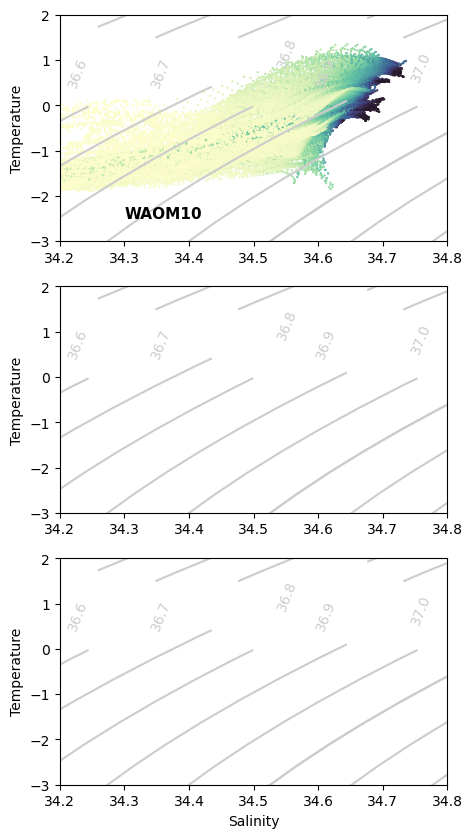

In [119]:
import cmocean

fig, ax = plt.subplots(nrows=3, figsize = (5, 10))
# normal isopycnals
for aa in range(0,3):
    CS1 = ax[aa].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,37.2,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[aa].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    CS2 = ax[aa].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[aa].clabel(CS2, CS2.levels, inline=True, fontsize=10)
    # specific isopycnals
    # cc1 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.85],linestyles='solid', colors='darkgrey', linewidth=0.1)
    # ax[aa].clabel(cc1, cc1.levels, inline=True, fontsize=10)
    # cc2 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.9],linestyles='solid', colors='khaki', linewidth=0.1)
    # ax[aa].clabel(cc2, cc2.levels, inline=True, fontsize=10)
    # cc3 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.95],linestyles='solid', colors='aqua', linewidth=0.1)
    # ax[aa].clabel(cc3, cc3.levels, inline=True, fontsize=10)
    # cc4 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.0],linestyles='solid', colors='steelblue', linewidth=0.1)
    # ax[aa].clabel(cc4, cc4.levels, inline=True, fontsize=10)
    # cc5 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.05],linestyles='solid', colors='darkorange', linewidth=0.1)
    # ax[aa].clabel(cc5, cc5.levels, inline=True, fontsize=10)
    # cc6 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.1],linestyles='solid', colors='limegreen', linewidth=0.1)
    # ax[aa].clabel(cc6, cc6.levels, inline=True, fontsize=10)
    ax[aa].set_xlim([34.2,34.8])
    ax[aa].set_ylim([-3,2])
    ax[aa].set_ylabel('Temperature')
    if aa == 2:
        ax[aa].set_xlabel('Salinity')
        
sc = ax[0].scatter(np.nanmean(salt_10km,axis=0),np.nanmean(temp_10km,axis=0),
                 c=-np.nanmean(z_rho_10km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0].text(34.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1].scatter(np.nanmean(salt_4km,axis=0),np.nanmean(temp_4km,axis=0),
                 c=-z_rho_4km,marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1].text(34.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2].scatter(np.nanmean(salt_4kmNT,axis=0),np.nanmean(temp_4kmNT,axis=0),
                 c=-z_rho_4km,marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2].text(34.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')

# - cbar horiz
# cbar_ax1 = fig.add_axes([0.12, 0.005, 0.785, 0.01])
# fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
# cbar_ax1.set_xlabel('Depth (m)')
# - cbar vert
cbar_ax1 = fig.add_axes([0.8, 0.3, 0.01, 0.6])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_1500m_rho2_annnual.png"
plt.savefig(name_fig, bbox_inches='tight', dpi=300)

In [120]:
Mean_HT_10km_irho2.shape

(365, 48, 31, 2688)

# integrated over circumpolar domain per density classes:

In [79]:
%%time

# - Calculate total sum per density bin:
# the order of the operations matter; averaging on time as last operat. hugely changes the directions of transport.

Sum_MeanHT_10km_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanHT_10km_sigma2 = np.empty((len(rho_grid2),3297)) # 
Sum_MeanVT_10km_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanVT_10km_sigma2 = np.empty((len(rho_grid2),3297)) # 

Sum_MeanHT_4km_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanHT_4km_sigma2 = np.empty((len(rho_grid2),9014)) # 
Sum_MeanVT_4km_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanVT_4km_sigma2 = np.empty((len(rho_grid2),9014)) # 

Sum_MeanHT_4kmNT_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanHT_4kmNT_sigma2 = np.empty((len(rho_grid2),9014)) # 
Sum_MeanVT_4kmNT_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanVT_4kmNT_sigma2 = np.empty((len(rho_grid2),9014)) # 

for ll in np.arange(0,len(rho_grid2),1):
    Sum_MeanHT_10km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM VERT LEV, SUM ALONG CONTOUR, MEAN TIME
    # Cumsum_MeanHT_10km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM RHO_GRID, CUMSUM ALONG CONTOUR, MEAN TIME
    Sum_MeanVT_10km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_VT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM VERT LEV, SUM ALONG CONTOUR, MEAN TIME
    # Cumsum_MeanVT_10km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_VT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM RHO_GRID, CUMSUM ALONG CONTOUR, MEAN TIME
   
    Sum_MeanHT_4km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanHT_4km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Sum_MeanVT_4km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_VT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanVT_4km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_VT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)

    Sum_MeanHT_4kmNT_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanHT_4kmNT_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Sum_MeanVT_4kmNT_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_VT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanVT_4kmNT_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_VT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)



CPU times: user 7min 54s, sys: 7min 29s, total: 15min 24s
Wall time: 40min 7s


In [80]:
%%time

# - Calculate total sum per density bin:
# the order of the operations matter; averaging on time as last operat. hugely changes the directions of transport.

Sum_MeanHT_10km_CF_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanHT_10km_CF_sigma2 = np.empty((len(rho_grid2),3297)) # 
Sum_MeanVT_10km_CF_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanVT_10km_CF_sigma2 = np.empty((len(rho_grid2),3297)) # 

Sum_MeanHT_4km_CF_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanHT_4km_CF_sigma2 = np.empty((len(rho_grid2),9014)) # 
Sum_MeanVT_4km_CF_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanVT_4km_CF_sigma2 = np.empty((len(rho_grid2),9014)) # 

Sum_MeanHT_4kmNT_CF_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanHT_4kmNT_CF_sigma2 = np.empty((len(rho_grid2),9014)) # 
Sum_MeanVT_4kmNT_CF_sigma2 = np.empty(len(rho_grid2)) # 
# Cumsum_MeanVT_4kmNT_CF_sigma2 = np.empty((len(rho_grid2),9014)) # 

for ll in np.arange(0,len(rho_grid2),1):
    Sum_MeanHT_10km_CF_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_10km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM VERT LEV, SUM ALONG CONTOUR, MEAN TIME
    # Cumsum_MeanHT_10km_CF_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_10km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM RHO_GRID, CUMSUM ALONG CONTOUR, MEAN TIME
    Sum_MeanVT_10km_CF_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_VT_10km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM VERT LEV, SUM ALONG CONTOUR, MEAN TIME
    # Cumsum_MeanVT_10km_CF_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_VT_10km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM RHO_GRID, CUMSUM ALONG CONTOUR, MEAN TIME
   
    Sum_MeanHT_4km_CF_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_4km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanHT_4km_CF_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_4km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Sum_MeanVT_4km_CF_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_VT_4km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanVT_4km_CF_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_VT_4km_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)

    Sum_MeanHT_4kmNT_CF_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_4kmNT_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanHT_4kmNT_CF_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_4kmNT_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Sum_MeanVT_4kmNT_CF_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_VT_4kmNT_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    # Cumsum_MeanVT_CF_4kmNT_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_VT_4kmNT_CF_irho2[:,ll,:,:], axis=1),axis=1), axis=0)




CPU times: user 8min 57s, sys: 8min 59s, total: 17min 56s
Wall time: 44min 37s


In [81]:
print(fig_path)

/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/


In [ ]:
fig, ax = plt.subplots(ncols=1, figsize = (8, 4))

# multiplying by -1 to match vol transp
ax.plot(rho_grid2,-Sum_MeanHT_10km_sigma2*rho0*Cp*1e-12,'--r', label='WAOM10')
ax.plot(rho_grid2,-Sum_MeanHT_4km_sigma2*rho0*Cp*1e-12,'--b', label='WAOM4')
ax.plot(rho_grid2,-Sum_MeanHT_4kmNT_sigma2*rho0*Cp*1e-12,'--c', label='WAOM4-NOTIDE')
ax.legend()
ax.plot(rho_grid2,-Sum_EddyHT_10km_sigma2*rho0*Cp*1e-12,':r', label='WAOM10')
ax.plot(rho_grid2,-Sum_EddyHT_4km_sigma2*rho0*Cp*1e-12,':b', label='WAOM4')
ax.plot(rho_grid2,-Sum_EddyHT_4kmNT_sigma2*rho0*Cp*1e-12,':c', label='WAOM4-NOTIDE')
ax.plot(rho_grid2,-(Sum_MeanHT_10km_sigma2+Sum_EddyHT_10km_sigma2)*rho0*Cp*1e-12,'-r', label='WAOM10')
ax.plot(rho_grid2,-(Sum_MeanHT_4km_sigma2+Sum_EddyHT_4km_sigma2)*rho0*Cp*1e-12,'-b', label='WAOM4')
ax.plot(rho_grid2,-(Sum_MeanHT_4kmNT_sigma2+Sum_EddyHT_4kmNT_sigma2)*rho0*Cp*1e-12,'-c', label='WAOM4-NOTIDE')
ax.grid()
ax.set_xlim(36.6,37.35)
ax.set_ylim(-50,50)

ax.set_ylabel('Net heat transport (TW)')# (Abs-T$_{f}$, 10$^{15}$W'])
ax.set_xlabel('Pot. density ($\sigma_2$)')

name_fig='WAOM10x4x4NT_Cross-1500m_sumtransport_Sigma2bin_MeanEddyHT_vint_annual_v2.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)
plt.show()


NameError: name 'Sum_EddyHT_10km_sigma2' is not defined

NameError: name 'Sum_MeanHT_10km_CF_sigma2' is not defined

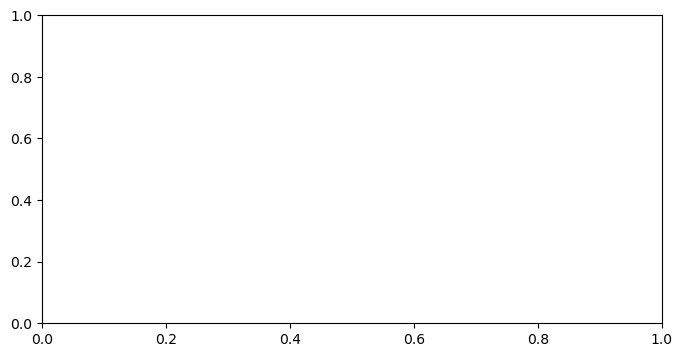

In [121]:
fig, ax = plt.subplots(ncols=1, figsize = (8, 4))

# multiplying by -1 to match vol transp
ax.plot(rho_grid2,-Sum_MeanHT_10km_CF_sigma2*rho0*Cp*1e-12,'--r', label='WAOM10')
ax.plot(rho_grid2,-Sum_MeanHT_4km_CF_sigma2*rho0*Cp*1e-12,'--b', label='WAOM4')
ax.plot(rho_grid2,-Sum_MeanHT_4kmNT_CF_sigma2*rho0*Cp*1e-12,'--c', label='WAOM4-NOTIDE')
ax.legend()
ax.plot(rho_grid2,-Sum_EddyHT_10km_CF_sigma2*rho0*Cp*1e-12,':r', label='WAOM10')
ax.plot(rho_grid2,-Sum_EddyHT_4km_CF_sigma2*rho0*Cp*1e-12,':b', label='WAOM4')
ax.plot(rho_grid2,-Sum_EddyHT_4kmNT_CF_sigma2*rho0*Cp*1e-12,':c', label='WAOM4-NOTIDE')
ax.plot(rho_grid2,-(Sum_MeanHT_10km_CF_sigma2+Sum_EddyHT_10km_sigma2)*rho0*Cp*1e-12,'-r', label='WAOM10')
ax.plot(rho_grid2,-(Sum_MeanHT_4km_CF_sigma2+Sum_EddyHT_4km_sigma2)*rho0*Cp*1e-12,'-b', label='WAOM4')
ax.plot(rho_grid2,-(Sum_MeanHT_4kmNT_CF_sigma2+Sum_EddyHT_4kmNT_sigma2)*rho0*Cp*1e-12,'-c', label='WAOM4-NOTIDE')
ax.grid()
ax.set_xlim(36.6,37.35)
ax.set_ylim(-25,25)

ax.set_ylabel('Net heat transport (TW)')# (Abs-T$_{f}$, 10$^{15}$W'])
ax.set_xlabel('Pot. density ($\sigma_2$)')

name_fig='WAOM10x4x4NT_Cross-CF_sumtransport_Sigma2bin_MeanEddyHT_vint_annual_v2.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
np.around(rho_grid2[33],2)


In [ ]:
rho_grid2

In [ ]:
# FIGURE 2: CROSS-1500M HEAT TRANSPORT PER DENSITY! 2 rows, 3 columns
# 1) Circum-Ant. Cross-1500m heat transport per density classes (row 1, col 1)
# 2) TS-diagram WAOM4 (row 1, col 2)
# 3) net cross-1500 HT integrated for densities >= 37 sig2 (row 2, col 1:2)
# 4) mean/eddy decom. cross-1500 HT depth-int. for densities >= 37 sig2 (row 3, col 1:2)

fig = plt.figure(figsize=(15,14))

# 
# 1)
# NET
ax1 = fig.add_subplot(3,2,1)
ax1.plot(rho_grid2,(Sum_MeanHT_10km_sigma2+Sum_EddyHT_10km_sigma2)* rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1,alpha=.7)
ax1.plot(rho_grid2,(Sum_MeanHT_4km_sigma2+Sum_EddyHT_4km_sigma2)* rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
ax1.plot(rho_grid2,(Sum_MeanHT_4kmNT_sigma2+Sum_EddyHT_4kmNT_sigma2)* rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1,alpha=.7)
ax1.legend(loc='upper left')
ax1b = ax1.twiny()
ax1b.plot(rho_grid2[0],(Sum_MeanHT_4km_sigma2[0]+Sum_EddyHT_4km_sigma2[0])* rho0*Cp*1e-12,'-k', label='NET',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4km_sigma2* rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4km_sigma2* rho0*Cp*1e-12,'-', color='orangered', label='EIT',linewidth=1.6)

ax1b.plot(rho_grid2,Sum_MeanHT_10km_sigma2* rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_10km_sigma2* rho0*Cp*1e-12,'--',color='orangered',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4kmNT_sigma2* rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4kmNT_sigma2* rho0*Cp*1e-12,':', color='orangered',linewidth=1,alpha=.6)
# line at 37.02 sig2
ax1.plot(np.around(rho_grid2[33],2)*np.ones(np.arange(-100,100).shape)\
          ,np.arange(-100,100),'-', color='gold',linewidth=2,alpha=0.75)

ax1b.legend(loc='lower left')
ax1.grid()
ax1b.set_xlim(36.7,37.2)
ax1b.set_ylim(-100,100)
ax1b.set_xticklabels((''))
ax1.set_ylabel('Heat transport (TW)')
ax1.set_xlabel('Potential density ($\sigma_2$)')

# 2) TS-diagram
ax2 = fig.add_subplot(3,2,2)
CS1 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,37.2,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS1, CS1.levels, inline=True, fontsize=10)
CS2 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS2, CS2.levels, inline=True, fontsize=10)
# specific isopycnals
cc1 = ax2.contour(Si,Ti,dens.transpose(), levels=[37.02],linestyles='solid', colors='gold',linewidth=0.2)
ax2.clabel(cc1, cc1.levels, inline=True, fontsize=10)
ax2.set_xlim([34.2,34.8])
ax2.set_ylim([-2.5,1.5])
ax2.set_ylabel('Potential temperature (degC)')
ax2.set_xlabel('Salinity')
sc = ax2.scatter(np.nanmean(salt_4km,axis=0),np.nanmean(temp_4km,axis=0),
                 c=-z_rho_4km,marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax2.text(34.21,-2.3,'WAOM4', fontsize=12)#, fontweight='bold')
cbar_ax1 = fig.add_axes([0.76, 0.73, 0.01, 0.16])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

# 3)
ax3 = fig.add_subplot(3,1,2)
ll=np.arange(33,38) #20
cht = ax3.pcolormesh(dist_along_axis_4km,z_rho_4km,(\
                     np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1), axis=0) +
                     np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0))*rho0*Cp*1e-12, cmap='coolwarm', vmin=-.1, vmax=.1)
ax3.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax3.set_xticklabels((''))#156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            # '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax3.set_xlim(0, dist_along_4km[-1])
ax3.text(1,-2500,'Cross-1500m heat transport due to NET, $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[0]],2)) + ' kg m$^{-3}$',fontsize=12)
ax3.plot([3.634185,3.634185],[-2000,0],'-', color=[.6,.6,.6])                 
ax3.plot([8,8],[-2000,0],'-', color=[.6,.6,.6])                                # 1) Mask Weddell (90W : 25W, lat < -75, 65W : 25W, lat <= -75)
ax3.plot([11.5,11.5],[-2000,0],'-', color=[.6,.6,.6])     
ax3.plot([15,15],[-2000,0],'-', color=[.6,.6,.6])      
ax3.set_yscale('symlog',base = 2, linthresh=700)
ax3.set_ylabel('Depth (m, log$_2$)')
ax3.set_yticklabels(['-2000','-1000','-500'])
# ax3.set_ylim(-2000,0)
ax3.set_aspect('auto')

# ax3.tick_params(labelsize=12)
cbar_ax2 = fig.add_axes([0.76, 0.52, 0.01, 0.16])
fig.colorbar(cht, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Heat transport (TW)')

# 4)
ax4 = fig.add_subplot(3,1,3)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-k', label='NET',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='orangered', label='EIT',linewidth=1.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':k',linewidth=1.,alpha=0.7)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1.,alpha=0.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='orangered',linewidth=1.,alpha=0.6)
ax4.legend(loc='lower left')
ax4.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax4.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax4.set_xlim(0, dist_along_4km[-1])
ax4.legend(loc='upper left')

ax4.set_ylim(-300,300)
ax4.text(2.895576e+00-1.5,-290,'Ross',fontsize=13, color='k')         # 4) Mask Ross (140W : 160E, lat < -60)
ax4.plot([3.634185,3.634185],[-600,600],'-', color=[.6,.6,.6])                 
ax4.text(4.1,-290,'West Ant.',fontsize=13, color='k')           # 5) Mask West Antarctica (150W : 90W, lat < -65)
ax4.plot([8,8],[-600,600],'-', color=[.6,.6,.6])                                # 1) Mask Weddell (90W : 25W, lat < -75, 65W : 25W, lat <= -75)
ax4.text(9,-290,'Weddell',fontsize=13, color='k')
ax4.plot([11.5,11.5],[-600,600],'-', color=[.6,.6,.6])     
ax4.text(12,-290,'Maud Land',fontsize=13, color='k')                  # 2) Mask Maud Land (25W : 60E, lat < -60)
ax4.plot([15,15],[-600,600],'-', color=[.6,.6,.6])      
ax4.text(17,-290,'East Ant.',fontsize=13, color='k')            # 3) Mask East Antarctica (60E : 160E, lat < -60)
ax4.set_title('Cross-1500m heat transport due to NET vertically-integrated, $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[0]],2)) + 'kg m$^{-3}$')
ax4.set_ylabel('Heat transport (TW)')

ax4b = ax4.twiny() # to plot 10km together
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1.6)
ax4b.legend(loc='upper right')
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='orangered',linewidth=1.,alpha=0.6)
ax4b.set_xticklabels((''))
ax4b.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax4b.set_xlim(0, dist_along_10km[-1])

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig='Figure2_Cross-1500m_sumtransport_Sig2_gt37.02_MeanEddyHT_v2.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)
plt.show()



In [ ]:
# FIGURE 2: CROSS-1500M HEAT TRANSPORT PER DENSITY! 2 rows, 3 columns
# 1) Circum-Ant. Cross-1500m heat transport per density classes (row 1, col 1)
# 2) TS-diagram WAOM4 (row 1, col 2)
# 3) net cross-1500 HT integrated for densities >= 37 sig2 (row 2, col 1:2)
# 4) mean/eddy decom. cross-1500 HT depth-int. for densities >= 37 sig2 (row 3, col 1:2)

fig = plt.figure(figsize=(15,14))

# 
# 1)
# NET
ax1 = fig.add_subplot(3,2,1)
ax1.plot(rho_grid2,(Sum_MeanHT_10km_sigma2+Sum_EddyHT_10km_sigma2)* rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1,alpha=.7)
ax1.plot(rho_grid2,(Sum_MeanHT_4km_sigma2+Sum_EddyHT_4km_sigma2)* rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
ax1.plot(rho_grid2,(Sum_MeanHT_4kmNT_sigma2+Sum_EddyHT_4kmNT_sigma2)* rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1,alpha=.7)
ax1.legend(loc='upper left')
ax1b = ax1.twiny()
ax1b.plot(rho_grid2[0],(Sum_MeanHT_4km_sigma2[0]+Sum_EddyHT_4km_sigma2[0])* rho0*Cp*1e-12,'-k', label='NET',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4km_sigma2* rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4km_sigma2* rho0*Cp*1e-12,'-', color='orangered', label='EIT',linewidth=1.6)

ax1b.plot(rho_grid2,Sum_MeanHT_10km_sigma2* rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_10km_sigma2* rho0*Cp*1e-12,'--',color='orangered',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4kmNT_sigma2* rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4kmNT_sigma2* rho0*Cp*1e-12,':', color='orangered',linewidth=1,alpha=.6)
ax1.plot(np.around(rho_grid2[27],2)*np.ones(np.arange(-100,100).shape)\
          ,np.arange(-100,100),'-', color='gold',linewidth=2,alpha=0.75)
ax1.plot(np.around(rho_grid2[32],2)*np.ones(np.arange(-100,100).shape)\
          ,np.arange(-100,100),'-', color='gold',linewidth=2,alpha=0.75)
ax1b.legend(loc='lower left')
ax1.grid()
ax1b.set_xlim(36.7,37.2)
ax1b.set_ylim(-100,100)
ax1b.set_xticklabels((''))
ax1.set_ylabel('Heat transport (TW)')
ax1.set_xlabel('Potential density ($\sigma_2$)')


# 2) TS-diagram
ax2 = fig.add_subplot(3,2,2)
CS1 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,37.2,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS1, CS1.levels, inline=True, fontsize=10)
CS2 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS2, CS2.levels, inline=True, fontsize=10)
# specific isopycnals
cc1 = ax2.contour(Si,Ti,dens.transpose(), levels=[36.87],linestyles='solid', colors='gold', linewidth=0.2)
ax2.clabel(cc1, cc1.levels, inline=True, fontsize=10)
cc1 = ax2.contour(Si,Ti,dens.transpose(), levels=[37],linestyles='solid', colors='gold', linewidth=0.2)
ax2.clabel(cc1, cc1.levels, inline=True, fontsize=10)
ax2.set_xlim([34.2,34.8])
ax2.set_ylim([-2.5,1.5])
ax2.set_ylabel('Potential temperature (degC)')
ax2.set_xlabel('Salinity')
sc = ax2.scatter(np.nanmean(salt_4km,axis=0),np.nanmean(temp_4km,axis=0),
                 c=-z_rho_4km,marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax2.text(34.21,-2.3,'WAOM4', fontsize=12)#, fontweight='bold')
cbar_ax1 = fig.add_axes([0.76, 0.73, 0.01, 0.16])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

# 3)
ax3 = fig.add_subplot(3,1,2)
ll=np.arange(27,33) #20
cht = ax3.pcolormesh(dist_along_axis_4km,z_rho_4km,(\
                     np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1), axis=0) +
                     np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0))*rho0*Cp*1e-12, cmap='coolwarm', vmin=-.1, vmax=.1)
ax3.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax3.set_xticklabels((''))#156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            # '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax3.set_xlim(0, dist_along_4km[-1])
ax3.text(1,-2500,'Cross-1500m heat transport due to NET, ' + str(np.around(rho_grid2[ll[0]],2)) + ' $\leq$ $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[-1]],2)) + ' kg m$^{-3}$',fontsize=12)

ax3.plot([3.634185,3.634185],[-2000,0],'-', color=[.6,.6,.6])                 
ax3.plot([8,8],[-2000,0],'-', color=[.6,.6,.6])                                # 1) Mask Weddell (90W : 25W, lat < -75, 65W : 25W, lat <= -75)
ax3.plot([11.5,11.5],[-2000,0],'-', color=[.6,.6,.6])     
ax3.plot([15,15],[-2000,0],'-', color=[.6,.6,.6])      

ax3.set_yscale('symlog',base = 2, linthresh=700)
ax3.set_ylabel('Depth (m, symlog$_2$)')
ax3.set_yticklabels(['-2000','-1000','-500'])
ax3.set_aspect('auto')

cbar_ax2 = fig.add_axes([0.76, 0.52, 0.01, 0.16])
fig.colorbar(cht, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Heat transport (TW)')

# 4)
ax4 = fig.add_subplot(3,1,3)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-k', label='NET',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='orangered', label='EIT',linewidth=1.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':k',linewidth=1.,alpha=0.7)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1.,alpha=0.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='orangered',linewidth=1.,alpha=0.6)
ax4.legend(loc='lower left')
ax4.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax4.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax4.set_xlim(0, dist_along_4km[-1])
ax4.legend(loc='upper left')

ax4.set_ylim(-300,300)
ax4.text(2.895576e+00-1.5,-290,'Ross',fontsize=13, color='k')         # 4) Mask Ross (140W : 160E, lat < -60)
ax4.plot([3.634185,3.634185],[-600,600],'-', color=[.6,.6,.6])                 
ax4.text(4.1,-290,'West Ant.',fontsize=13, color='k')           # 5) Mask West Antarctica (150W : 90W, lat < -65)
ax4.plot([8,8],[-600,600],'-', color=[.6,.6,.6])                                # 1) Mask Weddell (90W : 25W, lat < -75, 65W : 25W, lat <= -75)
ax4.text(9,-290,'Weddell',fontsize=13, color='k')
ax4.plot([11.5,11.5],[-600,600],'-', color=[.6,.6,.6])     
ax4.text(12,-290,'Maud Land',fontsize=13, color='k')                  # 2) Mask Maud Land (25W : 60E, lat < -60)
ax4.plot([15,15],[-600,600],'-', color=[.6,.6,.6])      
ax4.text(17,-290,'East Ant.',fontsize=13, color='k')            # 3) Mask East Antarctica (60E : 160E, lat < -60)
ax4.set_title('Cross-1500m heat transport due to NET vertically-integrated, ' + str(np.around(rho_grid2[ll[0]],2)) + ' $\leq$ $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[-1]],2)) + ' kg m$^{-3}$')
ax4.set_ylabel('Heat transport (TW)')

ax4b = ax4.twiny() # to plot 10km together
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1.6)
ax4b.legend(loc='upper right')
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='orangered',linewidth=1.,alpha=0.6)
ax4b.set_xticklabels((''))
ax4b.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax4b.set_xlim(0, dist_along_10km[-1])
                     
plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig='Figure2_Cross-1500m_sumtransport_Sig2_36.85-37_MeanEddyHT_v2.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)
plt.show()



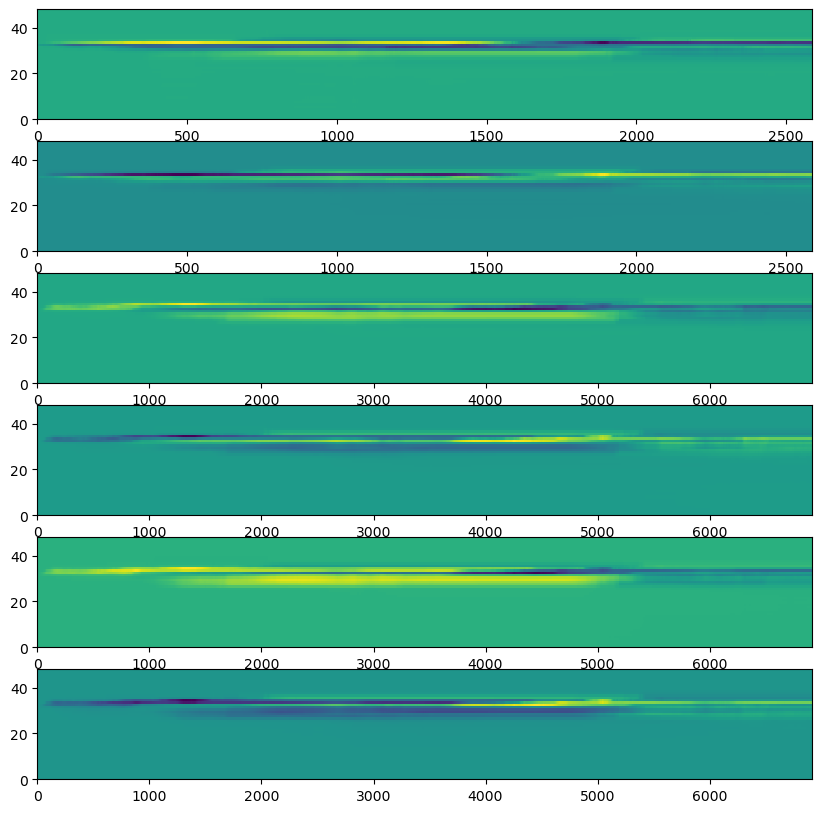

In [43]:
fig, ax = plt.subplots(nrows=6, figsize = (10, 10))
ax[0].pcolormesh(Cumsum_MeanHT_10km_sigma2, label='WAOM10')
ax[1].pcolormesh(Cumsum_EddyHT_10km_sigma2, label='WAOM10')

ax[2].pcolormesh(Cumsum_MeanHT_4km_sigma2, label='WAOM4')
ax[3].pcolormesh(Cumsum_EddyHT_4km_sigma2, label='WAOM10')

ax[4].pcolormesh(Cumsum_MeanHT_4kmNT_sigma2, label='WAOM4-NOTIDE')
ax[5].pcolormesh(Cumsum_EddyHT_4kmNT_sigma2, label='WAOM10')



NameError: name 'Cumsum_MeanHT_10km_sigma2' is not defined

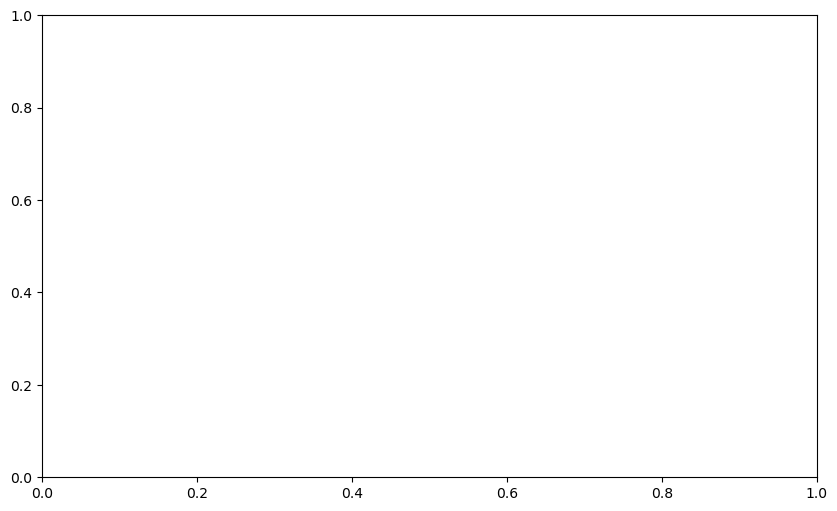

In [122]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(dist_along_10km,np.nansum(Cumsum_MeanHT_10km_sigma2,axis=0),'--r',label='WAOM10 Mean')       # 1. time-mean, 2. vertical integral
plt.plot(dist_along_4km,np.nansum(Cumsum_MeanHT_4km_sigma2,axis=0),'--b',label='WAOM4 Mean')       # 1. time-mean, 2. vertical integral
plt.plot(dist_along_4km,np.nansum(Cumsum_MeanHT_4kmNT_sigma2,axis=0),'--c',label='WAOM4-NOTIDE Mean')       # 1. time-mean, 2. vertical integral
plt.plot(dist_along_10km,np.nansum(Cumsum_EddyHT_10km_sigma2,axis=0),':r',label='WAOM10 Eddy')       # 1. time-mean, 2. vertical integral
plt.plot(dist_along_4km,np.nansum(Cumsum_EddyHT_4km_sigma2,axis=0),':b',label='WAOM4 Eddy')       # 1. time-mean, 2. vertical integral
plt.plot(dist_along_4km,np.nansum(Cumsum_EddyHT_4kmNT_sigma2,axis=0),':c',label='WAOM4-NOTIDE Eddy')       # 1. time-mean, 2. vertical integral
plt.legend()

### below need updates...

In [47]:
# print integrated values:

print('====================================================')
print('Sigma Net 2 - WAOM10 = ',np.nansum(Sum_10km_sigma2)*1e-12,' TW')
print('Sigma Net 2 - WAOM4 = ',np.nansum(Sum_4km_sigma2)*1e-12,' TW')
print('Sigma Net 2 - WAOM4-NOTIDE = ',np.nansum(Sum_4kmNT_sigma2)*1e-12,' TW')
print('====================================================')


NameError: name 'Sum_10km_sigma2' is not defined

In [47]:
print(Net_heat_transport_10km_irho2.shape)

(365, 48, 31, 2588)


In [48]:
# # SANITY CHECK: plot intergrated over density layers:


# fig, ax = plt.subplots(nrows=3, figsize = (12, 14))

# ax[0].plot(dist_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'--',label='WAOM10')       # 1. time-mean, 2. vertical integral
# ax[1].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'--',label='WAOM4')       
# ax[2].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'--',label='WAOM4-NOTIDE')

# for aa in range(0,3):
#     ax[aa].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[aa].set_xlim(0, dist_along_10km[-1])
#     # ax[aa].set_ylim(-4.5e14, 4.5e14)
#     ax[aa].set_ylim(-9e14, 9e14)
#     ax[aa].set_ylabel('Cumsum of cross-1500m heat \n transport per density class') #   'Cumulative heat transport \n across 1500m isobath (W)');
#     ax[aa].grid('on')
#     if aa==0:
#         ax[aa].legend(loc='best', bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))
#     if aa==2:
#         ax[aa].set_xlabel('Longitude coordinates along contour')
    
# ax[0].set_title('WAOM10 - $\sigma_{2}$')
# ax[1].set_title('WAOM4 - $\sigma_{2}$')
# ax[2].set_title('WAOM4-NOTIDE - $\sigma_{2}$')

# name_fig='WAOM10x4x4NT_Cross-1500m_cumtransport_Sigma2bin_vint-total_annual_v2.png'
# plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)


In [49]:
# integrate for intervals of density based on WM definitions:

# 36.8 - 36.9 - CDW: rho_grid2[16:18]
# 36.95 - still CDW? Changes a lot b/w 10-4km, specially West Antarct: rho_grid2[19]
# >37.0: DSW: rho_grid2[20:-1]




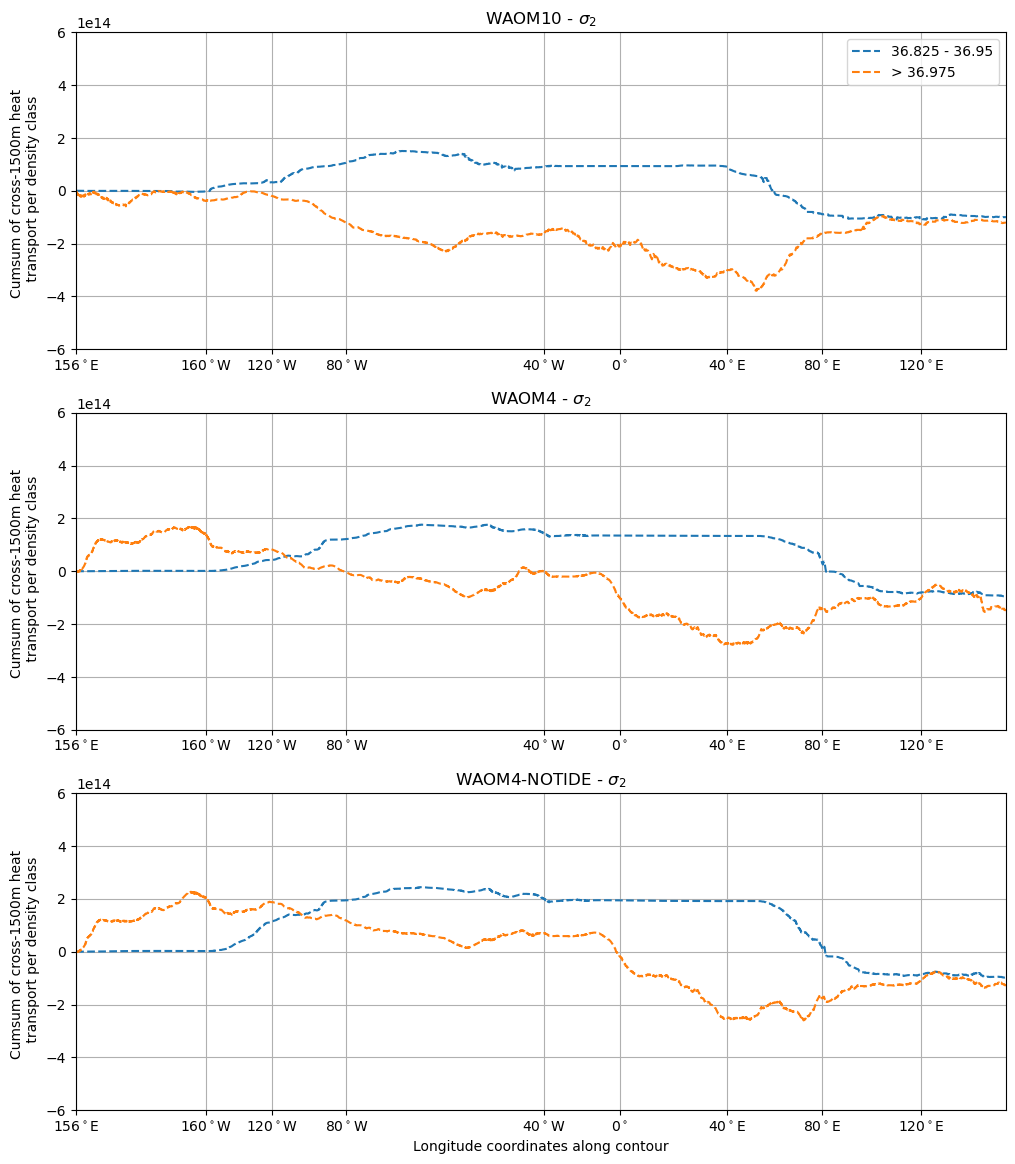

In [50]:
### -> used for dens (sig2) bins with 0.025 size:

fig, ax = plt.subplots(nrows=3, figsize = (12, 14))

ax[0].plot(dist_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,25:30,:,:], axis=1), axis=1),axis=0),'--',label='36.825 - 36.95')       # 1. time-mean, 2. vertical integral
ax[0].plot(dist_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,31:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 36.975')       # 1. time-mean, 2. vertical integral

ax[1].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,25:30,:,:], axis=1), axis=1),axis=0),'--',label='36.825 - 36.95')       # 1. time-mean, 2. vertical integral
ax[1].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,31:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 36.975')       # 1. time-mean, 2. vertical integral

ax[2].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,25:30,:,:], axis=1), axis=1),axis=0),'--',label='36.825 - 36.95')       # 1. time-mean, 2. vertical integral
ax[2].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,31:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 36.975')       # 1. time-mean, 2. vertical integral

for aa in range(0,3):
    ax[aa].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
    ax[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                              '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
    ax[aa].set_xlim(0, dist_along_10km[-1])
    ax[aa].set_ylim(-6e14, 6e14)
    ax[aa].set_ylabel('Cumsum of cross-1500m heat \n transport per density class') #   'Cumulative heat transport \n across 1500m isobath (W)');
    ax[aa].grid('on')
    if aa==0:
        ax[aa].legend(loc='best')#, bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))
    if aa==2:
        ax[aa].set_xlabel('Longitude coordinates along contour')
    
ax[0].set_title('WAOM10 - $\sigma_{2}$')
ax[1].set_title('WAOM4 - $\sigma_{2}$')
ax[2].set_title('WAOM4-NOTIDE - $\sigma_{2}$')

name_fig='WAOM10x4x4NT_Cross-1500m_cumtransport_Sigma2_perWMbins0.025_annual_v2.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)

In [51]:
### -> used for dens (sig2) bins with 0.05 size:

# fig, ax = plt.subplots(nrows=3, figsize = (12, 14))

# ax[0].plot(dist_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,16:18,:,:], axis=1), axis=1),axis=0),'--',label='36.8 - 36.9')       # 1. time-mean, 2. vertical integral
# ax[0].plot(dist_along_10km,np.nanmean(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,19,:,:], axis=1),axis=0),'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[0].plot(dist_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,20:21,:,:], axis=1), axis=1),axis=0),'--',label='37.0 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[0].plot(dist_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 37.1')       # 1. time-mean, 2. vertical integral

# ax[1].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,16:18,:,:], axis=1), axis=1),axis=0),'--',label='36.8 - 36.9')       # 1. time-mean, 2. vertical integral
# ax[1].plot(dist_along_4km,np.nanmean(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,19,:,:], axis=1),axis=0),'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[1].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,20:21,:,:], axis=1), axis=1),axis=0),'--',label='37.0 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[1].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 37.1')       # 1. time-mean, 2. vertical integral

# ax[2].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,16:18,:,:], axis=1), axis=1),axis=0),'--',label='36.8 - 36.9')       # 1. time-mean, 2. vertical integral
# ax[2].plot(dist_along_4km,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,19,:,:], axis=1),axis=0),'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[2].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,20:21,:,:], axis=1), axis=1),axis=0),'--',label='37.0 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[2].plot(dist_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 37.1')       # 1. time-mean, 2. vertical integral

# for aa in range(0,3):
#     ax[aa].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[aa].set_xlim(0, dist_along_10km[-1])
#     ax[aa].set_ylim(-2.5e14, 2.5e14)
#     ax[aa].set_ylabel('Cumsum of cross-1500m heat \n transport per density class') #   'Cumulative heat transport \n across 1500m isobath (W)');
#     ax[aa].grid('on')
#     if aa==0:
#         ax[aa].legend(loc='best', bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))
#     if aa==2:
#         ax[aa].set_xlabel('Longitude coordinates along contour')
    
# ax[0].set_title('WAOM10 - $\sigma_{2}$')
# ax[1].set_title('WAOM4 - $\sigma_{2}$')
# ax[2].set_title('WAOM4-NOTIDE - $\sigma_{2}$')

# name_fig='WAOM10x4x4NT_Cross-1500m_cumtransport_Sigma2_perWMbins_annual_v2.png'
# plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)

# doing TS diagrams per regions:


In [52]:
# read model lon/lat grid:

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

dg.close()

In [53]:
# mask per subregions following Dias et al (2023):

# create mask per longitude: Weddell, Maud Land, East Antarctica, Ross, West Antarctica
import matplotlib.path as mpath
import cartopy.feature as cfeature

# 1) Mask Weddell (90W : 25W, lat < -75, 65W : 25W, lat <= -75)
mask_Wed1lon = ma.masked_where(lon_rho <= -90, np.ones(lon_rho.shape)) # West limit for lat<-75
mask_Wed1lat = ma.masked_where(lat_rho > -75, np.ones(lat_rho.shape))
mask_Wed1 = mask_Wed1lon*mask_Wed1lat

mask_Wed2lon = ma.masked_where(lon_rho <= -65, np.ones(lon_rho.shape)) # West limit for lat<-75
mask_Wed2lat = ma.masked_where(lat_rho <= -75, np.ones(lat_rho.shape))
mask_Wed2 = mask_Wed2lon*mask_Wed2lat

mask_Wed12 = np.ma.array(mask_Wed1.filled(1) * mask_Wed2.filled(1), mask=(mask_Wed1.mask * mask_Wed2.mask))

mask_Wed3= ma.masked_where(lon_rho > -25, np.ones(lon_rho.shape)) # East limit for any latitude

mask_Wed = mask_Wed12*mask_Wed3

# 2) Mask Maud Land (25W : 60E, lat < -60)

mask_Mau1lon = ma.masked_where(lon_rho <= -25, np.ones(lon_rho.shape)) # East limit for any latitude
mask_Mau1lat = ma.masked_where(lat_rho > -60, np.ones(lat_rho.shape))
mask_Mau1 = mask_Mau1lon*mask_Mau1lat

mask_Mau2lon = ma.masked_where(lon_rho >= 60, np.ones(lon_rho.shape)) # East limit for any latitude
mask_Mau2lat = ma.masked_where(lat_rho > -60, np.ones(lat_rho.shape))
mask_Mau2 = mask_Mau2lon*mask_Mau2lat

mask_Mau = mask_Mau1*mask_Mau2

# 3) Mask East Antarctica (60E : 160E, lat < -60)

mask_EAnt1lon = ma.masked_where(lon_rho < 60, np.ones(lon_rho.shape)) # East limit for any latitude
mask_EAnt1lat = ma.masked_where(lat_rho > -60, np.ones(lat_rho.shape))
mask_EAnt1 = mask_EAnt1lon*mask_EAnt1lat

mask_EAnt2lon = ma.masked_where(lon_rho >= 160, np.ones(lon_rho.shape)) # East limit for any latitude
mask_EAnt2lat = ma.masked_where(lat_rho > -60, np.ones(lat_rho.shape))
mask_EAnt2 = mask_EAnt2lon*mask_EAnt2lat

mask_EAnt = mask_EAnt1*mask_EAnt2

# 4) Mask Ross (140W : 160E, lat < -60)

mask_Ros1lon = ma.masked_where(lon_rho < 160, np.ones(lon_rho.shape)) # East limit for any latitude
mask_Ros1lat = ma.masked_where(lat_rho > -60, np.ones(lat_rho.shape))
mask_Ros1 = mask_Ros1lon*mask_Ros1lat

mask_Ros2lon = ma.masked_where(lon_rho >= -149, np.ones(lon_rho.shape)) # East limit for any latitude
mask_Ros2lat = ma.masked_where(lat_rho > -60, np.ones(lat_rho.shape))
mask_Ros2 = mask_Ros2lon*mask_Ros2lat

mask_Ros = np.ma.array(mask_Ros1.filled(1) * mask_Ros2.filled(1), mask=(mask_Ros1.mask * mask_Ros2.mask))
# 5) Mask West Antarctica (150W : 90W, lat < -65)

mask_WAnt1 = ma.masked_where(lon_rho < -149, np.ones(lon_rho.shape)) # West limit for any latitude

mask_WAnt2lon = ma.masked_where(lon_rho > -90, np.ones(lon_rho.shape)) # East limit for lat <-73
mask_WAnt2lat = ma.masked_where(lat_rho > -75, np.ones(lat_rho.shape))
mask_WAnt2 = mask_WAnt2lon*mask_WAnt2lat

mask_WAnt3lon = ma.masked_where(lon_rho > -65, np.ones(lon_rho.shape)) # East limit for lat >-73
mask_WAnt3lat = ma.masked_where(lat_rho <= -75, np.ones(lat_rho.shape))
mask_WAnt3 = mask_WAnt3lon*mask_WAnt3lat

mask_WAnt23 = np.ma.array(mask_WAnt2.filled(1) * mask_WAnt3.filled(1), mask=(mask_WAnt2.mask * mask_WAnt3.mask))

mask_WAnt = mask_WAnt1*mask_WAnt23

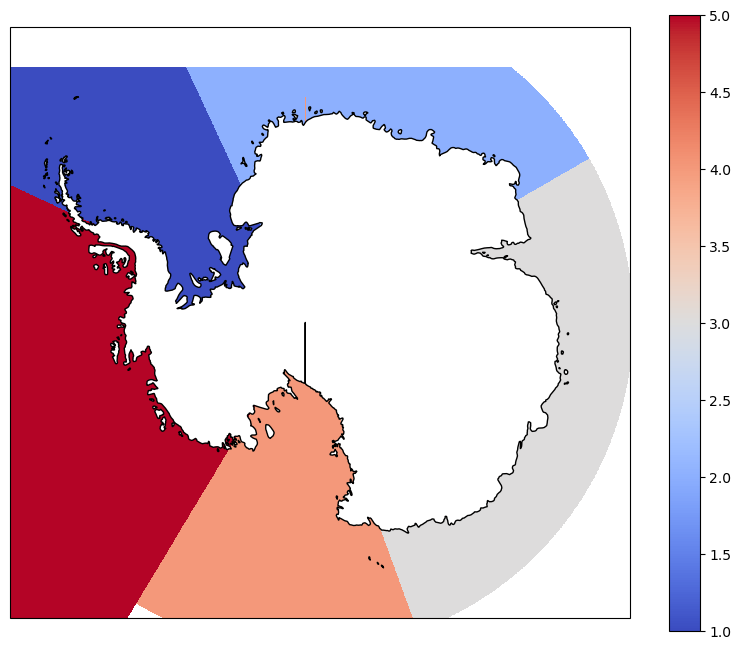

In [54]:
proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10,8))
# 1) Mask Weddell (90W : 25W, lat < -73, 65W : 25W, lat <= -73)
ax1 = fig.add_subplot(111, projection=proj)
c1=plt.pcolormesh(lon_rho, lat_rho, 1*np.ones(lon_rho.shape)*mask_Wed, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=1, vmax=5)
# 2) Mask Maud Land (25W : 60E, lat < -60)
c2=plt.pcolormesh(lon_rho, lat_rho, 2*np.ones(lon_rho.shape)*mask_Mau, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=1, vmax=5)
# 3) Mask East Antarctica (60E : 160E, lat < -60)
c3=plt.pcolormesh(lon_rho, lat_rho, 3*np.ones(lon_rho.shape)*mask_EAnt, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=1, vmax=5)
# 4) Mask Ross (140W : 160E, lat < -65)
c4=plt.pcolormesh(lon_rho, lat_rho, 4*np.ones(lon_rho.shape)*mask_Ros, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=1, vmax=5)
# 5) Mask West Antarctica (140W : 90W, lat < -60)
c5=plt.pcolormesh(lon_rho, lat_rho, 5*np.ones(lon_rho.shape)*mask_WAnt, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=1, vmax=5)
# 6) add contour line:
# ax1.plot(lon_along_10km[0:500], lat_along_10km[0:500], transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
plt.colorbar(c5)
# plt.clim([1,5])
plt.show()

# name_fig="waom10extend_subregion_masks.png"
# plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)

In [55]:
# define limits based on longitude along contour: WAOM10

ind_contour_Wed = np.where((np.round(lon_along_10km)>=-90) & (np.round(lon_along_10km)<-25)) # Weddell 90W-25W
ind_contour_Mau = np.where((np.round(lon_along_10km)>=-25) & (np.round(lon_along_10km)<60)) # Maud 25W-60E
ind_contour_EAnt = np.where((np.round(lon_along_10km)>=60) & (np.round(lon_along_10km)<160)) # East A 60E-160E
ind_contour_Ros = np.where((np.round(lon_along_10km)>=160) | (np.round(lon_along_10km)<-140)) # Ross 160E-140W
ind_contour_WAnt = np.where((np.round(lon_along_10km)>=-140) & (np.round(lon_along_10km)<-90)) # West A 140W-90W

# transform tuple from np.where to a labeled DataArray:
ind_Wed_10km = xr.DataArray(np.asarray(ind_contour_Wed[0]), dims=['contour_index_array'])
ind_Mau_10km = xr.DataArray(np.asarray(ind_contour_Mau[0]), dims=['contour_index_array'])
ind_EAnt_10km = xr.DataArray(np.asarray(ind_contour_EAnt[0]), dims=['contour_index_array'])
ind_Ros_10km = xr.DataArray(np.asarray(ind_contour_Ros[0]), dims=['contour_index_array'])
ind_WAnt_10km = xr.DataArray(np.asarray(ind_contour_WAnt[0]), dims=['contour_index_array'])
del ind_contour_Wed, ind_contour_Mau, ind_contour_EAnt, ind_contour_Ros, ind_contour_WAnt

In [56]:
# define limits based on longitude along contour: WAOM4

ind_contour_Wed = np.where((np.round(lon_along_4km)>=-90) & (np.round(lon_along_4km)<-25)) # Weddell 90W-25W
ind_contour_Mau = np.where((np.round(lon_along_4km)>=-25) & (np.round(lon_along_4km)<60)) # Maud 25W-60E
ind_contour_EAnt = np.where((np.round(lon_along_4km)>=60) & (np.round(lon_along_4km)<160)) # East A 60E-160E
ind_contour_Ros = np.where((np.round(lon_along_4km)>=160) | (np.round(lon_along_4km)<-140)) # Ross 160E-140W
ind_contour_WAnt = np.where((np.round(lon_along_4km)>=-140) & (np.round(lon_along_4km)<-90)) # West A 140W-90W

# transform tuple from np.where to a labeled DataArray:
ind_Wed_4km = xr.DataArray(np.asarray(ind_contour_Wed[0]), dims=['contour_index_array'])
ind_Mau_4km = xr.DataArray(np.asarray(ind_contour_Mau[0]), dims=['contour_index_array'])
ind_EAnt_4km = xr.DataArray(np.asarray(ind_contour_EAnt[0]), dims=['contour_index_array'])
ind_Ros_4km = xr.DataArray(np.asarray(ind_contour_Ros[0]), dims=['contour_index_array'])
ind_WAnt_4km = xr.DataArray(np.asarray(ind_contour_WAnt[0]), dims=['contour_index_array'])
del ind_contour_Wed, ind_contour_Mau, ind_contour_EAnt, ind_contour_Ros, ind_contour_WAnt

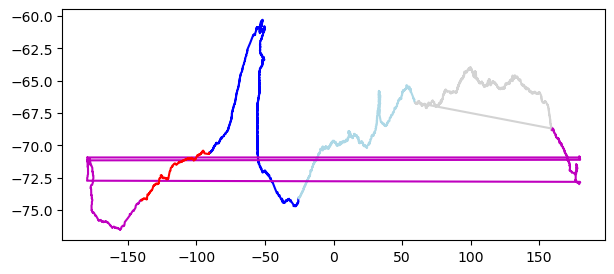

In [57]:

fig = plt.figure(figsize=(7,3))
# 1) Mask Weddell (90W : 25W, lat < -73, 65W : 25W, lat <= -73)
ax1 = fig.add_subplot(111)#, projection=proj)
# 6) add contour line:
ax1.plot(lon_along_10km[ind_Wed_10km], lat_along_10km[ind_Wed_10km],'b')#, transform=ccrs.PlateCarree())
ax1.plot(lon_along_10km[ind_Mau_10km], lat_along_10km[ind_Mau_10km],'lightblue')#, transform=ccrs.PlateCarree())
ax1.plot(lon_along_10km[ind_EAnt_10km], lat_along_10km[ind_EAnt_10km],'lightgray')#, transform=ccrs.PlateCarree())
ax1.plot(lon_along_10km[ind_Ros_10km], lat_along_10km[ind_Ros_10km],'m')#, transform=ccrs.PlateCarree())
ax1.plot(lon_along_10km[ind_WAnt_10km], lat_along_10km[ind_WAnt_10km],'r')#, transform=ccrs.PlateCarree())



# ax1.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
plt.colorbar(c5)
# plt.clim([1,5])
plt.show()


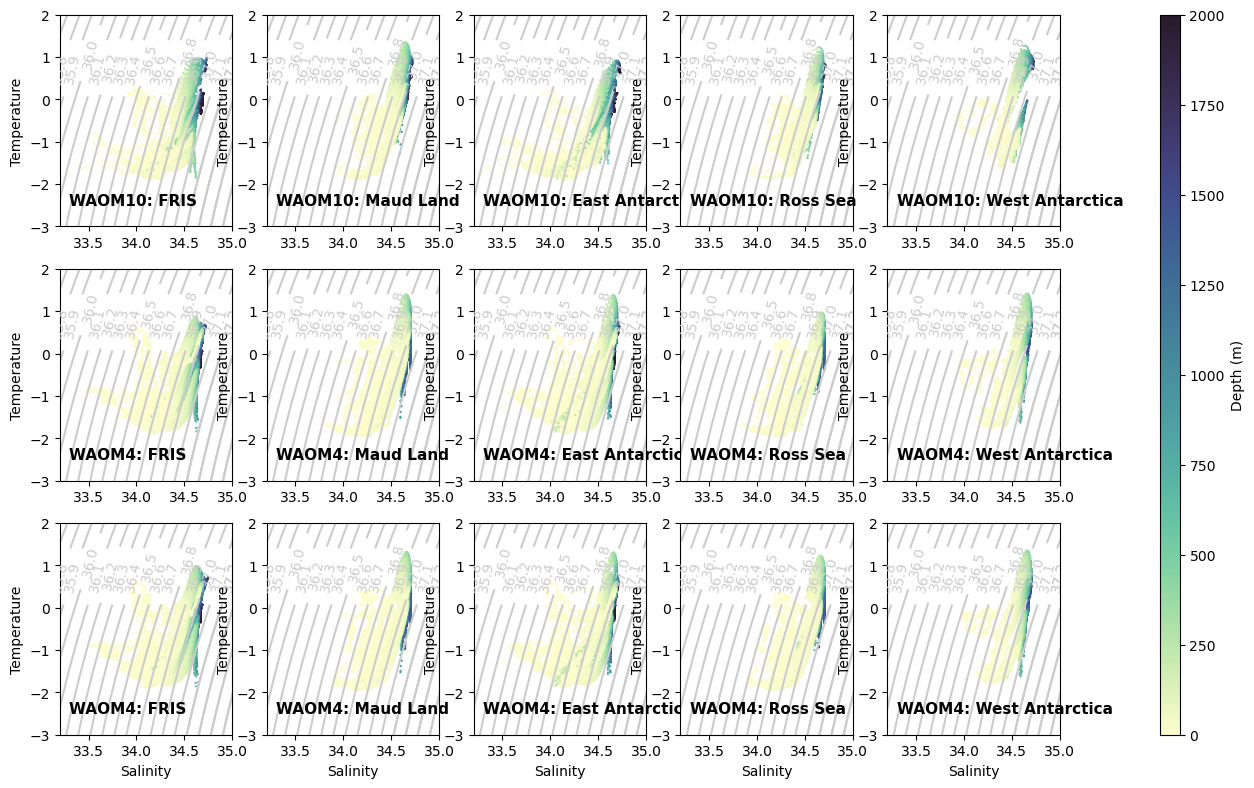

In [58]:
import cmocean

fig, ax = plt.subplots(nrows=3, ncols=5, figsize = (20, 12))
# normal isopycnals
for bb in range(0,5):
    for aa in range(0,3):
        CS1 = ax[aa,bb].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
        ax[aa,bb].clabel(CS1, CS1.levels, inline=True, fontsize=10)
        CS2 = ax[aa,bb].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
        ax[aa,bb].clabel(CS2, CS2.levels, inline=True, fontsize=10)
        ax[aa,bb].set_xlim([33.2,35])
        ax[aa,bb].set_ylim([-3,2])
        ax[aa,bb].set_ylabel('Temperature')
        if aa == 2:
            ax[aa,bb].set_xlabel('Salinity')

# FRIS
sc = ax[0,0].scatter(salt_10km.isel(contour_index_array=ind_Wed_10km).mean('ocean_time'),temp_10km.isel(contour_index_array=ind_Wed_10km).mean('ocean_time'),
                 c=-z_rho_10km.isel(contour_index_array=ind_Wed_10km).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,0].text(33.3,-2.5,'WAOM10: FRIS', fontsize=11, fontweight='bold')

sc = ax[1,0].scatter(salt_4km.isel(contour_index_array=ind_Wed_4km).mean('ocean_time'),temp_4km.isel(contour_index_array=ind_Wed_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_Wed_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,0].text(33.3,-2.5,'WAOM4: FRIS', fontsize=11, fontweight='bold')

sc = ax[2,0].scatter(salt_4kmNT.isel(contour_index_array=ind_Wed_4km).mean('ocean_time'),temp_4kmNT.isel(contour_index_array=ind_Wed_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_Wed_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,0].text(33.3,-2.5,'WAOM4: FRIS', fontsize=11, fontweight='bold')
# MAUD LAND
sc = ax[0,1].scatter(salt_10km.isel(contour_index_array=ind_Mau_10km).mean('ocean_time'),temp_10km.isel(contour_index_array=ind_Mau_10km).mean('ocean_time'),
                 c=-z_rho_10km.isel(contour_index_array=ind_Mau_10km).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,1].text(33.3,-2.5,'WAOM10: Maud Land', fontsize=11, fontweight='bold')

sc = ax[1,1].scatter(salt_4km.isel(contour_index_array=ind_Mau_4km).mean('ocean_time'),temp_4km.isel(contour_index_array=ind_Mau_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_Mau_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,1].text(33.3,-2.5,'WAOM4: Maud Land', fontsize=11, fontweight='bold')

sc = ax[2,1].scatter(salt_4kmNT.isel(contour_index_array=ind_Mau_4km).mean('ocean_time'),temp_4kmNT.isel(contour_index_array=ind_Mau_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_Mau_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,1].text(33.3,-2.5,'WAOM4: Maud Land', fontsize=11, fontweight='bold')
# East antarct.
sc = ax[0,2].scatter(salt_10km.isel(contour_index_array=ind_EAnt_10km).mean('ocean_time'),temp_10km.isel(contour_index_array=ind_EAnt_10km).mean('ocean_time'),
                 c=-z_rho_10km.isel(contour_index_array=ind_EAnt_10km).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,2].text(33.3,-2.5,'WAOM10: East Antarctica', fontsize=11, fontweight='bold')

sc = ax[1,2].scatter(salt_4km.isel(contour_index_array=ind_EAnt_4km).mean('ocean_time'),temp_4km.isel(contour_index_array=ind_EAnt_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_EAnt_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,2].text(33.3,-2.5,'WAOM4: East Antarctica', fontsize=11, fontweight='bold')

sc = ax[2,2].scatter(salt_4kmNT.isel(contour_index_array=ind_EAnt_4km).mean('ocean_time'),temp_4kmNT.isel(contour_index_array=ind_EAnt_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_EAnt_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,2].text(33.3,-2.5,'WAOM4: East Antarctica', fontsize=11, fontweight='bold')
# Ross.
sc = ax[0,3].scatter(salt_10km.isel(contour_index_array=ind_Ros_10km).mean('ocean_time'),temp_10km.isel(contour_index_array=ind_Ros_10km).mean('ocean_time'),
                 c=-z_rho_10km.isel(contour_index_array=ind_Ros_10km).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,3].text(33.3,-2.5,'WAOM10: Ross Sea', fontsize=11, fontweight='bold')

sc = ax[1,3].scatter(salt_4km.isel(contour_index_array=ind_Ros_4km).mean('ocean_time'),temp_4km.isel(contour_index_array=ind_Ros_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_Ros_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,3].text(33.3,-2.5,'WAOM4: Ross Sea', fontsize=11, fontweight='bold')

sc = ax[2,3].scatter(salt_4kmNT.isel(contour_index_array=ind_Ros_4km).mean('ocean_time'),temp_4kmNT.isel(contour_index_array=ind_Ros_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_Ros_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,3].text(33.3,-2.5,'WAOM4: Ross Sea', fontsize=11, fontweight='bold')
# West antarct.
sc = ax[0,4].scatter(salt_10km.isel(contour_index_array=ind_WAnt_10km).mean('ocean_time'),temp_10km.isel(contour_index_array=ind_WAnt_10km).mean('ocean_time'),
                 c=-z_rho_10km.isel(contour_index_array=ind_WAnt_10km).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,4].text(33.3,-2.5,'WAOM10: West Antarctica', fontsize=11, fontweight='bold')

sc = ax[1,4].scatter(salt_4km.isel(contour_index_array=ind_WAnt_4km).mean('ocean_time'),temp_4km.isel(contour_index_array=ind_WAnt_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_WAnt_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,4].text(33.3,-2.5,'WAOM4: West Antarctica', fontsize=11, fontweight='bold')

sc = ax[2,4].scatter(salt_4kmNT.isel(contour_index_array=ind_WAnt_4km).mean('ocean_time'),temp_4kmNT.isel(contour_index_array=ind_WAnt_4km).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_WAnt_4km),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,4].text(33.3,-2.5,'WAOM4: West Antarctica', fontsize=11, fontweight='bold')

# - cbar horiz
# cbar_ax1 = fig.add_axes([0.12, 0.005, 0.785, 0.01])
# fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
# cbar_ax1.set_xlabel('Depth (m)')
# - cbar vert
cbar_ax1 = fig.add_axes([0.8, 0.3, 0.01, 0.6])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_1500m_rho2_annnual_subregions.png"
plt.savefig(name_fig, bbox_inches='tight', dpi=300)

# Analyses for the region near Totten & Moscow Univ. Ice Shelves:

In [59]:
## getting index first:

ind_contour_TIS = np.where((np.round(lon_along_10km)>=95) & (np.round(lon_along_10km)<140))
# transform tuple from np.where to a labeled DataArray:
ind_TIS_10km = xr.DataArray(np.asarray(ind_contour_TIS[0]), dims=['contour_index_array'])

ind_contour_TIS = np.where((np.round(lon_along_4km)>=95) & (np.round(lon_along_4km)<140))
# transform tuple from np.where to a labeled DataArray:
ind_TIS_4km = xr.DataArray(np.asarray(ind_contour_TIS[0]), dims=['contour_index_array'])

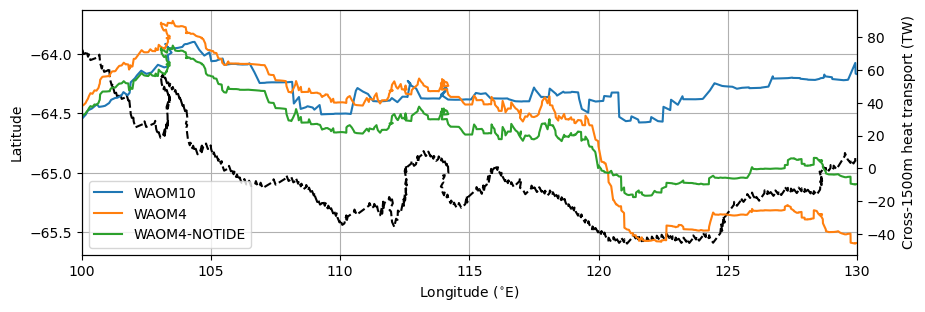

In [60]:
# plot cumsum HT only for the East Antarctica sector:

# var = Net_heat_transport_10km_irho2
# var = np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,ind_TIS_10km[:]], axis=1), axis=1),axis=0)
var_10km = Net_heat_transport_10km_irho2[:,:,:,ind_TIS_10km[:]]
var_4km = Net_heat_transport_4km_irho2[:,:,:,ind_TIS_4km[:]]
var_4kmNT = Net_heat_transport_4kmNT_irho2[:,:,:,ind_TIS_4km[:]]

vplot_10km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_10km, axis=1), axis=1), axis=1), axis=0)
vplot_4km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4km, axis=1), axis=1), axis=1), axis=0)
vplot_4kmNT = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4kmNT, axis=1), axis=1), axis=1), axis=0)


fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)#, projection=proj)
# ax1.plot(lon_along_10km[ind_TIS_10km[:]], lat_along_10km[ind_TIS_10km[:]],'lightgray')#, transform=ccrs.PlateCarree())
ax1.plot(lon_along_4km[ind_TIS_4km[:]], lat_along_4km[ind_TIS_4km[:]],linestyle='dashed',color='k',label='1500m isobath')#, transform=ccrs.PlateCarree())
# ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(lon_along_10km[ind_TIS_10km[:]], vplot_10km*1e-12,label='WAOM10')#, transform=ccrs.PlateCarree())
ax2.plot(lon_along_4km[ind_TIS_4km[:]], vplot_4km*1e-12,label='WAOM4')#, transform=ccrs.PlateCarree())
ax2.plot(lon_along_4km[ind_TIS_4km[:]], vplot_4kmNT*1e-12,label='WAOM4-NOTIDE')#, transform=ccrs.PlateCarree())
ax2.legend()

ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude ($^{\circ}$E)')
ax2.set_ylabel('Cross-1500m heat transport (TW)')
ax1.grid()

ax1.set_xlim(100,130)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Cross-1500m_HT_vint_annnual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

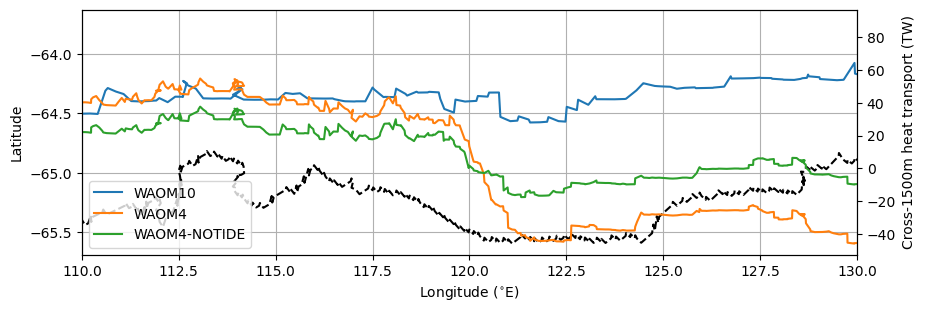

In [77]:
# plot cumsum HT only for the East Antarctica sector:

# var = Net_heat_transport_10km_irho2
# var = np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,ind_TIS_10km[:]], axis=1), axis=1),axis=0)
var_10km = Net_heat_transport_10km_irho2[:,:,:,ind_TIS_10km[:]]
var_4km = Net_heat_transport_4km_irho2[:,:,:,ind_TIS_4km[:]]
var_4kmNT = Net_heat_transport_4kmNT_irho2[:,:,:,ind_TIS_4km[:]]

vplot_10km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_10km, axis=1), axis=1), axis=1), axis=0)
vplot_4km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4km, axis=1), axis=1), axis=1), axis=0)
vplot_4kmNT = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4kmNT, axis=1), axis=1), axis=1), axis=0)


fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)#, projection=proj)
# ax1.plot(lon_along_10km[ind_TIS_10km[:]], lat_along_10km[ind_TIS_10km[:]],'lightgray')#, transform=ccrs.PlateCarree())
ax1.plot(lon_along_4km[ind_TIS_4km[:]], lat_along_4km[ind_TIS_4km[:]],linestyle='dashed',color='k',label='1500m isobath')#, transform=ccrs.PlateCarree())
# ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(lon_along_10km[ind_TIS_10km[:]], vplot_10km*1e-12,label='WAOM10')#, transform=ccrs.PlateCarree())
ax2.plot(lon_along_4km[ind_TIS_4km[:]], vplot_4km*1e-12,label='WAOM4')#, transform=ccrs.PlateCarree())
ax2.plot(lon_along_4km[ind_TIS_4km[:]], vplot_4kmNT*1e-12,label='WAOM4-NOTIDE')#, transform=ccrs.PlateCarree())
ax2.legend()

ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude ($^{\circ}$E)')
ax2.set_ylabel('Cross-1500m heat transport (TW)')
ax1.grid()

ax1.set_xlim(110,130)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Cross-1500m_HT_vint_annnual_EAntTIS_2.png"
plt.savefig(name_fig, dpi=300)

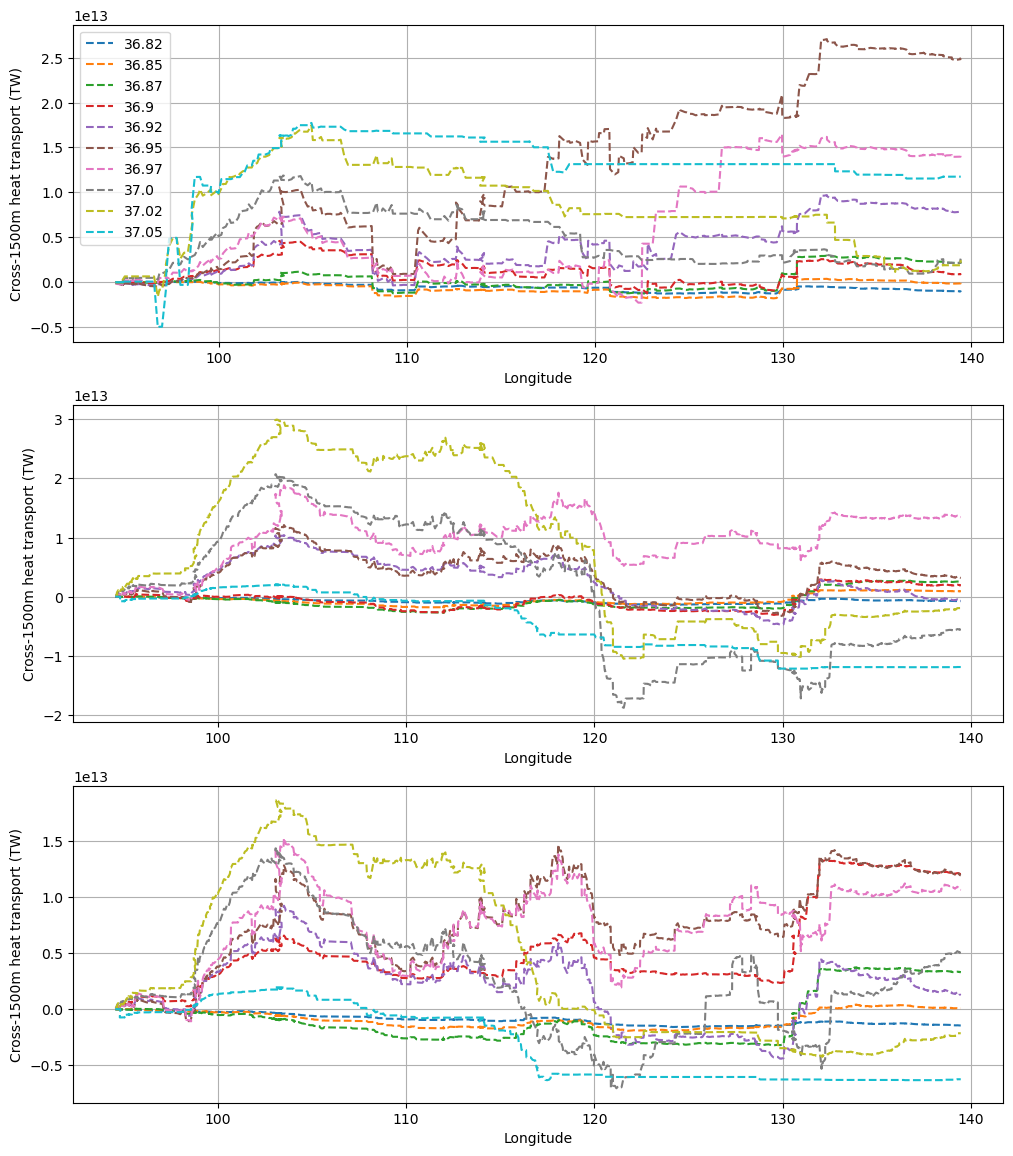

In [61]:
# fig2: per density bin:

# plot cumsum HT only for the East Antarctica sector:

# var = Net_heat_transport_10km_irho2
# var = np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,ind_TIS_10km[:]], axis=1), axis=1),axis=0)
var_10km = Net_heat_transport_10km_irho2[:,:,:,ind_TIS_10km[:]]
var_4km = Net_heat_transport_4km_irho2[:,:,:,ind_TIS_4km[:]]
var_4kmNT = Net_heat_transport_4kmNT_irho2[:,:,:,ind_TIS_4km[:]]

vplot_10km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_10km, axis=1), axis=2), axis=0), axis=1)
vplot_4km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4km, axis=1), axis=2), axis=0), axis=1)
vplot_4kmNT = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4kmNT, axis=1), axis=2), axis=0), axis=1)


fig, ax = plt.subplots(nrows=3, figsize = (12, 14))
# ax[0].plot(lon_along_4km[ind_TIS_4km[:]], lat_along_4km[ind_TIS_4km[:]],linestyle='dashed',color='k',label='1500m isobath')#, transform=ccrs.PlateCarree())
# ax[0].legend()

for ll in np.arange(25,35,1):
    ax[0].plot(lon_along_10km[ind_TIS_10km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,ind_TIS_10km[:]], axis=2), axis=0), axis=1),'--',label=str(round(rho_grid2[ll],2)))  
    ax[1].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'--',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
    ax[2].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'--',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# for ll in np.arange(35,45,1):
#     ax[0].plot(lon_along_10km[ind_TIS_10km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,ind_TIS_10km[:]], axis=2), axis=0), axis=1),'-',label=str(round(rho_grid2[ll],2)))  
#     ax[1].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
#     ax[2].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# MCDW = rho2[28:32]
# DSW = rho2[32:35]

ax[0].legend()
for aa in np.arange(0,3):
    ax[aa].set_ylabel('Latitude')
    ax[aa].set_xlabel('Longitude')
    ax[aa].set_ylabel('Cross-1500m heat transport (TW)')
    ax[aa].grid()

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Cross-1500m_HT_sig2_annnual_subregions.png"
plt.savefig(name_fig, dpi=300)

In [62]:
print(Net_heat_transport_10km_irho2[:,ll,:,ind_TIS_10km[:]].shape, lon_along_10km[ind_TIS_10km[:]].shape)
print(np.nansum(Net_heat_transport_10km_irho2[:,28:32,:,ind_TIS_10km[:]], axis=1).shape)
# print(np.cumsum(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,ind_TIS_10km[:]], axis=2), axis=0).shape)
# print(np.nanmean(np.cumsum(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,ind_TIS_10km[:]], axis=2), axis=0), axis=1).shape)

(329, 365, 31) (329,)
(365, 31, 329)


In [63]:
Net_heat_transport_10km_irho2[:,28:32,:,ind_TIS_10km[:]].shape

(365, 4, 31, 329)

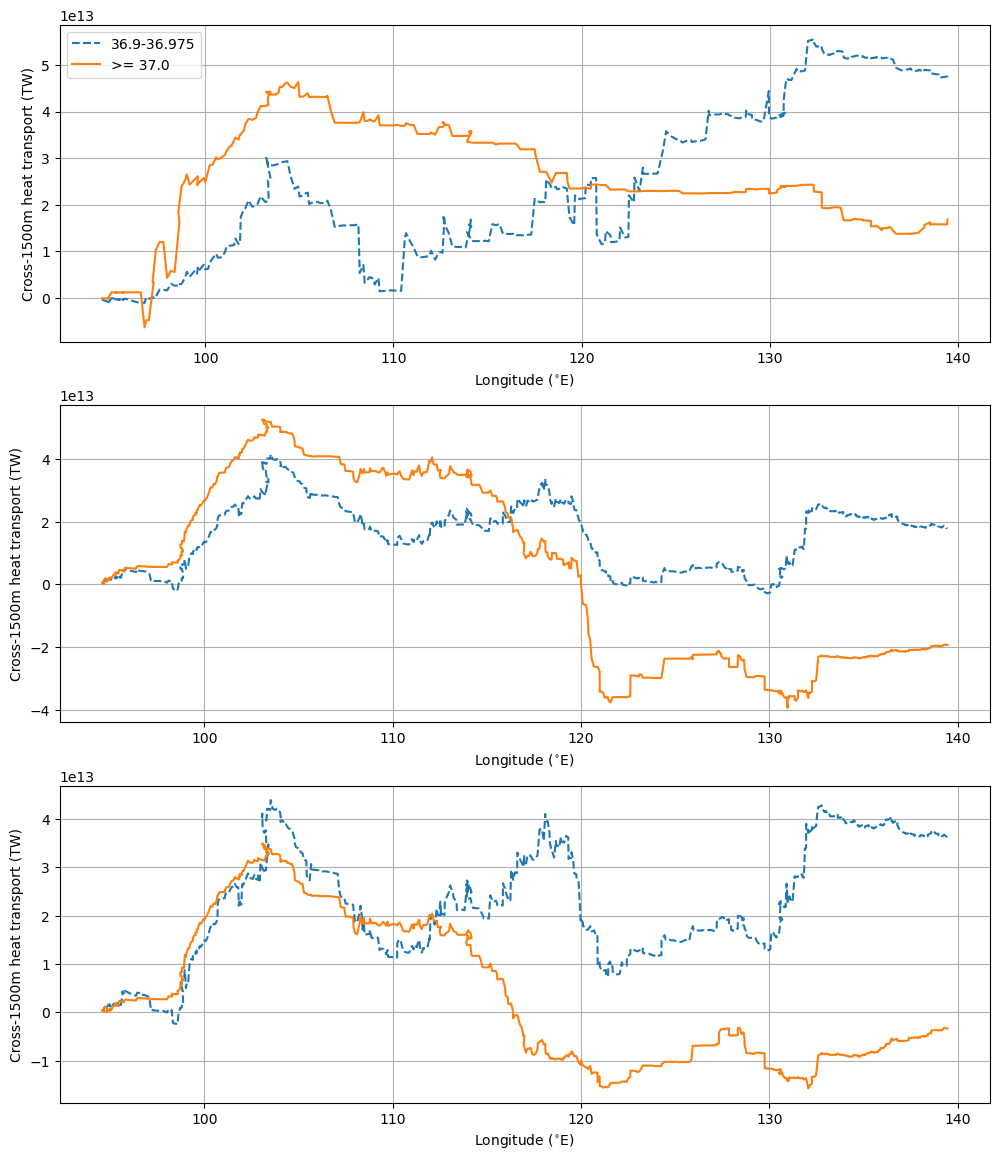

In [64]:
# fig2: per density bin:

# plot cumsum HT only for the East Antarctica sector:

fig, ax = plt.subplots(nrows=3, figsize = (12, 14))
# ax[0].plot(lon_along_4km[ind_TIS_4km[:]], lat_along_4km[ind_TIS_4km[:]],linestyle='dashed',color='k',label='1500m isobath')#, transform=ccrs.PlateCarree())
# ax[0].legend()
ax[0].plot(lon_along_10km[ind_TIS_10km[:]],np.nanmean(np.cumsum(np.nansum(np.nansum(Net_heat_transport_10km_irho2[:,28:32,:,ind_TIS_10km[:]], axis=1), axis=1), axis=1), axis=0),'--',label='36.9-36.975')
ax[1].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(np.nansum(Net_heat_transport_4km_irho2[:,28:32,:,ind_TIS_4km[:]], axis=1), axis=1), axis=1), axis=0),'--',label='36.9-36.975')
ax[2].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2[:,28:32,:,ind_TIS_4km[:]], axis=1), axis=1), axis=1), axis=0),'--',label='36.9-36.975')
# MCDW = rho2[28:32]
ax[0].plot(lon_along_10km[ind_TIS_10km[:]],np.nanmean(np.cumsum(np.nansum(np.nansum(Net_heat_transport_10km_irho2[:,32:35,:,ind_TIS_10km[:]], axis=1), axis=1), axis=1), axis=0),'-',label='>= 37.0')
ax[1].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(np.nansum(Net_heat_transport_4km_irho2[:,32:35,:,ind_TIS_4km[:]], axis=1), axis=1), axis=1), axis=0),'-',label='>= 37.0')
ax[2].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2[:,32:35,:,ind_TIS_4km[:]], axis=1), axis=1), axis=1), axis=0),'-',label='>= 37.0')
# DSW = rho2[32:35]

ax[0].legend()
for aa in np.arange(0,3):
    ax[aa].set_ylabel('Latitude')
    ax[aa].set_xlabel('Longitude ($^{\circ}$E)')
    ax[aa].set_ylabel('Cross-1500m heat transport (TW)')
    ax[aa].grid()

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Cross-1500m_HT_MCDWxDSW_annnual_subregions.png"
plt.savefig(name_fig, dpi=300)

In [65]:
# Net_heat_transport_10km_irho2[:,25:28,:,ind_TIS_10km].shape
# np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,25:28,:,ind_TIS_10km], axis=1), axis=0).shape

In [66]:
# rho_grid2[32:35]

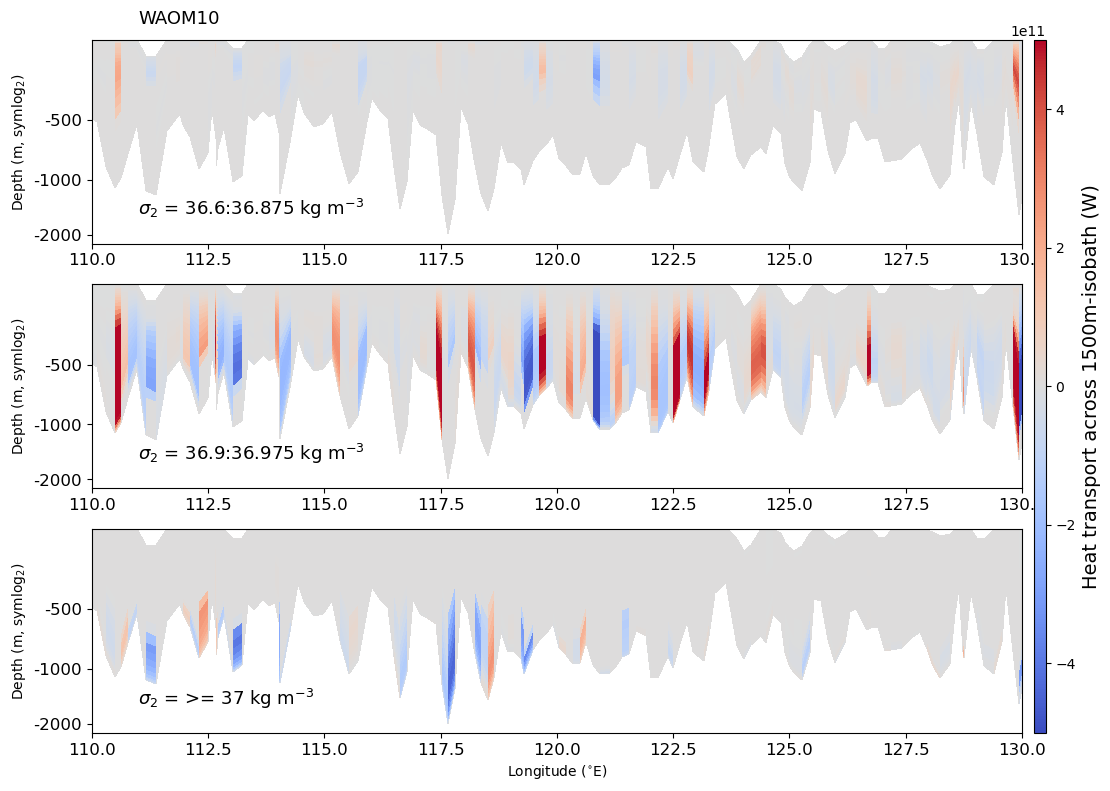

In [67]:
fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'WAOM10',fontsize=13)
aa = ax[0].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,20:28,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[0].text(111,-1600,'$\sigma_{2}$ = 36.6:36.875 kg m$^{-3}$',fontsize=13)
ax[0].set_xlim(110,130)

ax[1].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,28:32,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[1].text(111,-1600,'$\sigma_{2}$ = 36.9:36.975 kg m$^{-3}$',fontsize=13)
ax[1].set_xlim(110,130)

ax[2].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,32:35,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[2].text(111,-1600,'$\sigma_{2}$ = >= 37 kg m$^{-3}$',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    # ax[bb].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
    ax[bb].set_yscale('symlog',base = 2, linthresh=700)
    ax[bb].set_ylabel('Depth (m, symlog$_2$)')
    ax[bb].set_yticklabels(['-2000','-1000','-500'])
    ax[bb].set_aspect('auto')
    ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across 1500m-isobath (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Net_heat_transp_1500m_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

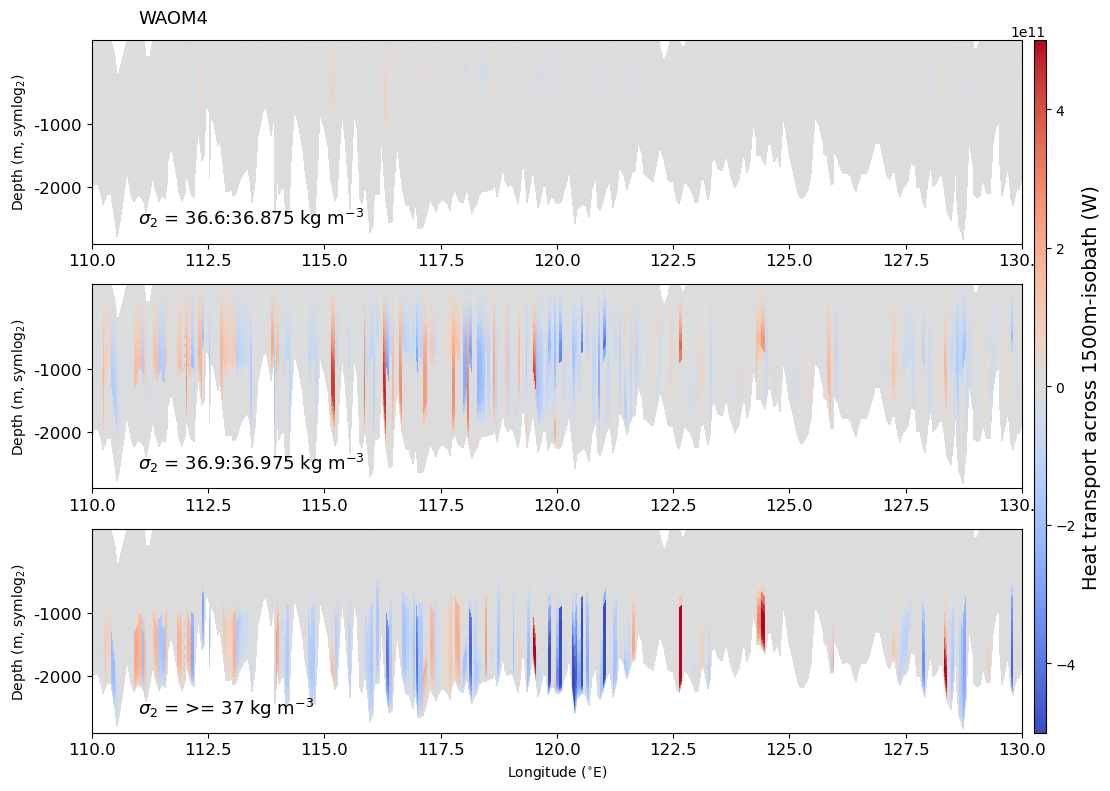

In [68]:
fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'WAOM4',fontsize=13)
aa = ax[0].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,20:28,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[0].text(111,-1600,'$\sigma_{2}$ = 36.6:36.875 kg m$^{-3}$',fontsize=13)
ax[0].set_xlim(110,130)

ax[1].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,28:32,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[1].text(111,-1600,'$\sigma_{2}$ = 36.9:36.975 kg m$^{-3}$',fontsize=13)
ax[1].set_xlim(110,130)

ax[2].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,32:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[2].text(111,-1600,'$\sigma_{2}$ = >= 37 kg m$^{-3}$',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    # ax[bb].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
    ax[bb].set_yscale('symlog',base = 2, linthresh=700)
    ax[bb].set_ylabel('Depth (m, symlog$_2$)')
    ax[bb].set_yticklabels(['-2000','-1000','-500'])
    ax[bb].set_aspect('auto')
    ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across 1500m-isobath (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Net_heat_transp_1500m_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

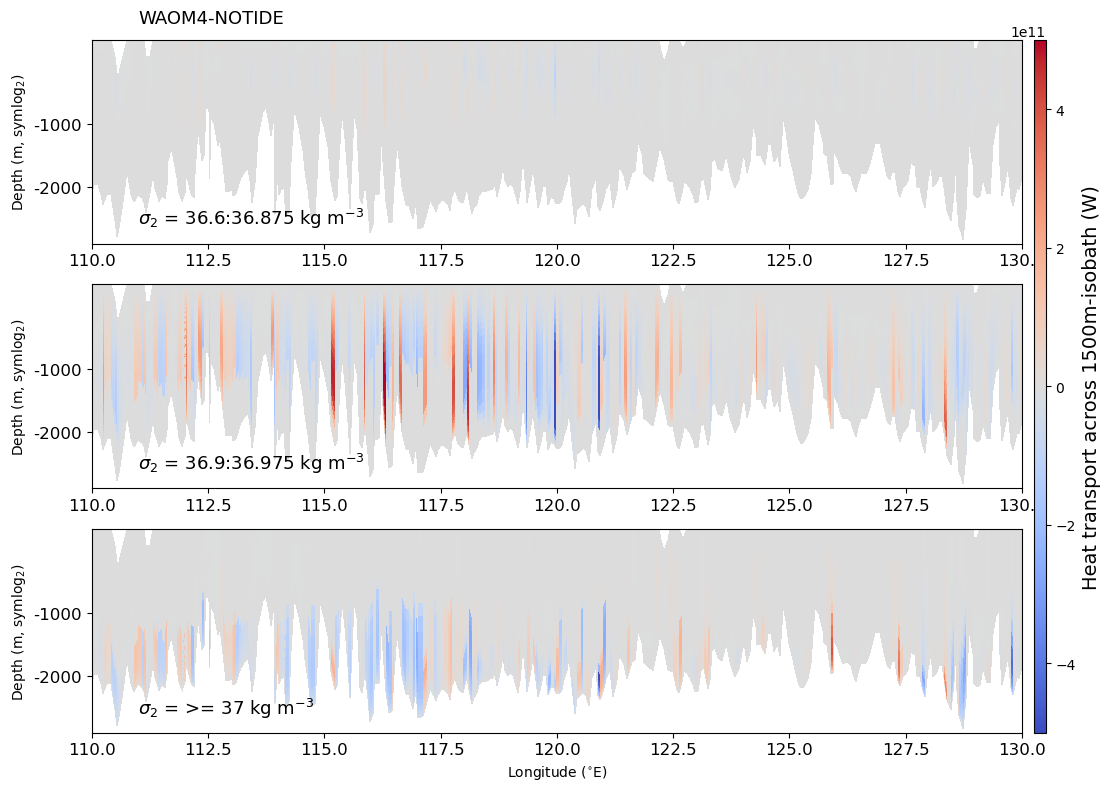

In [69]:
fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'WAOM4-NOTIDE',fontsize=13)
aa = ax[0].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,20:28,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[0].text(111,-1600,'$\sigma_{2}$ = 36.6:36.875 kg m$^{-3}$',fontsize=13)
ax[0].set_xlim(110,130)

ax[1].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,28:32,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[1].text(111,-1600,'$\sigma_{2}$ = 36.9:36.975 kg m$^{-3}$',fontsize=13)
ax[1].set_xlim(110,130)

ax[2].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,32:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[2].text(111,-1600,'$\sigma_{2}$ = >= 37 kg m$^{-3}$',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    # ax[bb].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
    ax[bb].set_yscale('symlog',base = 2, linthresh=700)
    ax[bb].set_ylabel('Depth (m, symlog$_2$)')
    ax[bb].set_yticklabels(['-2000','-1000','-500'])
    ax[bb].set_aspect('auto')
    ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across 1500m-isobath (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4-notides_Net_heat_transp_1500m_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

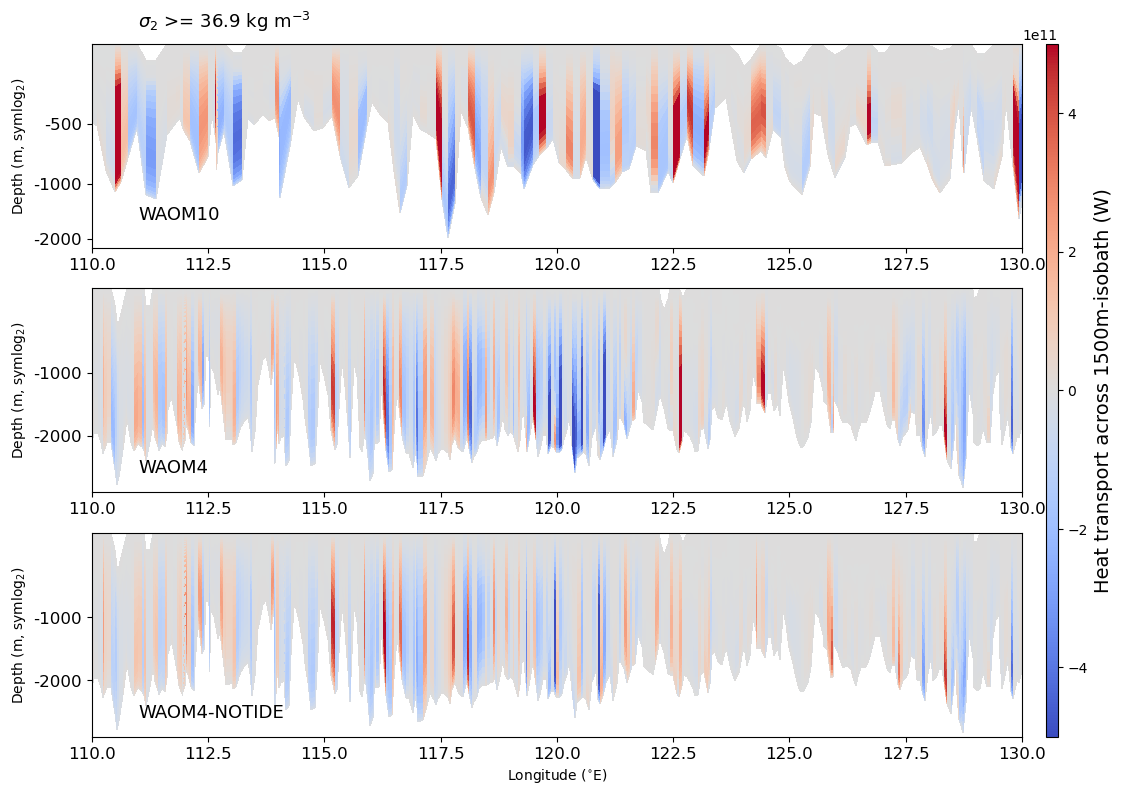

In [76]:
# 1 figure for sig2>=36.9 for WAOM10x4x4NT

fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'$\sigma_{2}$ >= 36.9 kg m$^{-3}$',fontsize=13)
aa=ax[0].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,28:35,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[0].text(111,-1600,'WAOM10',fontsize=13)
ax[0].set_xlim(110,130)

aa=ax[1].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,28:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[1].text(111,-1600,'WAOM4',fontsize=13)
ax[1].set_xlim(110,130)

aa=ax[2].pcolormesh(lon_along_4km[ind_TIS_4km],z_rho_4km.fillna(0)[:,ind_TIS_4km],np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,28:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e11, vmax=5e11, cmap='coolwarm')
ax[2].text(111,-1600,'WAOM4-NOTIDE',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    # ax[bb].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
    ax[bb].set_yscale('symlog',base = 2, linthresh=700)
    ax[bb].set_ylabel('Depth (m, symlog$_2$)')
    ax[bb].set_yticklabels(['-2000','-1000','-500'])
    ax[bb].set_aspect('auto')
    ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.92, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across 1500m-isobath (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Net_heat_transp_1500m_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

In [70]:
print(lon_along_10km[int(ind_EAnt_10km[35])])
# print(lon_along_10km.shape, int(ind_EAnt_10km[35]))

<xarray.Variable ()>
array(60.089004)
Attributes:
    long_name:      longitude of u-points
    standard_name:  longitude
    units:          degree_east


In [71]:
# plt.plot(ind_EAnt_10km[35:-1]) # remove jumping in indexes, 10km
# plt.plot(ind_EAnt_4km[111:-1]) # remove jumping in indexes, 4km


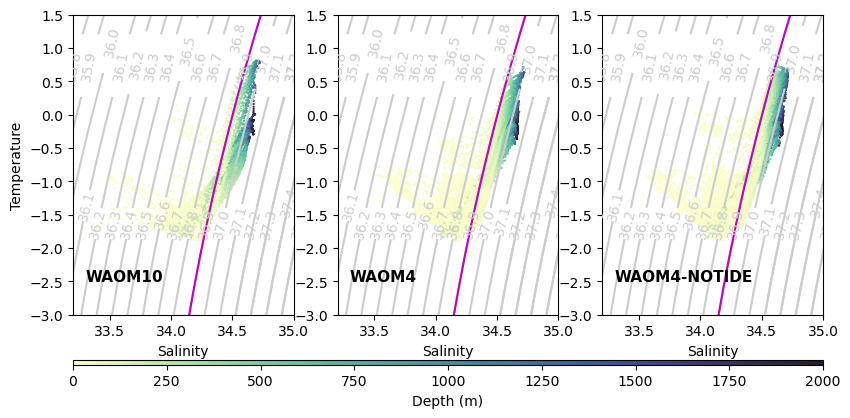

2023-10-10 17:56:54,950 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:54,954 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:54,959 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:54,990 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:54,999 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,009 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,019 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,059 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,062 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,066 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,072 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,079 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,092 - distributed.nanny - WARNING - Restarting worker
2023-10-10 17:56:55,101 - distributed.

In [80]:
import cmocean

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))
# normal isopycnals
for bb in range(0,3):
    CS1 = ax[bb].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[bb].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    CS2 = ax[bb].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[bb].clabel(CS2, CS2.levels, inline=True, fontsize=10)
    ax[bb].set_xlim([33.2,35])
    ax[bb].set_ylim([-3,1.5])
    ax[0].set_ylabel('Temperature')
    ax[bb].set_xlabel('Salinity')# East antarct.

    c369 = ax[bb].contour(Si,Ti,dens.transpose(), levels=[36.9, 37.9],linestyles='solid', colors='m', linewidth=0.1)
    ax[bb].clabel(CS1, CS1.levels, inline=True, fontsize=10)
            
sc = ax[0].scatter(salt_10km.isel(contour_index_array=ind_TIS_10km[:]).mean('ocean_time'),temp_10km.isel(contour_index_array=ind_TIS_10km[:]).mean('ocean_time'),
                 c=-z_rho_10km.isel(contour_index_array=ind_TIS_10km[:]).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0].text(33.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1].scatter(salt_4km.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),temp_4km.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_TIS_4km[:]),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1].text(33.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2].scatter(salt_4kmNT.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),temp_4kmNT.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_TIS_4km[:]),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2].text(33.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')

# - cbar horiz
cbar_ax1 = fig.add_axes([0.25, 0.2, 0.5, 0.01])
fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
cbar_ax1.set_xlabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_1500m_rho2_annnual_EastAnt.png"
plt.savefig(name_fig, dpi=300)